**Identifying features that influence low-income student success**

by Ben Lacar
<br>
March 2019

- Exploratory anaysis of features and target
- Geospatial data

In [1]:
# Import packages

# Web scraping
import os
import urllib.request
import requests
from io import StringIO
from bs4 import BeautifulSoup

# Use xml package for GreatSchools data
import xml.etree.ElementTree as ET

# Dataframe munging and statistics
import re
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Data visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%matplotlib inline

# Stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats import multitest

In [2]:
# Colors and formatting
# Google theme html colors from here https://imagecolorpicker.com
B_beige = "#CDA577"
B_brown = "#643E34"
B_slate = "#3F5B66"
B_dkgray = "#5A7E8E"
B_ltgray = "#6D949B"
B_green = "#01CB8B"
B_lime = "#D3F04A"

B_colors = [B_beige, B_brown, B_slate, B_dkgray, B_ltgray, B_green, B_lime]
B_colors_cat = [B_beige, B_green, B_brown, B_ltgray, B_slate, B_lime, B_dkgray]

# Code formatting Jupyter black
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
sns.set_context(
    "talk", rc={"font.size": 16, "axes.titlesize": 16, "axes.labelsize": 14}
)

<IPython.core.display.Javascript object>

In [4]:
sns.set_context("talk")

<IPython.core.display.Javascript object>

In [5]:
def scatter_plot_open_circles(df, feature_x, feature_y, ax):
    x = df[feature_x]
    y = df[feature_y]
    ax.scatter(x, y, facecolors="none", edgecolors=B_dkgray)
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)

<IPython.core.display.Javascript object>

In [6]:
def hist_plot(df, feature, ax):
    df[feature].hist(ax=ax, bins=30, color=B_slate)
    ax.set_title(feature)

<IPython.core.display.Javascript object>

# Import data

In [7]:
parent_path = "/Users/lacar/Documents/Data_science/Jupyter_notebooks/Education_study/"
os.chdir(parent_path)
os.getcwd()

'/Users/lacar/Documents/Data_science/Jupyter_notebooks/Education_study'

<IPython.core.display.Javascript object>

In [8]:
figure_loc = 'results/'

<IPython.core.display.Javascript object>

In [9]:
# Import data from data cleaning
df_state_info_gs_census = pd.read_csv(
    "data/b_intermediate/df_state_info_gs_census_200514.csv", index_col=0
)

<IPython.core.display.Javascript object>

In [10]:
df_state_info_gs_census.head()

NCESDist  NCESSchool  NCESDistSchool StatusType   County  \
0    691051       10947     69105110947     Active  Alameda   
1    601770          41     60177000041     Active  Alameda   
3    628050       10726     62805010726     Active  Alameda   
4    601860          59     60186000059     Active  Alameda   
5    604740         432     60474000432     Active  Alameda   

                             District                                  School  \
0  Alameda County Office of Education  Envision Academy for Arts & Technology   
1                     Alameda Unified                            Alameda High   
3                     Oakland Unified       Lighthouse Community Charter High   
4                 Albany City Unified                             Albany High   
5                    Berkeley Unified                           Berkeley High   

                    Street            StreetAbr      City  ...  \
0      1515 Webster Street     1515 Webster St.   Oakland  ...   
1      2200 Central Avenue    2200 Central Ave.   Alameda  ...   
3     444 Hegenberger Road  444 Hegenberger Rd.   Oakland  ...   
4  603 Key Route Boulevard  603 Key Route Blvd.    Albany  ...   
5         1980 Allston Way     1980 Allston Way  Berkeley  ...   

  test_score_rating_LIstudents  test_score_rating_notLIstudents  \
0                          4.0                              4.0   
1                          8.0                             10.0   
3                          7.0                              7.0   
4                          8.0                             10.0   
5                          5.0                             10.0   

  test_scores_english_LIstudents  test_scores_math_LIstudents  \
0                           47.0                         18.0   
1                           64.0                         49.0   
3                           63.0                          NaN   
4                           66.0                         45.0   
5                           45.0                         27.0   

   test_scores_math_LIstudents_n_students  \
0                                    77.0   
1                                   104.0   
3                                     NaN   
4                                    55.0   
5                                   172.0   

   graduation_rates_gradRates_eligibility_allStudents  \
0                                               82.0    
1                                               95.0    
3                                               75.0    
4                                               93.0    
5                                               89.0    

   graduation_rates_gradRates_eligibility_LIstudents  \
0                                               83.0   
1                                               94.0   
3                                               77.0   
4                                               92.0   
5                                               89.0   

   graduation_rates_UCCSU_eligibility_allStudents  \
0                                           100.0   
1                                            66.0   
3                                           100.0   
4                                            63.0   
5                                            66.0   

   graduation_rates_UCCSU_eligibility_nonLIstudents  \
0                                        100.000000   
1                                         69.512195   
3                                        100.000000   
4                                         66.686747   
5                                         72.222222   

   graduation_rates_UCCSU_eligibility_LIstudents  
0                                          100.0  
1                                           50.0  
3                                          100.0  
4                                           45.0  
5                                           50.0  

[5 rows x 70 columns]

<IPython.core.display.Javascript object>

In [11]:
df_state_info_gs_census.columns

Index(['NCESDist', 'NCESSchool', 'NCESDistSchool', 'StatusType', 'County',
       'District', 'School', 'Street', 'StreetAbr', 'City', 'Zip', 'zip_code',
       'State', 'Latitude', 'Longitude', 'E12',
       '%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months',
       '%; INCOME_BENEFITS - w/ Social Security',
       '%; INCOME_BENEFITS - w/ Supplemental Security Income',
       'Est.; INCOME_BENEFITS - Total households - Median household income ($)',
       'Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)',
       'Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)',
       '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage',
       '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage',
       '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs - No health ins coverage',
       '%; WORK_C

<IPython.core.display.Javascript object>

# Exploration of schools

## Variability by school size

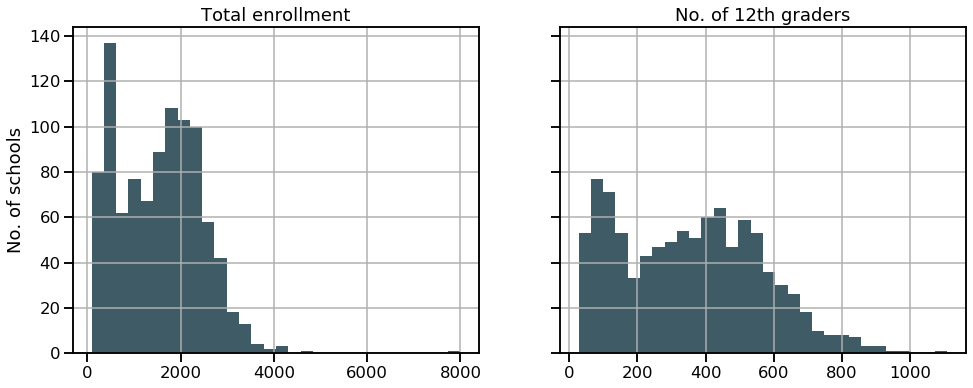

<IPython.core.display.Javascript object>

In [910]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6), sharey=True)
hist_plot(df_state_info_gs_census, "enrollment", ax1)
ax1.set_ylabel("No. of schools")
ax1.set_title("Total enrollment")

hist_plot(df_state_info_gs_census, "E12", ax2)
ax2.set_title("No. of 12th graders");

In [887]:
print('No. of 12th graders (mean +/- SD): {0:0.1f} +/- {1:0.1f}'.format(df_state_info_gs_census['E12'].mean(), df_state_info_gs_census['E12'].std()))

No. of 12th graders (mean +/- SD): 355.1 +/- 207.9


<IPython.core.display.Javascript object>

In [888]:
print('No. of 12th graders (min - max): {0:d} - {1:d}'.format(df_state_info_gs_census['E12'].min(), df_state_info_gs_census['E12'].max()))

No. of 12th graders (min - max): 27 - 1110


<IPython.core.display.Javascript object>

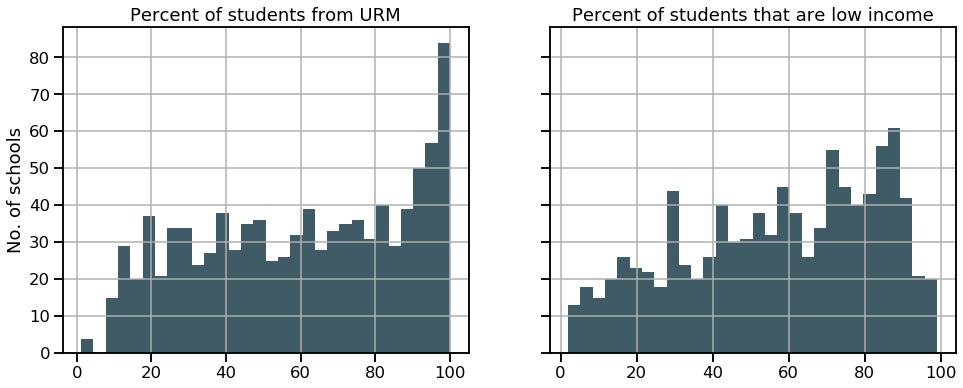

<IPython.core.display.Javascript object>

In [169]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6), sharey=True)
hist_plot(df_state_info_gs_census, "pct_URM", ax1)
ax1.set_ylabel("No. of schools")
ax1.set_title("Percent of students from URM")

hist_plot(df_state_info_gs_census, "pct_LI_students", ax2)
ax2.set_title("Percent of students that are low income");

In [882]:
df_state_info_gs_census['pct_URM'].mean()

60.02963348850863

<IPython.core.display.Javascript object>

In [883]:
df_state_info_gs_census['pct_URM'].std()

27.549289412741192

<IPython.core.display.Javascript object>

## Number of schools by county

In [103]:
print('No. of counties: ', len(df_state_info_gs_census['County'].unique()))

No. of counties:  55


<IPython.core.display.Javascript object>

In [95]:
df_state_info_gs_census['County'].value_counts()

Los Angeles        234
San Diego           73
Orange              59
Riverside           52
San Bernardino      52
Sacramento          43
Santa Clara         42
Alameda             32
Fresno              28
San Joaquin         22
Tulare              21
Ventura             21
San Mateo           19
Contra Costa        19
Stanislaus          19
Kern                16
Monterey            13
San Francisco       13
Placer              12
Solano              12
Merced              11
San Luis Obispo      9
Sonoma               9
Santa Barbara        9
Shasta               9
Butte                9
Imperial             8
Santa Cruz           8
Mendocino            7
Madera               7
Marin                7
Kings                7
Humboldt             6
Yolo                 6
El Dorado            5
Napa                 5
Lake                 4
Siskiyou             4
Yuba                 4
Sutter               3
Colusa               3
Tehama               3
Glenn                2
Nevada     

<IPython.core.display.Javascript object>

In [862]:
df_state_info_gs_census['County'].value_counts().sum()

966

<IPython.core.display.Javascript object>

In [865]:
(df_state_info_gs_census['County'].value_counts() < 10).sum()

34

<IPython.core.display.Javascript object>

In [863]:
len(df_state_info_gs_census['County'].unique())

55

<IPython.core.display.Javascript object>

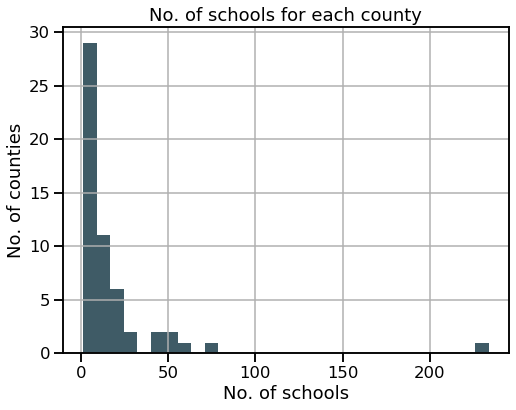

<IPython.core.display.Javascript object>

In [119]:
f, ax1 = plt.subplots(figsize=(8,6))
df_state_info_gs_census['County'].value_counts().hist(ax=ax1, bins=30, color=B_slate)
ax1.set_title('No. of schools for each county')
ax1.set_xlabel('No. of schools')
ax1.set_ylabel('No. of counties');

## Number of schools by district

In [104]:
print('No. of districts: ', len(df_state_info_gs_census['District'].unique()))

No. of districts:  378


<IPython.core.display.Javascript object>

In [105]:
df_state_info_gs_census['District'].value_counts()

Los Angeles Unified          114
San Diego Unified             23
East Side Union High          15
San Francisco Unified         13
Sweetwater Union High         12
                            ... 
Biggs Unified                  1
Milpitas Unified               1
Calexico Unified               1
Paso Robles Joint Unified      1
Ojai Unified                   1
Name: District, Length: 378, dtype: int64

<IPython.core.display.Javascript object>

In [867]:
df_state_info_gs_census['District'].value_counts().head(15)

Los Angeles Unified            114
San Diego Unified               23
East Side Union High            15
San Francisco Unified           13
Sweetwater Union High           12
Elk Grove Unified               10
Sacramento City Unified         10
Oakland Unified                 10
Grossmont Union High             9
Anaheim Union High               8
San Juan Unified                 8
Antelope Valley Union High       8
Chaffey Joint Union High         8
Modesto City High                7
San Bernardino City Unified      7
Name: District, dtype: int64

<IPython.core.display.Javascript object>

In [106]:
df_state_info_gs_census['District'].value_counts().median()

1.0

<IPython.core.display.Javascript object>

## Number of charters and magnets

In [873]:
df_state_info_gs_census['Charter_cat_encoded'].value_counts()

0    847
1    119
Name: Charter_cat_encoded, dtype: int64

<IPython.core.display.Javascript object>

In [872]:
df_state_info_gs_census['Charter_cat_encoded'].value_counts() / df_state_info_gs_census['Charter_cat_encoded'].count()

0    0.876812
1    0.123188
Name: Charter_cat_encoded, dtype: float64

<IPython.core.display.Javascript object>

In [869]:
df_state_info_gs_census['Charter_cat_encoded'].value_counts().sum()

966

<IPython.core.display.Javascript object>

In [874]:
df_state_info_gs_census['Magnet_cat_encoded'].value_counts()

0    867
1     99
Name: Magnet_cat_encoded, dtype: int64

<IPython.core.display.Javascript object>

In [875]:
df_state_info_gs_census['Magnet_cat_encoded'].value_counts()/ df_state_info_gs_census['Magnet_cat_encoded'].count()

0    0.897516
1    0.102484
Name: Magnet_cat_encoded, dtype: float64

<IPython.core.display.Javascript object>

In [876]:
((df_state_info_gs_census['Charter_cat_encoded']==1) & (df_state_info_gs_census['Magnet_cat_encoded']==1)).sum()

5

<IPython.core.display.Javascript object>

## Staff/teacher data

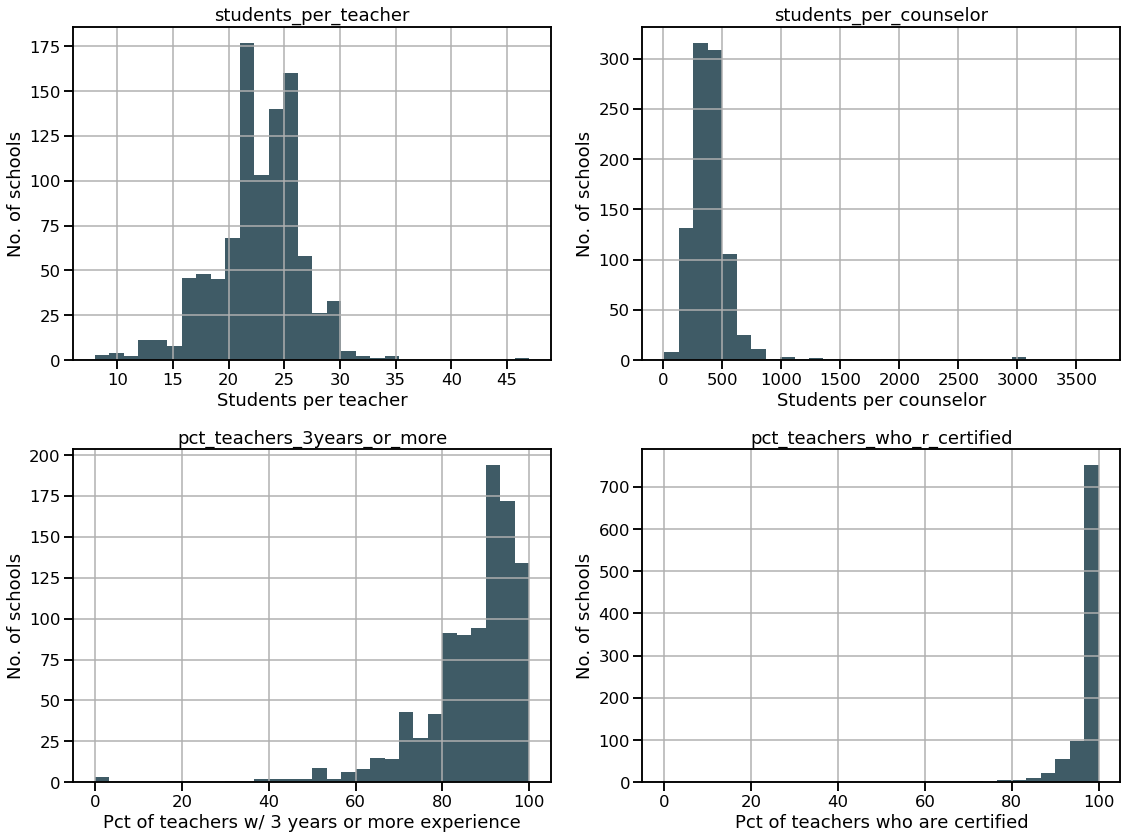

<IPython.core.display.Javascript object>

In [164]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,12))

hist_plot(df_state_info_gs_census, "students_per_teacher", ax1)
# labels = [i.get_text() for i in ax1.get_xticklabels()]   # can't figure this out
# ax1.set_xticklabels(labels, fontsize=14)
ax1.set_xlabel('Students per teacher')
ax1.set_ylabel('No. of schools')

hist_plot(df_state_info_gs_census, "students_per_counselor", ax2)
ax2.set_xlabel('Students per counselor')
ax2.set_ylabel('No. of schools')

hist_plot(df_state_info_gs_census, "pct_teachers_3years_or_more", ax3)
ax3.set_xlabel('Pct of teachers w/ 3 years or more experience')
ax3.set_ylabel('No. of schools')

hist_plot(df_state_info_gs_census, "pct_teachers_who_r_certified", ax4)
ax4.set_xlabel('Pct of teachers who are certified')
ax4.set_ylabel('No. of schools')

plt.tight_layout();

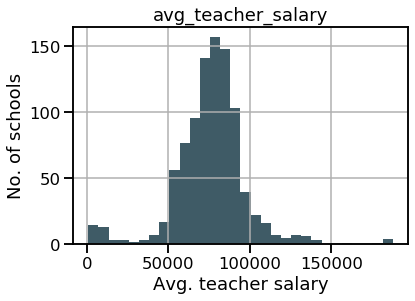

<IPython.core.display.Javascript object>

In [167]:
f, ax1 = plt.subplots(figsize=(6,4))
hist_plot(df_state_info_gs_census, "avg_teacher_salary", ax1)
ax1.set_xlabel('Avg. teacher salary')
ax1.set_ylabel('No. of schools');


## Test scores

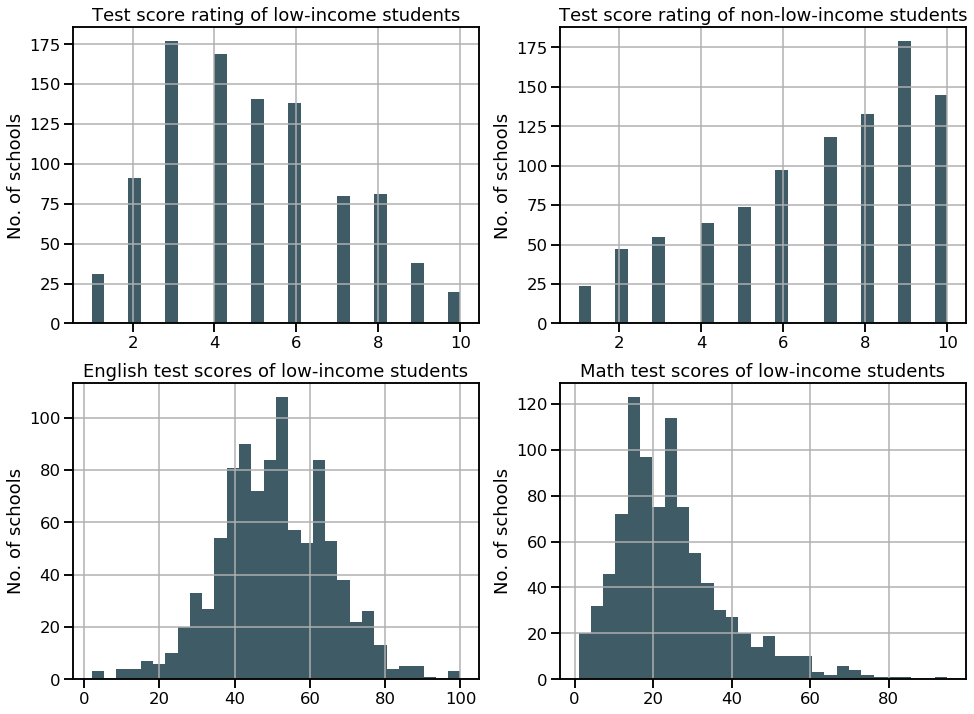

<IPython.core.display.Javascript object>

In [175]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

hist_plot(df_state_info_gs_census, "test_score_rating_LIstudents", ax1)
ax1.set_ylabel("No. of schools")
ax1.set_title("Test score rating of low-income students")
                                           
hist_plot(df_state_info_gs_census, "test_score_rating_notLIstudents", ax2)
ax2.set_ylabel("No. of schools")
ax2.set_title("Test score rating of non-low-income students")

hist_plot(df_state_info_gs_census, "test_scores_english_LIstudents", ax3)
ax3.set_ylabel("No. of schools")
ax3.set_title("English test scores of low-income students")
                                           
hist_plot(df_state_info_gs_census, "test_scores_math_LIstudents", ax4)
ax4.set_ylabel("No. of schools")
ax4.set_title("Math test scores of low-income students");

# Exploration of communities (zip-code level demographics)

**Industries**

Note: This was the feature I removed during feature selection due to multicollinearity.

'%; INDUSTRY - Civilian employed pop. 16 yrs and up - Arts, entertainment, and recreation, and accommodation and food services')

In [180]:
col_industry = ['%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining',
       '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Construction',
       '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Educational services, and health care and social assistance',
       '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Finance and insurance, and real estate and rental and leasing',
       '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Information',
       '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Manufacturing',
       '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Other services, except public administration',
       '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services',
       '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Public administration',
       '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Retail trade',
       '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Transportation and warehousing, and utilities',
       '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Wholesale trade']

<IPython.core.display.Javascript object>

In [195]:
df_state_info_gs_census[col_industry].median(axis=0).sort_values(ascending=False)

%; INDUSTRY - Civilian employed pop. 16 yrs and up - Educational services, and health care and social assistance                                   20.6
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Retail trade                                                                                  11.4
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services    10.6
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Manufacturing                                                                                  9.0
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Construction                                                                                   6.1
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Other services, except public administration                                                   5.3
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Finance and insurance, and real est

<IPython.core.display.Javascript object>

In [192]:
col_industry_simplenames, col_industry_simplenames_dict = create_simple_names('%; INDUSTRY - Civilian employed pop. 16 yrs and up - ', col_industry)


<IPython.core.display.Javascript object>

## First 50 schools, ordered by county name (with legend)

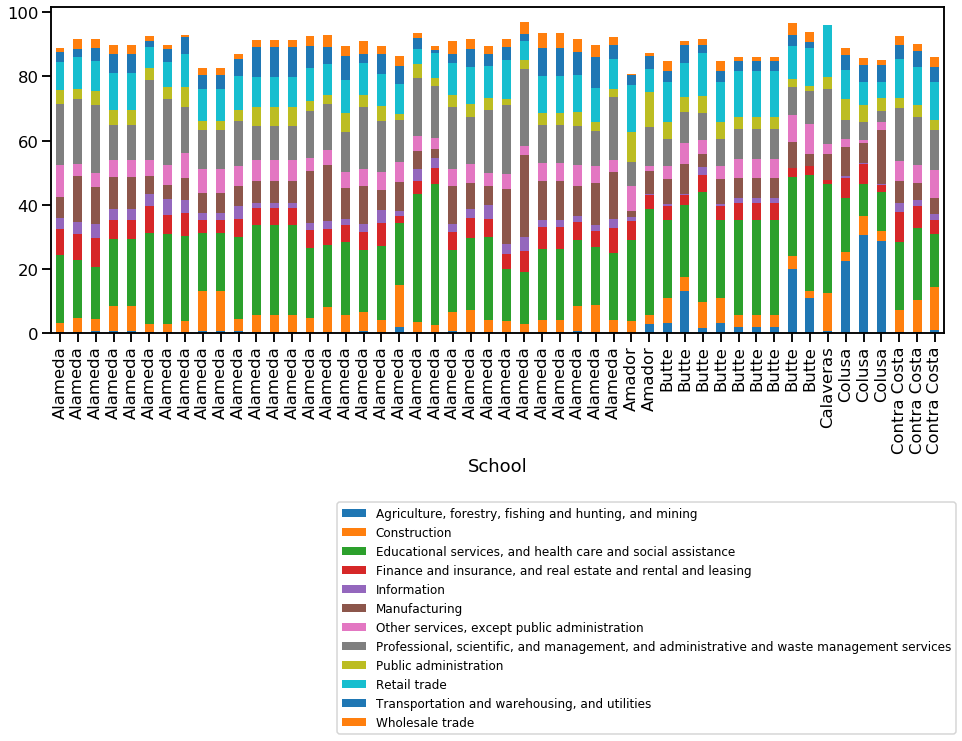

<IPython.core.display.Javascript object>

In [222]:
df_temp = df_state_info_gs_census.sort_values(by='County').iloc[0:50, :]
f, ax1 = plt.subplots(figsize=(16,6))
df_temp[['School'] +col_industry].set_index('School').plot(kind='bar', stacked=True, ax=ax1)
alt_labels = col_industry_simplenames
#ax1.legend(labels=alt_labels)
ax1.set_xticklabels(df_temp['County'])
ax1.legend(labels=alt_labels, bbox_to_anchor=(1.02, -0.5), loc='upper right', ncol=1, prop={'size':12});

## Next 100 schools, ordered by county name (no legend)

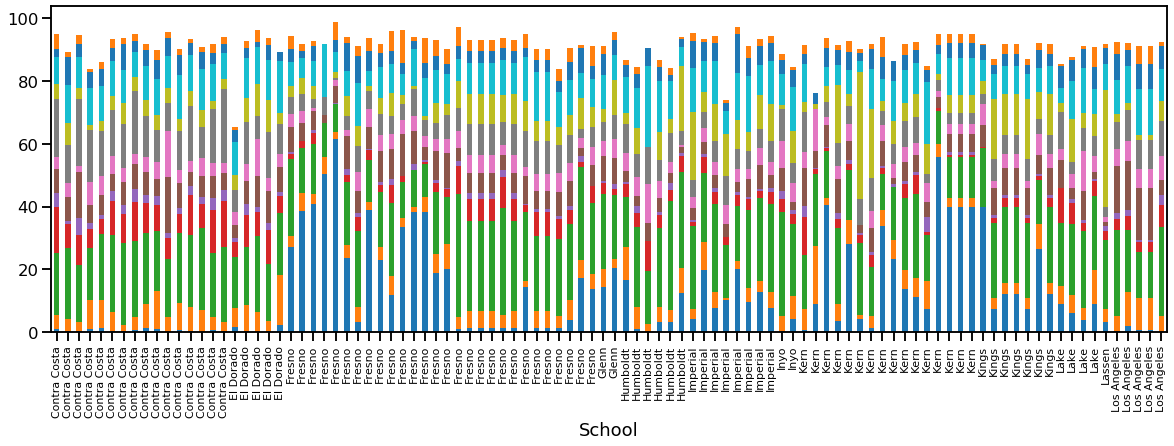

<IPython.core.display.Javascript object>

In [221]:
df_temp = df_state_info_gs_census.sort_values(by='County').iloc[50:150, :]
f, ax1 = plt.subplots(figsize=(20,6))
df_temp[['School'] +col_industry].set_index('School').plot(kind='bar', stacked=True, ax=ax1)
alt_labels = col_industry_simplenames
#ax1.legend(labels=alt_labels)
ax1.set_xticklabels(df_temp['County'], fontsize=11);
ax1.get_legend().remove()

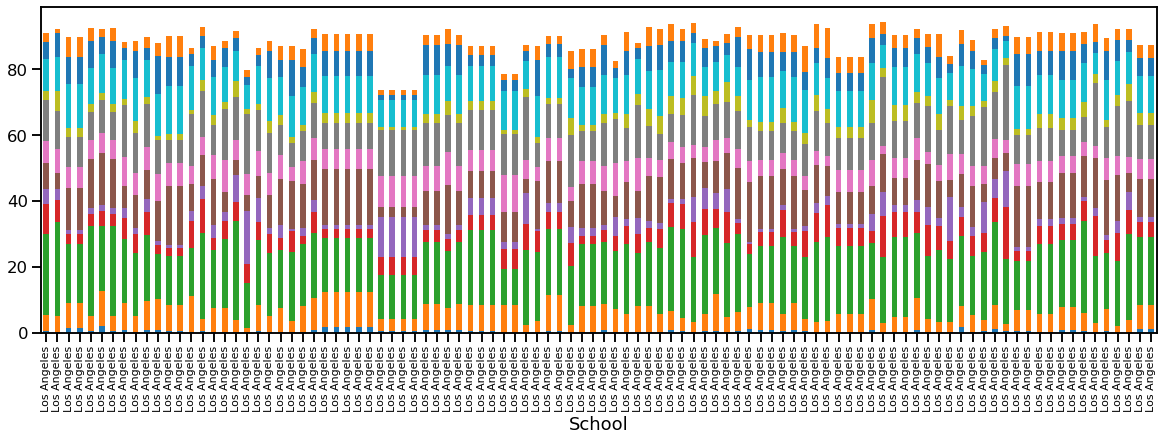

<IPython.core.display.Javascript object>

In [223]:
df_temp = df_state_info_gs_census.sort_values(by='County').iloc[150:250, :]
f, ax1 = plt.subplots(figsize=(20,6))
df_temp[['School'] +col_industry].set_index('School').plot(kind='bar', stacked=True, ax=ax1)
alt_labels = col_industry_simplenames
#ax1.legend(labels=alt_labels)
ax1.set_xticklabels(df_temp['County'], fontsize=11);
ax1.get_legend().remove()

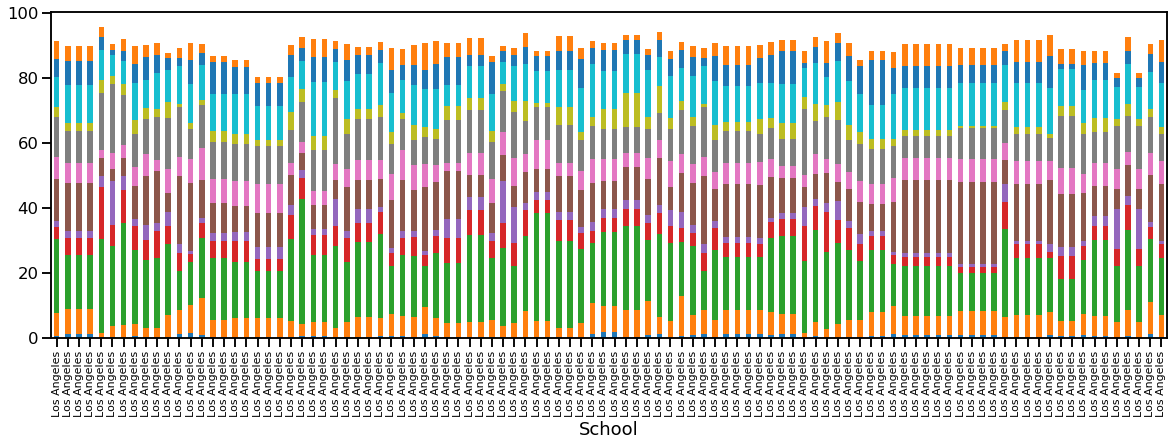

<IPython.core.display.Javascript object>

In [224]:
df_temp = df_state_info_gs_census.sort_values(by='County').iloc[250:350, :]
f, ax1 = plt.subplots(figsize=(20,6))
df_temp[['School'] +col_industry].set_index('School').plot(kind='bar', stacked=True, ax=ax1)
alt_labels = col_industry_simplenames
#ax1.legend(labels=alt_labels)
ax1.set_xticklabels(df_temp['County'], fontsize=11);
ax1.get_legend().remove()

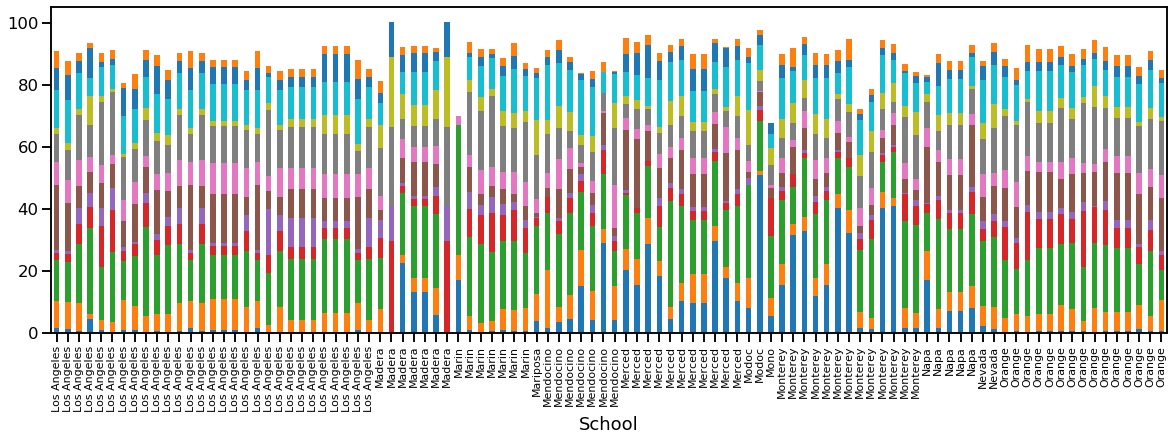

<IPython.core.display.Javascript object>

In [225]:
df_temp = df_state_info_gs_census.sort_values(by='County').iloc[350:450, :]
f, ax1 = plt.subplots(figsize=(20,6))
df_temp[['School'] +col_industry].set_index('School').plot(kind='bar', stacked=True, ax=ax1)
alt_labels = col_industry_simplenames
#ax1.legend(labels=alt_labels)
ax1.set_xticklabels(df_temp['County'], fontsize=11);
ax1.get_legend().remove()

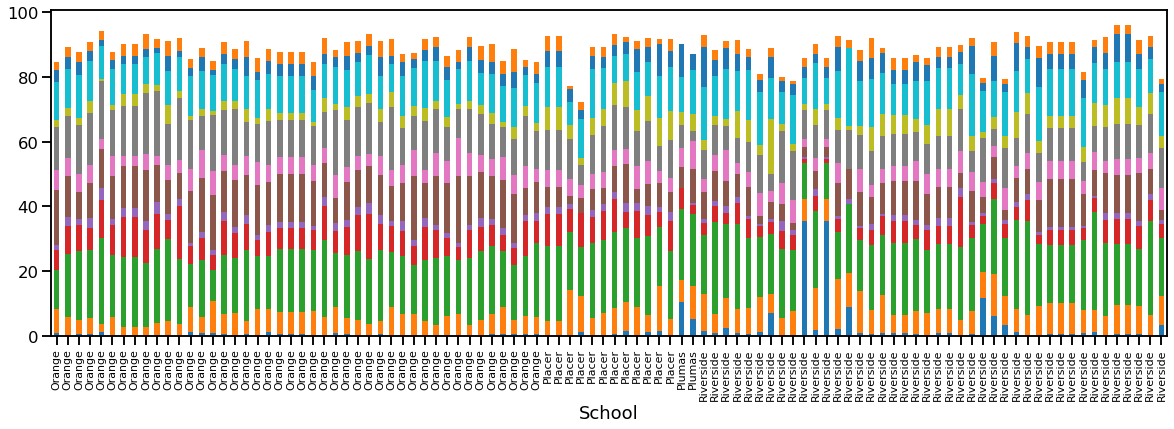

<IPython.core.display.Javascript object>

In [226]:
df_temp = df_state_info_gs_census.sort_values(by='County').iloc[450:550, :]
f, ax1 = plt.subplots(figsize=(20,6))
df_temp[['School'] +col_industry].set_index('School').plot(kind='bar', stacked=True, ax=ax1)
alt_labels = col_industry_simplenames
#ax1.legend(labels=alt_labels)
ax1.set_xticklabels(df_temp['County'], fontsize=11);
ax1.get_legend().remove()

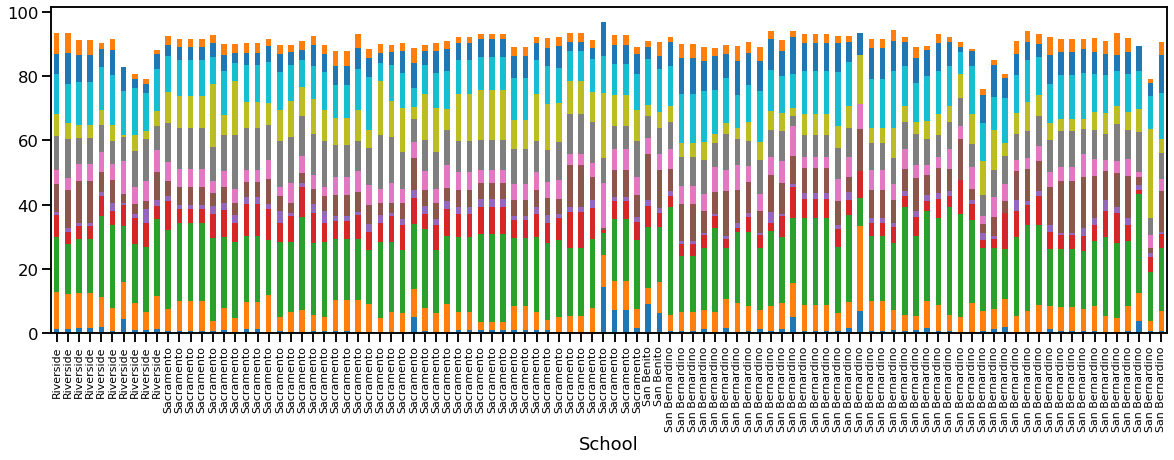

<IPython.core.display.Javascript object>

In [227]:
df_temp = df_state_info_gs_census.sort_values(by='County').iloc[550:650, :]
f, ax1 = plt.subplots(figsize=(20,6))
df_temp[['School'] +col_industry].set_index('School').plot(kind='bar', stacked=True, ax=ax1)
alt_labels = col_industry_simplenames
#ax1.legend(labels=alt_labels)
ax1.set_xticklabels(df_temp['County'], fontsize=11);
ax1.get_legend().remove()

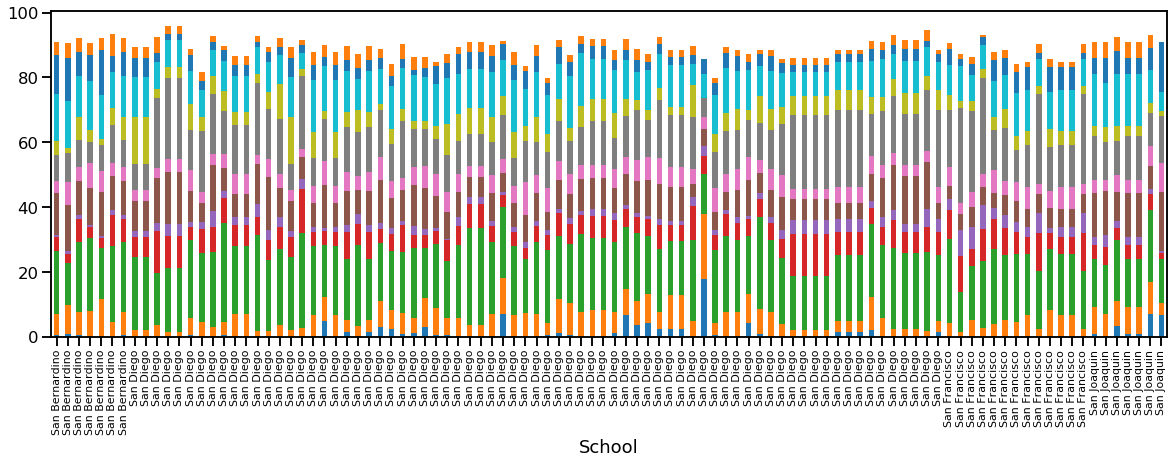

<IPython.core.display.Javascript object>

In [228]:
df_temp = df_state_info_gs_census.sort_values(by='County').iloc[650:750, :]
f, ax1 = plt.subplots(figsize=(20,6))
df_temp[['School'] +col_industry].set_index('School').plot(kind='bar', stacked=True, ax=ax1)
alt_labels = col_industry_simplenames
#ax1.legend(labels=alt_labels)
ax1.set_xticklabels(df_temp['County'], fontsize=11);
ax1.get_legend().remove()

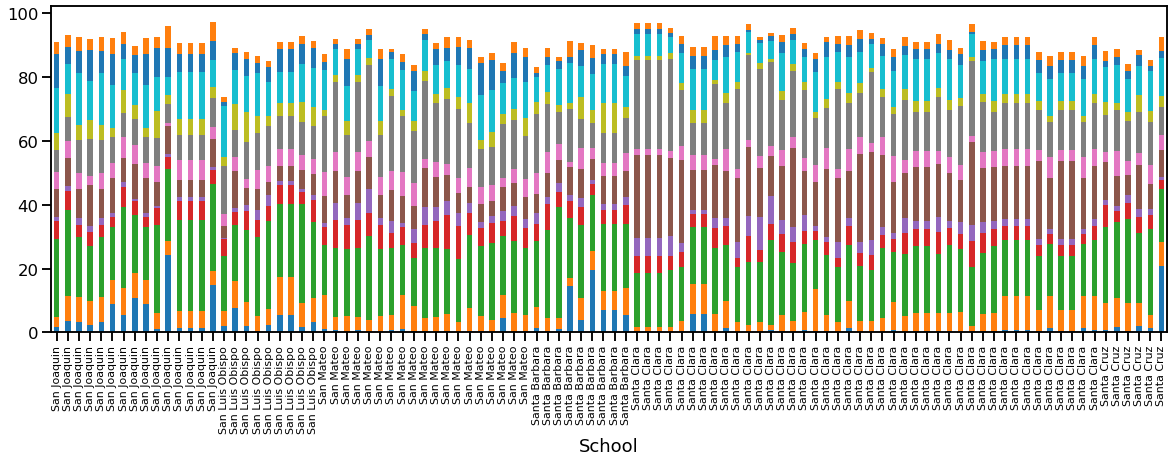

<IPython.core.display.Javascript object>

In [230]:
df_temp = df_state_info_gs_census.sort_values(by='County').iloc[750:850, :]
f, ax1 = plt.subplots(figsize=(20,6))
df_temp[['School'] +col_industry].set_index('School').plot(kind='bar', stacked=True, ax=ax1)
alt_labels = col_industry_simplenames
#ax1.legend(labels=alt_labels)
ax1.set_xticklabels(df_temp['County'], fontsize=11);
ax1.get_legend().remove()

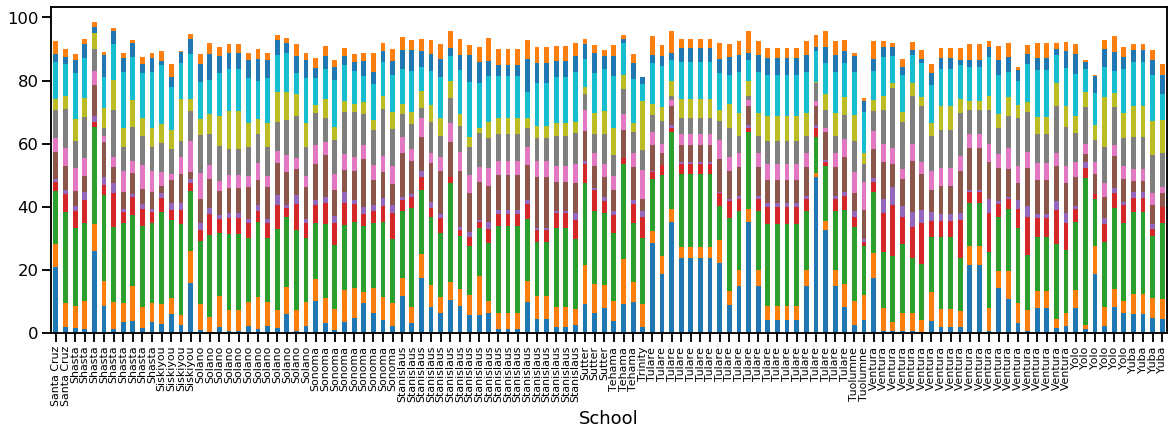

<IPython.core.display.Javascript object>

In [231]:
df_temp = df_state_info_gs_census.sort_values(by='County').iloc[850::, :]
f, ax1 = plt.subplots(figsize=(20,6))
df_temp[['School'] + col_industry].set_index('School').plot(kind='bar', stacked=True, ax=ax1)
alt_labels = col_industry_simplenames
#ax1.legend(labels=alt_labels)
ax1.set_xticklabels(df_temp['County'], fontsize=11);
ax1.get_legend().remove()

## Aggregate at the county level

In [235]:
# Verification of code
# df_state_info_gs_census[['School', 'County'] + col_industry].groupby('County').count()

<IPython.core.display.Javascript object>

In [246]:
df_temp_county = df_state_info_gs_census[['School', 'County'] + col_industry].groupby('County').mean()
df_temp_county.head()

%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining  \
County                                                                                                                   
Alameda                                             0.475000                                                             
Amador                                              1.350000                                                             
Butte                                               6.388889                                                             
Calaveras                                           0.800000                                                             
Colusa                                             27.200000                                                             

           %; INDUSTRY - Civilian employed pop. 16 yrs and up - Construction  \
County                                                                         
Alameda                                             5.475000                   
Amador                                              3.400000                   
Butte                                               5.133333                   
Calaveras                                          11.800000                   
Colusa                                              4.000000                   

           %; INDUSTRY - Civilian employed pop. 16 yrs and up - Educational services, and health care and social assistance  \
County                                                                                                                        
Alameda                                            23.096875                                                                  
Amador                                             29.050000                                                                  
Butte                                              28.333333                                                                  
Calaveras                                          33.800000                                                                  
Colusa                                             13.000000                                                                  

           %; INDUSTRY - Civilian employed pop. 16 yrs and up - Finance and insurance, and real estate and rental and leasing  \
County                                                                                                                          
Alameda                                             5.906250                                                                    
Amador                                              5.150000                                                                    
Butte                                               4.233333                                                                    
Calaveras                                           1.300000                                                                    
Colusa                                              4.833333                                                                    

           %; INDUSTRY - Civilian employed pop. 16 yrs and up - Information  \
County                                                                        
Alameda                                             2.940625                  
Amador                                              0.950000                  
Butte                                               0.988889                  
Calaveras                                           0.000000                  
Colusa                                              0.466667                  

           %; INDUSTRY - Civilian employed pop. 16 yrs and up - Manufacturing  \
County                                                                          
Alameda                                             9.900000                    
Amad

<IPython.core.display.Javascript object>

In [239]:
df_temp_county.median().sort_values(ascending=False)

%; INDUSTRY - Civilian employed pop. 16 yrs and up - Educational services, and health care and social assistance                                   21.900000
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Retail trade                                                                                  11.057143
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services     9.650000
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Manufacturing                                                                                  7.478947
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Construction                                                                                   6.225000
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Public administration                                                                          5.700000
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agric

<IPython.core.display.Javascript object>

In [241]:
col_industry_order_prevalence = df_temp_county.median().sort_values(ascending=False).index.tolist()
col_industry_order_prevalence

['%; INDUSTRY - Civilian employed pop. 16 yrs and up - Educational services, and health care and social assistance',
 '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Retail trade',
 '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services',
 '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Manufacturing',
 '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Construction',
 '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Public administration',
 '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining',
 '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Finance and insurance, and real estate and rental and leasing',
 '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Other services, except public administration',
 '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Transportation and warehousing, and utilities',
 '%; INDU

<IPython.core.display.Javascript object>

In [245]:
df_temp_county_ordered = df_temp_county[col_industry_order_prevalence].sort_values(by=col_industry_order_prevalence, ascending=False)
df_temp_county_ordered

%; INDUSTRY - Civilian employed pop. 16 yrs and up - Educational services, and health care and social assistance  \
County                                                                                                                              
Calaveras                                                33.800000                                                                  
Amador                                                   29.050000                                                                  
Butte                                                    28.333333                                                                  
Inyo                                                     28.050000                                                                  
Yolo                                                     25.700000                                                                  
Shasta                                                   25.666667                                                                  
Marin                                                    25.342857                                                                  
Siskiyou                                                 25.250000                                                                  
Humboldt                                                 24.766667                                                                  
Sutter                                                   24.033333                                                                  
Yuba                                                     23.875000                                                                  
Imperial                                                 23.650000                                                                  
Tehama                                                   23.466667                                                                  
San Luis Obispo                                          23.355556                                                                  
Santa Cruz                                               23.137500                                                                  
Alameda                                                  23.096875                                                                  
Modoc                                                    22.900000                                                                  
Solano                                                   22.700000                                                                  
Lake                                                     22.675000                                                                  
Santa Barbara                                            22.666667                                                                  
San Bernardino                                           22.248077                                                                  
Stanislaus                                               22.152632                                                                  
Plumas                                                   22.050000                                                                  
Glenn                                                    22.050000                                                                  
Sacramento                                               22.020930                                                                  
Lassen                                                   22.000000                                                                  
Mariposa                                                 21.900000                                                                  
Nevada                                                   21.900000                                                                  
Kings                      

<IPython.core.display.Javascript object>

In [323]:
df_temp_county[col_industry_order_prevalence].std()

%; INDUSTRY - Civilian employed pop. 16 yrs and up - Educational services, and health care and social assistance                                   3.331504
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Retail trade                                                                                  2.211686
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services    3.762594
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Manufacturing                                                                                 3.280219
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Construction                                                                                  1.688900
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Public administration                                                                         5.018402
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture

<IPython.core.display.Javascript object>

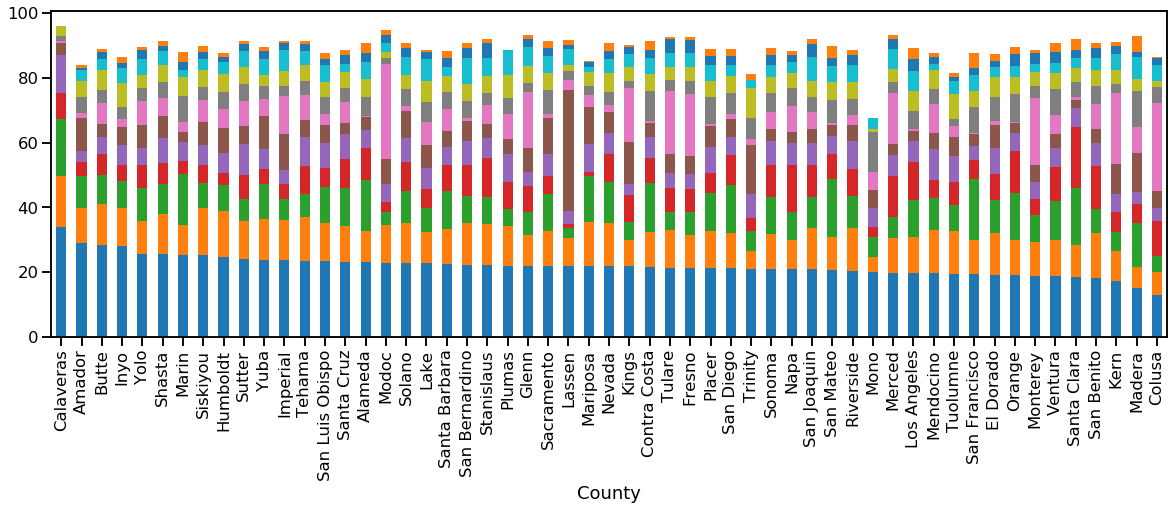

<IPython.core.display.Javascript object>

In [250]:
f, ax1 = plt.subplots(figsize=(20,6))
df_temp_county_ordered.plot(kind='bar', stacked=True, ax=ax1)
alt_labels = col_industry_simplenames
#ax1.legend(labels=alt_labels)
#ax1.set_xticklabels(df_temp['County'], fontsize=11);
ax1.get_legend().remove()

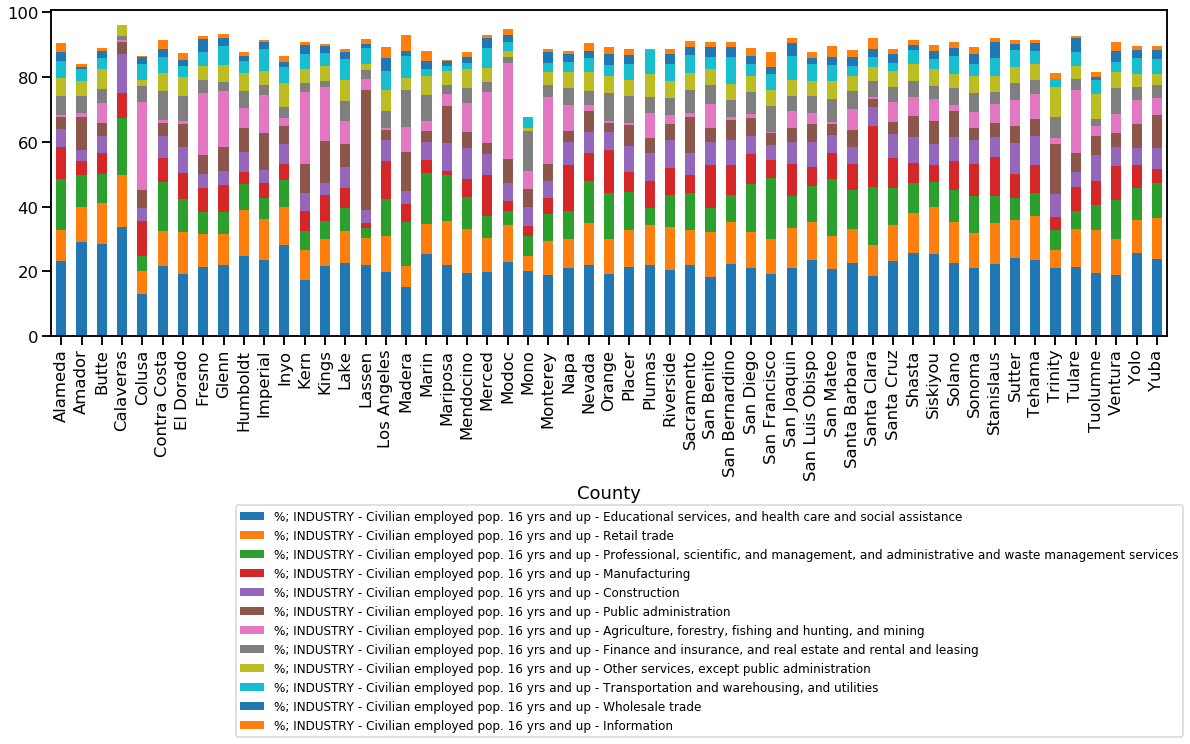

<IPython.core.display.Javascript object>

In [889]:
f, ax1 = plt.subplots(figsize=(20,6))
df_temp_county[col_industry_order_prevalence].plot(kind='bar', stacked=True, ax=ax1)
#alt_labels = col_industry_simplenames
#ax1.legend(labels=alt_labels)
#ax1.set_xticklabels(df_temp['County'], fontsize=11);
#ax1.get_legend().remove()
ax1.legend(bbox_to_anchor=(1.02, -0.5), loc='upper right', ncol=1, prop={'size':12});

# Bivariate feature exploration

## Local income vs. average teacher salary

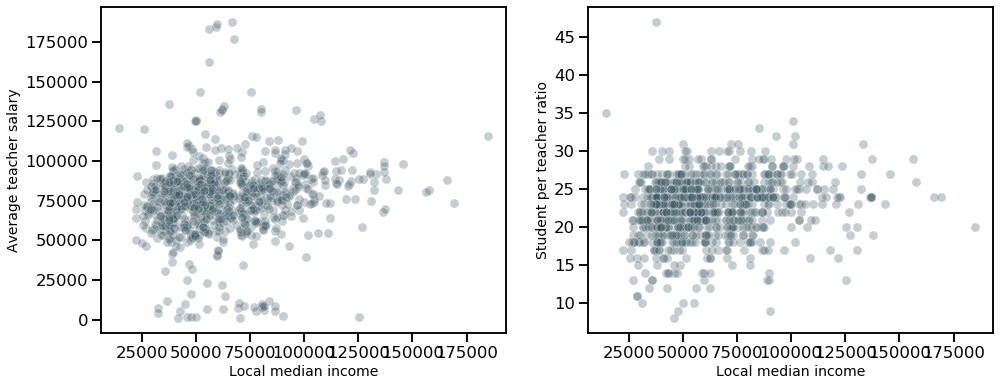

<IPython.core.display.Javascript object>

In [892]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(
    data=df_state_info_gs_census,
    x="Est.; INCOME_BENEFITS - Total households - Median household income ($)",
    y="avg_teacher_salary",
    ax=ax1,
    alpha=0.3,
    color=B_slate,
    legend=False,
)
ax1.set_xlabel(
    "Local median income", fontsize=14
)
ax1.set_ylabel("Average teacher salary", fontsize=14);

sns.scatterplot(
    data=df_state_info_gs_census,
    x="Est.; INCOME_BENEFITS - Total households - Median household income ($)",
    y="students_per_teacher",
    ax=ax2,
    alpha=0.3,
    color=B_slate,
    legend=False,
)
ax2.set_xlabel(
    "Local median income", fontsize=14
)
ax2.set_ylabel("Student per teacher ratio", fontsize=14);

In [890]:
df_state_info_gs_census.columns[df_state_info_gs_census.columns.str.contains('teacher')]

Index(['students_per_teacher', 'pct_teachers_3years_or_more',
       'pct_teachers_who_r_certified', 'avg_teacher_salary'],
      dtype='object')

<IPython.core.display.Javascript object>

# Evaluation of target

In [33]:
n_schools_notarget = df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"].isna().sum()
print('No. of schools without a value for SPLICE: {0:d}'.format(n_schools_notarget))

No. of schools without a value for SPLICE: 13


<IPython.core.display.Javascript object>

In [29]:
# f, ax1 = plt.subplots(figsize=(8,6))
# sns.distplot(a=df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"].dropna())
# ax1.set_ylabel("No. of schools", fontsize=16)
# ax1.set_title("SPLICE", fontsize=14);

<IPython.core.display.Javascript object>

In [63]:
target = df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"]
target_mean = target.mean()
target_sd = target.std()

<IPython.core.display.Javascript object>

mean: 47.0
mean +/- 1SD: 27.2 +/- 66.8
mean +/- 2SD: 7.4 +/- 86.6


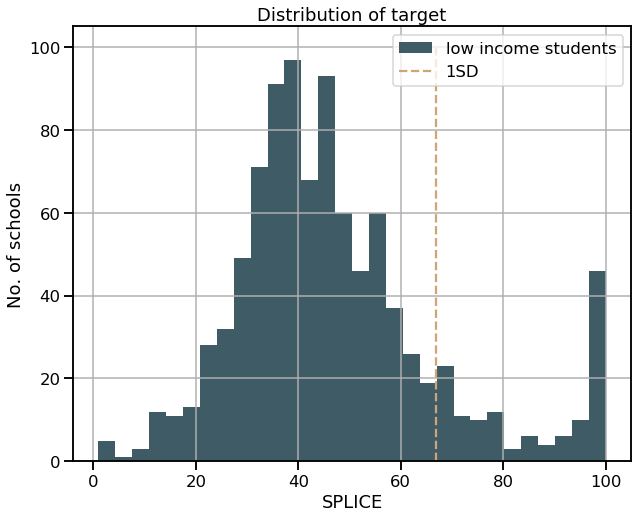

<IPython.core.display.Javascript object>

In [850]:
f, ax1 = plt.subplots(figsize=(10, 8))
df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"].hist(
    bins=30, ax=ax1, color=B_slate, label="low income students"
)

# ax1.vlines([target_mean - target_sd, target_mean + target_sd], ymin=0, ymax=df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"].max(), colors=B_beige, linestyle="dashed", label='1SD')
ax1.vlines([target_mean + target_sd], ymin=0, ymax=df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"].max(), colors=B_beige, linestyle="dashed", label='1SD')
# ax1.vlines([target_mean - 2*target_sd, target_mean + 2*target_sd], ymin=0, ymax=df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"].max(), colors=B_green, linestyle="dashed", label='2SD')
ax1.set_title("Distribution of target")
ax1.set_xlabel("SPLICE")
ax1.set_ylabel("No. of schools")
ax1.legend()

print("mean: {0:0.1f}".format(target_mean))
print("mean +/- 1SD: {0:0.1f} +/- {1:0.1f}".format(target_mean - target_sd, target_mean + target_sd))
print("mean +/- 2SD: {0:0.1f} +/- {1:0.1f}".format(target_mean - 2*target_sd, target_mean + 2*target_sd))

plt.savefig(figure_loc + 'SPLICE_target_distribution.png')

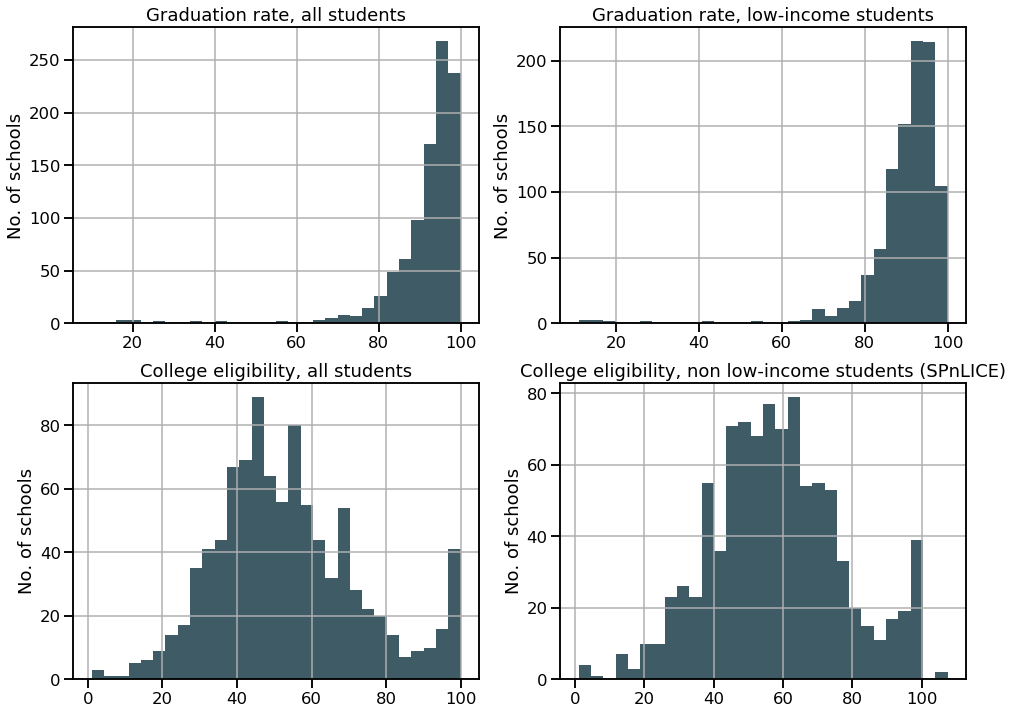

<IPython.core.display.Javascript object>

In [173]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

hist_plot(df_state_info_gs_census, "graduation_rates_gradRates_eligibility_allStudents", ax1)
ax1.set_ylabel("No. of schools")
ax1.set_title("Graduation rate, all students")
                                           
hist_plot(df_state_info_gs_census, "graduation_rates_gradRates_eligibility_LIstudents", ax2)
ax2.set_ylabel("No. of schools")
ax2.set_title("Graduation rate, low-income students")

hist_plot(df_state_info_gs_census, "graduation_rates_UCCSU_eligibility_allStudents", ax3)
ax3.set_ylabel("No. of schools")
ax3.set_title("College eligibility, all students")
                                           
hist_plot(df_state_info_gs_census, "graduation_rates_UCCSU_eligibility_nonLIstudents", ax4)
ax4.set_ylabel("No. of schools")
ax4.set_title("College eligibility, non low-income students (SPnLICE)");

## Assessment of features against target


### Percent low income and enrollment 

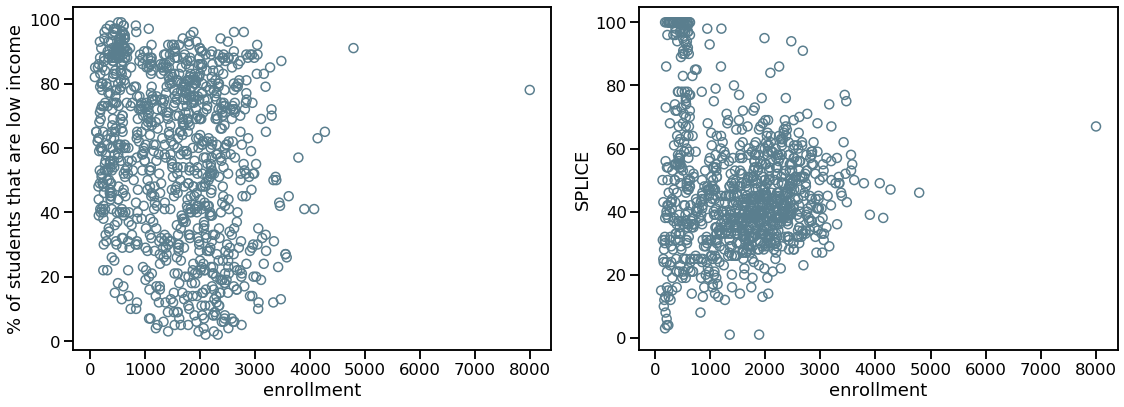

<IPython.core.display.Javascript object>

In [76]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
scatter_plot_open_circles(df_state_info_gs_census, "enrollment", "pct_LI_students", ax1)

scatter_plot_open_circles(
    df_state_info_gs_census,
    "enrollment",
    "graduation_rates_UCCSU_eligibility_LIstudents",
    ax2,
)

ax1.set_xlabel("enrollment") #, fontsize=18)
ax1.set_ylabel("% of students that are low income") #, fontsize=18)
ax2.set_xlabel("enrollment") #, fontsize=18)
ax2.set_ylabel("SPLICE") #, fontsize=18)
plt.tight_layout()

## Exploration of SPLICE and most correlated features with SPLICE

See feature confirmation notebook also.

In [77]:
df_state_info_gs_census[
    "graduation_rates_UCCSU_eligibility_allStudents"
] * df_state_info_gs_census["pct_LI_students"] / 100

0       67.00
1       11.88
3       80.00
4       10.71
5       18.48
        ...  
1105    26.46
1106    26.04
1107    29.48
1108    20.46
1109    19.24
Length: 966, dtype: float64

<IPython.core.display.Javascript object>

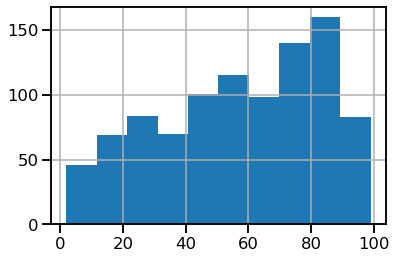

<IPython.core.display.Javascript object>

In [78]:
df_state_info_gs_census["pct_LI_students"].hist()

''

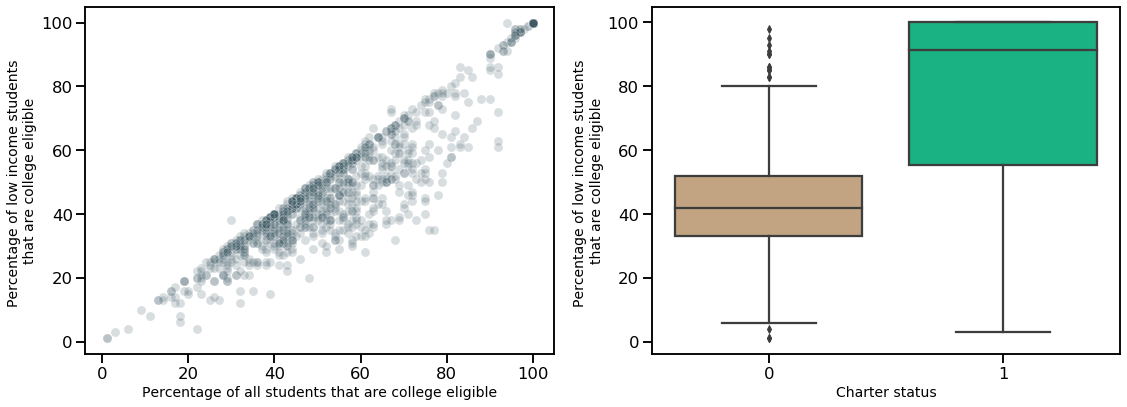

<IPython.core.display.Javascript object>

In [79]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(
    data=df_state_info_gs_census,
    x="graduation_rates_UCCSU_eligibility_allStudents",
    y="graduation_rates_UCCSU_eligibility_LIstudents",
    ax=ax1,
    alpha=0.2,
    color=B_slate,
    legend=False,
)
ax1.set_xlabel("Percentage of all students that are college eligible", fontsize=14)
ax1.set_ylabel(
    "Percentage of low income students \nthat are college eligible", fontsize=14
)


sns.boxplot(
    data=df_state_info_gs_census,
    x="Charter_cat_encoded",
    y="graduation_rates_UCCSU_eligibility_LIstudents",
    palette=[B_beige, B_green],
)
ax2.set_xlabel("Charter status", fontsize=14)
ax2.set_ylabel(
    "Percentage of low income students \nthat are college eligible", fontsize=14
)
plt.tight_layout()
;

In [80]:
df_state_info_gs_census.columns[df_state_info_gs_census.columns.str.contains("income")]

Index(['Est.; INCOME_BENEFITS - Total households - Median household income ($)',
       'Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)',
       'Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)'],
      dtype='object')

<IPython.core.display.Javascript object>

''

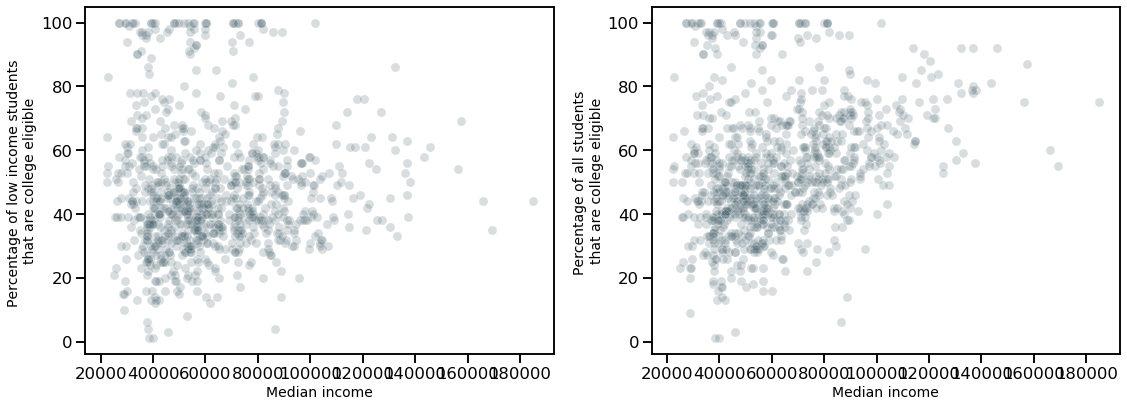

<IPython.core.display.Javascript object>

In [81]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
# scatter_plot_open_circles(
#     df_state_info_gs_census,
#     "graduation_rates_UCCSU_eligibility_allStudents",
#     "graduation_rates_UCCSU_eligibility_LIstudents",
#     ax1,
# )

sns.scatterplot(
    data=df_state_info_gs_census,
    x="Est.; INCOME_BENEFITS - Total households - Median household income ($)",
    y="graduation_rates_UCCSU_eligibility_LIstudents",
    ax=ax1,
    alpha=0.2,
    color=B_slate,
    legend=False,
)
ax1.set_xlabel("Median income", fontsize=14)
ax1.set_ylabel(
    "Percentage of low income students \nthat are college eligible", fontsize=14
)


sns.scatterplot(
    data=df_state_info_gs_census,
    x="Est.; INCOME_BENEFITS - Total households - Median household income ($)",
    y="graduation_rates_UCCSU_eligibility_allStudents",
    ax=ax2,
    alpha=0.2,
    color=B_slate,
    legend=False,
)
ax2.set_xlabel("Median income", fontsize=14)
ax2.set_ylabel("Percentage of all students \nthat are college eligible", fontsize=14)

plt.tight_layout()
;

In [82]:
df_state_info_gs_census["Charter_cat_encoded"].sum()

119

<IPython.core.display.Javascript object>

## Exploration of gap and features correlated with gap

KeyError: 'nonLI-LI_UCCSU_eligibility_gap'

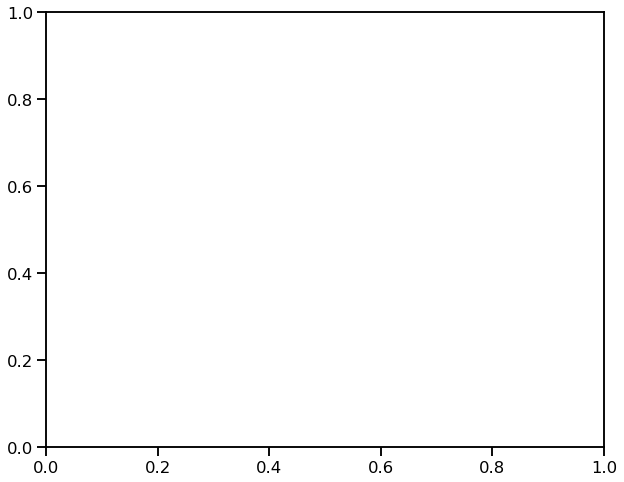

<IPython.core.display.Javascript object>

In [846]:
f, ax1 = plt.subplots(figsize=(10, 8))
df_state_info_gs_census["nonLI-LI_UCCSU_eligibility_gap"].hist(
    bins=30, ax=ax1, color=B_beige, alpha=0.5
)
# df_state_info_gs_census["graduation_rates_UCCSU_eligibility_allStudents"].hist(
#     bins=30, ax=ax1, color=B_green, alpha=0.5, label="all students"
# )

# ax1.axvline(67.4, c="gray", linestyle="dashed")
ax1.set_title("Distribution of achievement gap")
ax1.set_xlabel("Difference in percentage points", fontsize=16)
ax1.set_ylabel("No. of schools", fontsize=16)
# ax1.legend()

target = df_state_info_gs_census["nonLI-LI_UCCSU_eligibility_gap"]
target_mean = target.mean()
target_sd = target.std()

print("mean: ", target_mean)
print("mean +/- 1SD: ", target_mean - target_sd, target_mean + target_sd)
print("mean + 2SD: ", target_mean - 2 * target_sd, target_mean + 2 * target_sd)

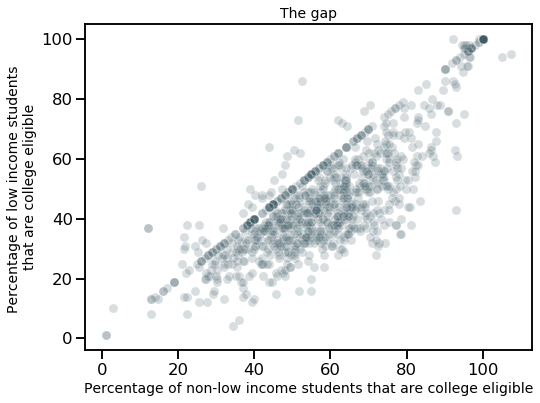

<IPython.core.display.Javascript object>

In [393]:
f, (ax1) = plt.subplots(1, 1, figsize=(8, 6))

sns.scatterplot(
    data=df_state_info_gs_census,
    x="graduation_rates_UCCSU_eligibility_nonLIstudents",
    y="graduation_rates_UCCSU_eligibility_LIstudents",
    ax=ax1,
    alpha=0.2,
    color=B_slate,
    legend=False,
)

ax1.axabline(
    
)


ax1.set_xlabel(
    "Percentage of non-low income students that are college eligible", fontsize=14
)
ax1.set_ylabel(
    "Percentage of low income students \nthat are college eligible", fontsize=14
)
ax1.set_title(
    "The gap", fontsize=14
);


# Geographic data

In [12]:
import geopandas
import fiona
from mpl_toolkits.axes_grid1 import make_axes_locatable

<IPython.core.display.Javascript object>

## School point dataset based on longitude and latitude

https://towardsdatascience.com/easy-steps-to-plot-geographic-data-on-a-map-python-11217859a2db

In [13]:
df_state_info_gs_census[['School', 'County', 'Latitude', 'Longitude']].head()

School   County   Latitude  Longitude
0  Envision Academy for Arts & Technology  Alameda  37.804520 -122.26815
1                            Alameda High  Alameda  37.764958 -122.24593
3       Lighthouse Community Charter High  Alameda  37.737050 -122.19663
4                             Albany High  Alameda  37.896661 -122.29257
5                           Berkeley High  Alameda  37.868913 -122.27120

<IPython.core.display.Javascript object>

In [14]:
# Update data formatting of latitude and longitude
df_state_info_gs_census["Latitude"].replace("No Data", None, inplace=True)
df_state_info_gs_census["Latitude"] = pd.to_numeric(df_state_info_gs_census["Latitude"])

df_state_info_gs_census["Longitude"].replace("No Data", None, inplace=True)
df_state_info_gs_census["Longitude"] = pd.to_numeric(
    df_state_info_gs_census["Longitude"]
)

<IPython.core.display.Javascript object>

In [15]:
df_wgeo = df_state_info_gs_census[
    (df_state_info_gs_census["Latitude"] != "No Data")
    | (df_state_info_gs_census["Longitude"] != "No Data")
].copy()

df_wgeo["Latitude"] = pd.to_numeric(df_wgeo["Latitude"])
df_wgeo["Longitude"] = pd.to_numeric(df_wgeo["Longitude"])

df_wgeo["graduation_rates_UCCSU_eligibility_LIstudents"] = pd.to_numeric(df_wgeo["graduation_rates_UCCSU_eligibility_LIstudents"])

/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


<IPython.core.display.Javascript object>

In [16]:
df_wgeo.head()

NCESDist  NCESSchool  NCESDistSchool StatusType   County  \
0    691051       10947     69105110947     Active  Alameda   
1    601770          41     60177000041     Active  Alameda   
3    628050       10726     62805010726     Active  Alameda   
4    601860          59     60186000059     Active  Alameda   
5    604740         432     60474000432     Active  Alameda   

                             District                                  School  \
0  Alameda County Office of Education  Envision Academy for Arts & Technology   
1                     Alameda Unified                            Alameda High   
3                     Oakland Unified       Lighthouse Community Charter High   
4                 Albany City Unified                             Albany High   
5                    Berkeley Unified                           Berkeley High   

                    Street            StreetAbr      City  ...  \
0      1515 Webster Street     1515 Webster St.   Oakland  ...   
1      2200 Central Avenue    2200 Central Ave.   Alameda  ...   
3     444 Hegenberger Road  444 Hegenberger Rd.   Oakland  ...   
4  603 Key Route Boulevard  603 Key Route Blvd.    Albany  ...   
5         1980 Allston Way     1980 Allston Way  Berkeley  ...   

  test_score_rating_LIstudents  test_score_rating_notLIstudents  \
0                          4.0                              4.0   
1                          8.0                             10.0   
3                          7.0                              7.0   
4                          8.0                             10.0   
5                          5.0                             10.0   

  test_scores_english_LIstudents  test_scores_math_LIstudents  \
0                           47.0                         18.0   
1                           64.0                         49.0   
3                           63.0                          NaN   
4                           66.0                         45.0   
5                           45.0                         27.0   

   test_scores_math_LIstudents_n_students  \
0                                    77.0   
1                                   104.0   
3                                     NaN   
4                                    55.0   
5                                   172.0   

   graduation_rates_gradRates_eligibility_allStudents  \
0                                               82.0    
1                                               95.0    
3                                               75.0    
4                                               93.0    
5                                               89.0    

   graduation_rates_gradRates_eligibility_LIstudents  \
0                                               83.0   
1                                               94.0   
3                                               77.0   
4                                               92.0   
5                                               89.0   

   graduation_rates_UCCSU_eligibility_allStudents  \
0                                           100.0   
1                                            66.0   
3                                           100.0   
4                                            63.0   
5                                            66.0   

   graduation_rates_UCCSU_eligibility_nonLIstudents  \
0                                        100.000000   
1                                         69.512195   
3                                        100.000000   
4                                         66.686747   
5                                         72.222222   

   graduation_rates_UCCSU_eligibility_LIstudents  
0                                          100.0  
1                                           50.0  
3                                          100.0  
4                                           45.0  
5                                           50.0  

[5 rows x 70 columns]

<IPython.core.display.Javascript object>

## With geopandas
- basemap looks old
- helpful [link](https://medium.com/@minaienick/why-you-should-be-using-geopandas-to-visualize-data-on-maps-aka-geo-visualization-fd1e3b6211b4)
- conda install --name insight geopandas shapely fiona pyproj rtree six descartes mapclassify

also consider: https://github.com/jupyter-widgets/ipyleaflet


In [43]:
# world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
# world.head()
# world.plot()

<IPython.core.display.Javascript object>

In [44]:
# File from http://geojson.xyz/

url = "https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_admin_1_states_provinces_shp.geojson"
df_states = geopandas.read_file(url)

df_CA = df_states[df_states["name"] == "California"]
df_CA.head()

scalerank adm1_code  diss_me adm1_cod_1 iso_3166_2  \
7          2  USA-3521     3521   USA-3521      US-CA   

                                 wikipedia sr_sov_a3 sr_adm0_a3 iso_a2  \
7  http://en.wikipedia.org/wiki/California       US1        USA     US   

   adm0_sr  ...  area_sqkm sameascity labelrank          featurec_1  \
7        8  ...          0        -99         0  Admin-1 scale rank   

                      admin name_len mapcolor9 mapcolor13        featureclass  \
7  United States of America       10         1          1  Admin-1 scale rank   

                                            geometry  
7  POLYGON ((-114.35490 34.46467, -114.16597 34.2...  

[1 rows x 41 columns]

<IPython.core.display.Javascript object>

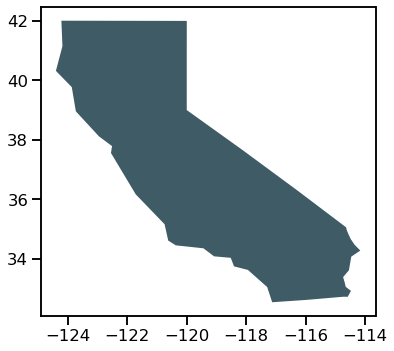

<IPython.core.display.Javascript object>

In [45]:
f, ax1 = plt.subplots(figsize=(6, 6))
df_CA.plot(ax=ax1, color=B_slate);

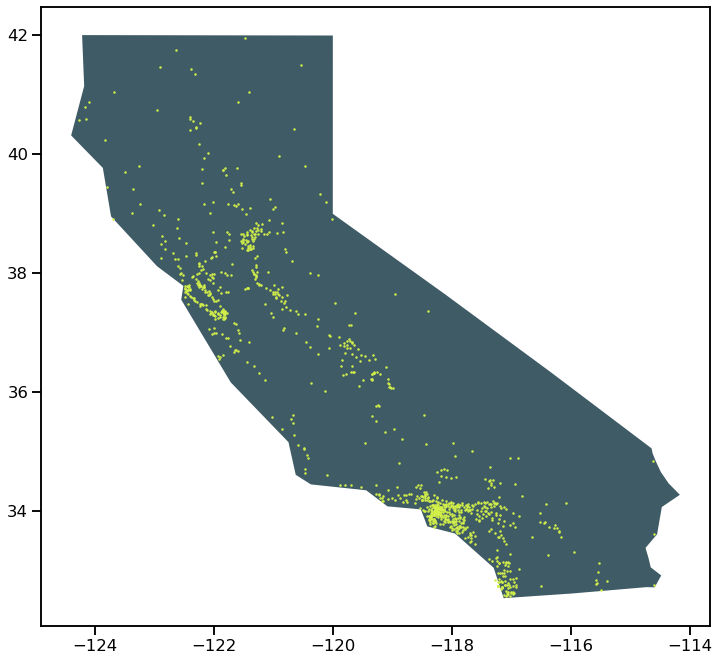

<IPython.core.display.Javascript object>

In [46]:
f, ax1 = plt.subplots(figsize=(12, 12))
df_CA.plot(ax=ax1, color=B_slate)
ax1.scatter(pd.to_numeric(df_wgeo["Longitude"]), pd.to_numeric(df_wgeo["Latitude"]), c=B_lime, s=2**0);


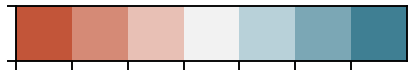

<IPython.core.display.Javascript object>

In [47]:
sns.palplot(sns.diverging_palette(20, 220, n=7))

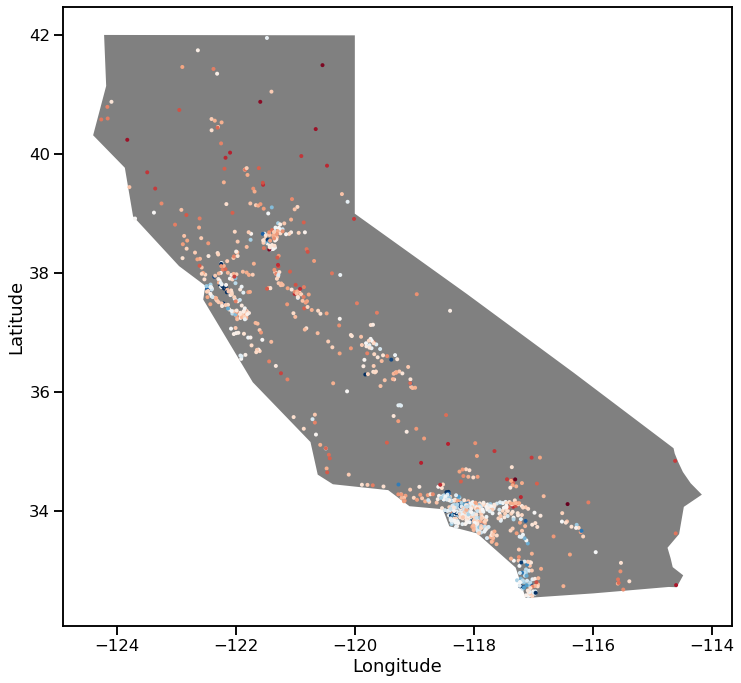

<IPython.core.display.Javascript object>

In [48]:
f, ax1 = plt.subplots(figsize=(12, 12))
df_CA.plot(ax=ax1, color='gray')
# ax1.scatter(pd.to_numeric(df_wgeo["Longitude"]), pd.to_numeric(df_wgeo["Latitude"]), c=pd.to_numeric(df_wgeo["Latitude"], s=2**0)
g = sns.scatterplot(
    data=df_wgeo,
    x="Longitude",
    y="Latitude",
    #palette="coolwarm",
    palette="RdBu",
    #palette=sns.choose_diverging_palette,
    hue="graduation_rates_UCCSU_eligibility_LIstudents",
    s=2 ** 4,
    ax=ax1,
    legend=None,
    #legend='brief',
    linewidth=0
)

#g._legend.set_title('SPLICE');


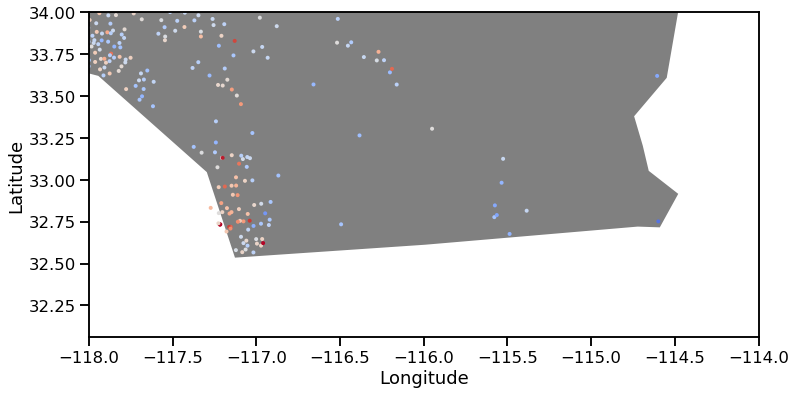

<IPython.core.display.Javascript object>

In [49]:
f, ax1 = plt.subplots(figsize=(12, 12))
df_CA.plot(ax=ax1, color='gray')
# ax1.scatter(pd.to_numeric(df_wgeo["Longitude"]), pd.to_numeric(df_wgeo["Latitude"]), c=pd.to_numeric(df_wgeo["Latitude"], s=2**0)
g = sns.scatterplot(
    data=df_wgeo,
    x="Longitude",
    y="Latitude",
    palette="coolwarm",
    hue="graduation_rates_UCCSU_eligibility_LIstudents",
    s=2 ** 4,
    ax=ax1,
    legend=None,
    #legend='brief',
    linewidth=0
)

#g._legend.set_title('SPLICE')

ax1.set_xlim([-118, -114])
ax1.set_ylim([None, 34]);


### Adding zip code boundaries

geojson file?
https://catalog.data.gov/dataset/zip-codetabilation-area-boundaries/resource/ea476dcb-4846-4242-9fb3-d41afb13bf52


shape file
https://earthworks.stanford.edu/catalog/stanford-dc841dq9031

In [50]:
from shapely.geometry import Point, Polygon

<IPython.core.display.Javascript object>

In [51]:
zip_shapefile_loc = "data/references/geojson_zc_data/ZCTA2010.shp"
zip_shapefile = geopandas.read_file(zip_shapefile_loc)
zip_shapefile.head()

OBJECTID CNTY_FIPS COUNTY TRACT TRACT_ID CENSUS_KEY   ZCTA ZCTA_KEY  \
0         1      None   None  None     None       None  94601  0694601   
1         2      None   None  None     None       None  94501  0694501   
2         3      None   None  None     None       None  94560  0694560   
3         4      None   None  None     None       None  94587  0694587   
4         5      None   None  None     None       None  94580  0694580   

    LATITUDE   LONGITUDE  ...  HU_VAC  HU_VAC_REN  HU_VAC_SEA  HU_OCC_OWN  \
0  37.776711 -122.218378  ...    1536         839          28        4764   
1  37.774084 -122.278049  ...    2062         885         189       10286   
2  37.520360 -122.031000  ...     442         170          17        8942   
3  37.603151 -122.018626  ...     825         384          39       13580   
4  37.676958 -122.133606  ...     334         116          15        6105   

   HU_OCC_O_1  HU_OCC_REN  HU_OCC_R_1    Shape_area     Shape_len  \
0       16528       10062       32927  8.721649e+06  15265.093880   
1       26023       14739       32705  2.954478e+07  27119.154912   
2       28489        4030       13939  3.581839e+07  30752.336176   
3       46272        6853       22726  5.107510e+07  53110.314427   
4       18760        2519        8252  8.946896e+06  20260.685185   

                                            geometry  
0  POLYGON ((-195843.682 -22645.035, -195822.040 ...  
1  POLYGON ((-201604.187 -25728.139, -202894.954 ...  
2  POLYGON ((-181289.671 -49924.408, -181237.554 ...  
3  POLYGON ((-182052.317 -43764.050, -182037.584 ...  
4  POLYGON ((-187567.889 -34790.577, -187565.018 ...  

[5 rows x 86 columns]

<IPython.core.display.Javascript object>

In [52]:
# Create zipshape file that has some labels, to be used in some cases

zip_shapefile4label = zip_shapefile.copy()
zip_shapefile4label['ZCTA'] = pd.to_numeric(zip_shapefile4label['ZCTA'])
zip_shapefile_wlabels = pd.merge(zip_shapefile4label, df_wgeo[['zip_code', 'County', 'City', 'District']].drop_duplicates(),
                                 left_on='ZCTA', right_on='zip_code', how='right')
zip_shapefile_wlabels.head()

OBJECTID CNTY_FIPS COUNTY TRACT TRACT_ID CENSUS_KEY   ZCTA ZCTA_KEY  \
0         1      None   None  None     None       None  94601  0694601   
1         2      None   None  None     None       None  94501  0694501   
2         3      None   None  None     None       None  94560  0694560   
3         4      None   None  None     None       None  94587  0694587   
4         5      None   None  None     None       None  94580  0694580   

    LATITUDE   LONGITUDE  ...  HU_OCC_O_1  HU_OCC_REN  HU_OCC_R_1  \
0  37.776711 -122.218378  ...       16528       10062       32927   
1  37.774084 -122.278049  ...       26023       14739       32705   
2  37.520360 -122.031000  ...       28489        4030       13939   
3  37.603151 -122.018626  ...       46272        6853       22726   
4  37.676958 -122.133606  ...       18760        2519        8252   

     Shape_area     Shape_len  \
0  8.721649e+06  15265.093880   
1  2.954478e+07  27119.154912   
2  3.581839e+07  30752.336176   
3  5.107510e+07  53110.314427   
4  8.946896e+06  20260.685185   

                                            geometry  zip_code   County  \
0  POLYGON ((-195843.682 -22645.035, -195822.040 ...     94601  Alameda   
1  POLYGON ((-201604.187 -25728.139, -202894.954 ...     94501  Alameda   
2  POLYGON ((-181289.671 -49924.408, -181237.554 ...     94560  Alameda   
3  POLYGON ((-182052.317 -43764.050, -182037.584 ...     94587  Alameda   
4  POLYGON ((-187567.889 -34790.577, -187565.018 ...     94580  Alameda   

          City             District  
0      Oakland      Oakland Unified  
1      Alameda      Alameda Unified  
2       Newark       Newark Unified  
3   Union City    New Haven Unified  
4  San Lorenzo  San Lorenzo Unified  

[5 rows x 90 columns]

<IPython.core.display.Javascript object>

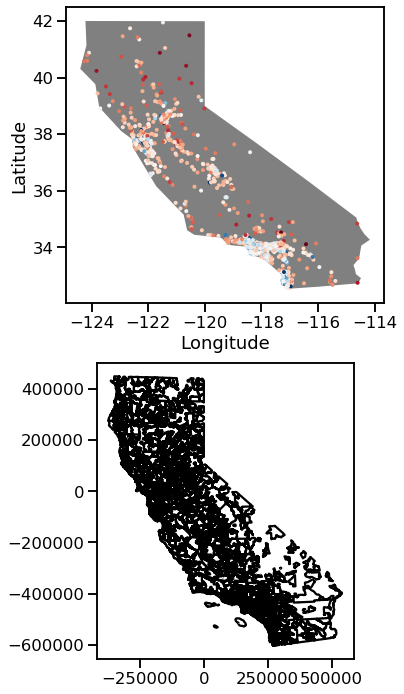

<IPython.core.display.Javascript object>

In [53]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 12))
df_CA.plot(ax=ax1, color='gray')


# ax1.scatter(pd.to_numeric(df_wgeo["Longitude"]), pd.to_numeric(df_wgeo["Latitude"]), c=pd.to_numeric(df_wgeo["Latitude"], s=2**0)
g = sns.scatterplot(
    data=df_wgeo,
    x="Longitude",
    y="Latitude",
    palette="RdBu",
    hue="graduation_rates_UCCSU_eligibility_LIstudents",
    s=2 ** 4,
    ax=ax1,
    legend=None,
    #legend='brief',
    linewidth=0
)

zip_shapefile.boundary.plot(ax=ax2, edgecolor='k', facecolor='none')

#g._legend.set_title('SPLICE')

It was not overlaying (see x and y axis values). I looked around and found [this page](https://stackoverflow.com/questions/56859435/geopandas-geodata-not-overlapping-shapefile-map).

I checked crs for both and they're different.

In [54]:
df_CA.crs, zip_shapefile.crs

({'init': 'epsg:4326'}, {'init': 'epsg:3310'})

<IPython.core.display.Javascript object>

In [55]:
# Make the second plot crs the same as the first
# zip_shapefile.to_crs(epsg="4326", inplace=True)

# New syntax
zip_shapefile.to_crs("epsg:4326", inplace=True)

/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<IPython.core.display.Javascript object>

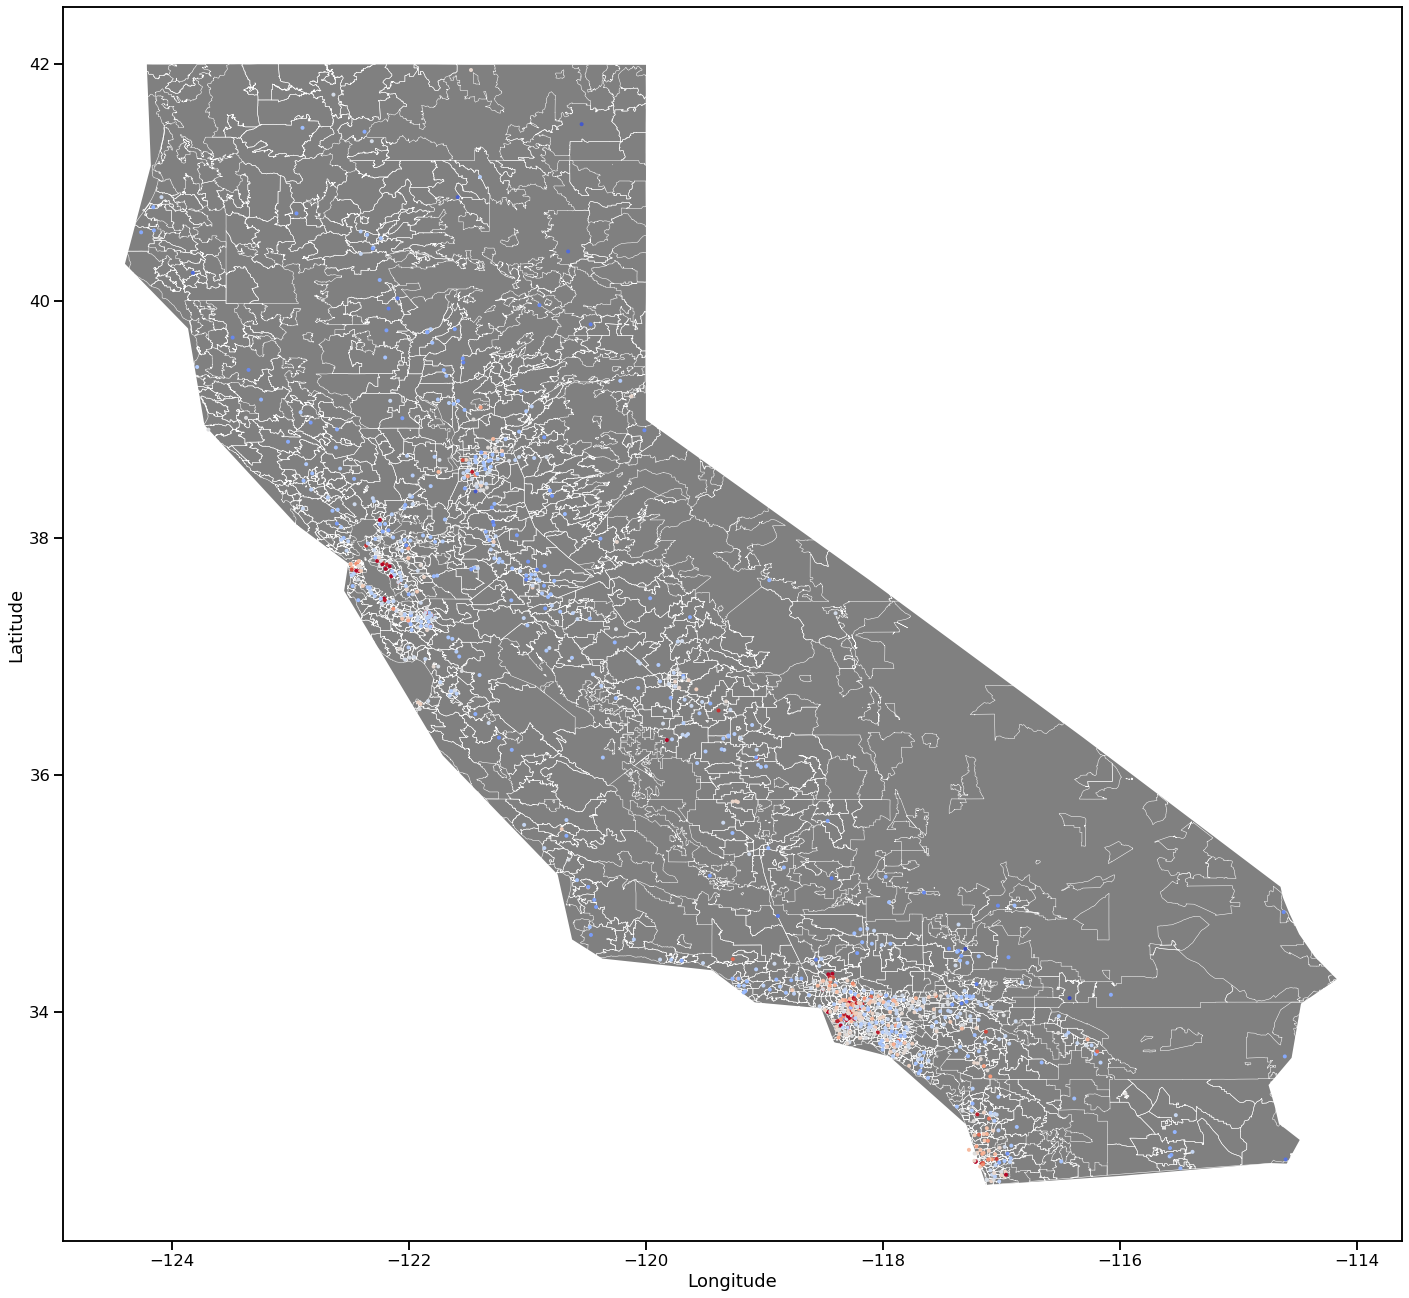

<IPython.core.display.Javascript object>

In [56]:
# Try again

f, (ax1) = plt.subplots(1, 1, figsize=(24, 24))
df_CA.plot(ax=ax1, color='gray', zorder=1)

zip_shapefile.boundary.plot(ax=ax1, edgecolor='white', linewidth=0.5, facecolor='none', zorder=2);

# ax1.scatter(pd.to_numeric(df_wgeo["Longitude"]), pd.to_numeric(df_wgeo["Latitude"]), c=pd.to_numeric(df_wgeo["Latitude"], s=2**0)
g = sns.scatterplot(
    data=df_wgeo,
    x="Longitude",
    y="Latitude",
    palette="coolwarm",
    hue="graduation_rates_UCCSU_eligibility_LIstudents",
    s=2 ** 4,
    ax=ax1,
    legend=None,
    #legend='brief',
    linewidth=0,
    zorder=3
)

#g._legend.set_title('SPLICE')

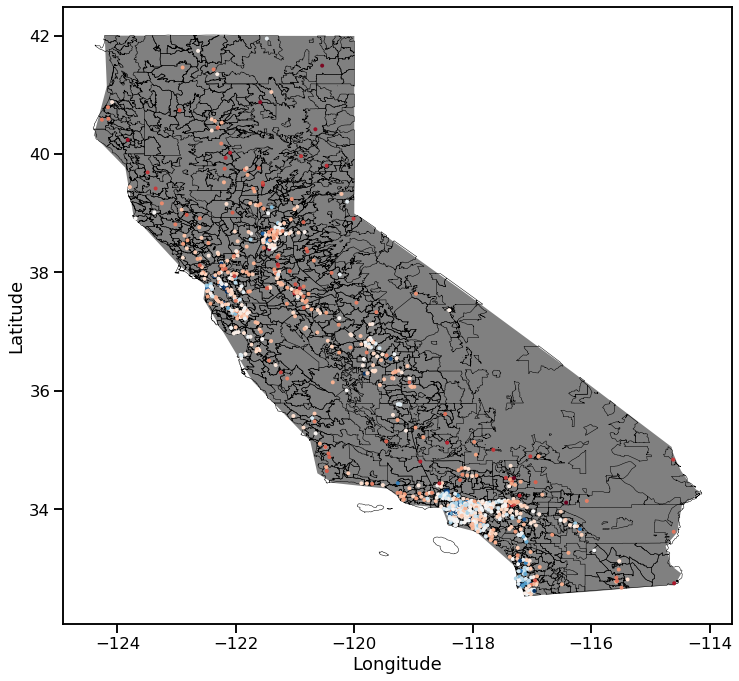

<IPython.core.display.Javascript object>

In [57]:
f, (ax1) = plt.subplots(1, 1, figsize=(12, 12))
df_CA.plot(ax=ax1, color='gray', zorder=1)

zip_shapefile.boundary.plot(ax=ax1, edgecolor='k', linewidth=0.5, facecolor='none', zorder=2);

# ax1.scatter(pd.to_numeric(df_wgeo["Longitude"]), pd.to_numeric(df_wgeo["Latitude"]), c=pd.to_numeric(df_wgeo["Latitude"], s=2**0)
g = sns.scatterplot(
    data=df_wgeo,
    x="Longitude",
    y="Latitude",
    palette="RdBu",
    hue="graduation_rates_UCCSU_eligibility_LIstudents",
    s=2 ** 4,
    ax=ax1,
    legend=None,
    #legend='brief',
    linewidth=0,
    zorder=3
)

#g._legend.set_title('SPLICE')

### Plot for economic characteristics

In [58]:
zip_code_features = ['zip_code',
       '%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months',
       '%; INCOME_BENEFITS - w/ Social Security',
       '%; INCOME_BENEFITS - w/ Supplemental Security Income',
       'Est.; INCOME_BENEFITS - Total households - Median household income ($)',
       'Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)',
       'Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)',
       '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage',
       '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage',
       '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs - No health ins coverage',
       '%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone',
       '%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- carpooled',
       '%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)',
       '%; WORK_COMMUTE - Workers 16 yrs and up - Walked',
       '%; WORK_COMMUTE - Workers 16 yrs and up - Worked at home',
       '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining',
       '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Construction',
       '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Educational services, and health care and social assistance',
       '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Finance and insurance, and real estate and rental and leasing',
       '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Information',
       '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Manufacturing',
       '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Other services, except public administration',
       '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services',
       '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Public administration',
       '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Retail trade',
       '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Transportation and warehousing, and utilities',
       '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Wholesale trade',
       '%; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Private wage and salary workers',
       '%; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Self-employed in own not incorporated business workers',
       '%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force',
       '%; EMPLOY_STATUS - Civilian labor force - Unemployment Rate',
       '%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Armed Forces',
       '%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force - Employed',
       '%; EMPLOY_STATUS - Own children of the householder 6 to 17 yrs - All parents in family in labor force']

<IPython.core.display.Javascript object>

In [59]:
df_state_info_gs_census_ziponly = df_state_info_gs_census[zip_code_features].drop_duplicates()

<IPython.core.display.Javascript object>

In [60]:
zip_shapefile.shape

(1769, 86)

<IPython.core.display.Javascript object>

In [61]:
zip_shapefile.head(2)

OBJECTID CNTY_FIPS COUNTY TRACT TRACT_ID CENSUS_KEY   ZCTA ZCTA_KEY  \
0         1      None   None  None     None       None  94601  0694601   
1         2      None   None  None     None       None  94501  0694501   

    LATITUDE   LONGITUDE  ...  HU_VAC  HU_VAC_REN  HU_VAC_SEA  HU_OCC_OWN  \
0  37.776711 -122.218378  ...    1536         839          28        4764   
1  37.774084 -122.278049  ...    2062         885         189       10286   

   HU_OCC_O_1  HU_OCC_REN  HU_OCC_R_1    Shape_area     Shape_len  \
0       16528       10062       32927  8.721649e+06  15265.093880   
1       26023       14739       32705  2.954478e+07  27119.154912   

                                            geometry  
0  POLYGON ((-122.22717 37.79197, -122.22693 37.7...  
1  POLYGON ((-122.29181 37.76301, -122.30661 37.7...  

[2 rows x 86 columns]

<IPython.core.display.Javascript object>

In [314]:
[print(col) for col in zip_shapefile.columns.tolist()]

OBJECTID
CNTY_FIPS
COUNTY
TRACT
TRACT_ID
CENSUS_KEY
ZCTA
ZCTA_KEY
LATITUDE
LONGITUDE
TOT_POP
AGE_UNDER5
AGE_5TO9
AGE_10TO14
AGE_15TO19
AGE_20TO24
AGE_25TO29
AGE_30TO34
AGE_35TO39
AGE_40TO44
AGE_45TO49
AGE_50TO54
AGE_55TO59
AGE_60TO64
AGE_65TO69
AGE_70TO74
AGE_75TO79
AGE_80TO84
AGE_85_OVE
AGE16_OVER
AGE18_OVER
AGE21_OVER
AGE62_OVER
AGE65_OVER
MALE
FEMALE
AGE_MEDIAN
AGE_MEDI_1
AGE_MEDI_2
ONE_RACE
WHITE
BLACK_AFAM
AMIND_ALAN
ASIAN
NATHAW_ISL
OTHER_RACE
MULTI_RACE
HISPANIC_L
NON_HISP_L
WHITE_NHL
BLACK_AF_1
AMIND_AL_1
ASIAN_NHL
NATHAW_I_1
OTHER_NHL
MULTI_RA_1
TOT_IN_HOU
TOT_IN_GC
GC_INST
GC_NONINST
GC_CORRECT
GC_JUV
GC_NURS
GC_OTHER
HH_TOTAL
HH_FAMILY
HH_NONFAML
HH_NONFAMI
HH_NONFA_1
HH_NONFA_2
HH_NONFA_3
HH_NONFA_4
HH_WITH_UN
HH_WITH_65
HU_TOTAL
HU_OCC
HU_VAC
HU_VAC_REN
HU_VAC_SEA
HU_OCC_OWN
HU_OCC_O_1
HU_OCC_REN
HU_OCC_R_1
Shape_area
Shape_len
geometry


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

<IPython.core.display.Javascript object>

In [62]:
type(zip_shapefile)

geopandas.geodataframe.GeoDataFrame

<IPython.core.display.Javascript object>

In [316]:
zip_shapefile["ZCTA"] = pd.to_numeric(zip_shapefile["ZCTA"])
feat2plot = "Est.; INCOME_BENEFITS - Total households - Median household income ($)"
df_state_census_wgeo = pd.merge(
    df_state_info_gs_census_ziponly[['zip_code', feat2plot]], zip_shapefile, left_on="zip_code", right_on="ZCTA"
)
df_state_census_wgeo.head()

zip_code  \
0     94612   
1     94501   
2     94621   
3     94706   
4     94704   

   Est.; INCOME_BENEFITS - Total households - Median household income ($)  \
0                                            32993.0                        
1                                            72884.0                        
2                                            31903.0                        
3                                            80970.0                        
4                                            26478.0                        

   OBJECTID CNTY_FIPS COUNTY TRACT TRACT_ID CENSUS_KEY   ZCTA ZCTA_KEY  ...  \
0       736      None   None  None     None       None  94612  0694612  ...   
1         2      None   None  None     None       None  94501  0694501  ...   
2      1322      None   None  None     None       None  94621  0694621  ...   
3       737      None   None  None     None       None  94706  0694706  ...   
4       730      None   None  None     None       None  94704  0694704  ...   

   HU_VAC  HU_VAC_REN  HU_VAC_SEA  HU_OCC_OWN  HU_OCC_O_1  HU_OCC_REN  \
0     953         572          38         642        1172        7326   
1    2062         885         189       10286       26023       14739   
2    1216         683          10        3111       11368        5362   
3     514         260          44        3918        9839        3997   
4     630         359          77         798        1790        8255   

   HU_OCC_R_1    Shape_area     Shape_len  \
0       11997  2.205249e+06  11539.060839   
1       32705  2.954478e+07  27119.154912   
2       18192  2.473526e+07  35852.648016   
3        9726  3.823563e+06   9233.319582   
4       16870  2.769875e+06  13670.844000   

                                            geometry  
0  POLYGON ((-122.27449 37.80389, -122.27473 37.8...  
1  POLYGON ((-122.29181 37.76301, -122.30661 37.7...  
2  POLYGON ((-122.20084 37.76913, -122.20018 37.7...  
3  POLYGON ((-122.29886 37.89847, -122.29869 37.8...  
4  POLYGON ((-122.27297 37.87058, -122.27299 37.8...  

[5 rows x 88 columns]

<IPython.core.display.Javascript object>

In [317]:
zip_shapefile["ZCTA"] = pd.to_numeric(zip_shapefile["ZCTA"])
feat2plot = "Est.; INCOME_BENEFITS - Total households - Median household income ($)"

zip_shapefile_wfeat = zip_shapefile.set_index('ZCTA').join(df_state_info_gs_census_ziponly[['zip_code', feat2plot]].set_index('zip_code'),
                                         how='left')
type(zip_shapefile_wfeat)
zip_shapefile_wfeat.head()

# Can't do a merge - do a join
# df_state_census_wgeo = pd.merge(
#     df_state_info_gs_census_ziponly[['zip_code', feat2plot]], zip_shapefile, how='right', left_on="zip_code", right_on="ZCTA"
# )
# df_state_census_wgeo.head()

OBJECTID CNTY_FIPS COUNTY TRACT TRACT_ID CENSUS_KEY ZCTA_KEY  \
ZCTA                                                                  
94601         1      None   None  None     None       None  0694601   
94501         2      None   None  None     None       None  0694501   
94560         3      None   None  None     None       None  0694560   
94587         4      None   None  None     None       None  0694587   
94580         5      None   None  None     None       None  0694580   

        LATITUDE   LONGITUDE  TOT_POP  ...  HU_VAC_REN  HU_VAC_SEA  \
ZCTA                                   ...                           
94601  37.776711 -122.218378    50294  ...         839          28   
94501  37.774084 -122.278049    60212  ...         885         189   
94560  37.520360 -122.031000    42573  ...         170          17   
94587  37.603151 -122.018626    69516  ...         384          39   
94580  37.676958 -122.133606    27152  ...         116          15   

       HU_OCC_OWN  HU_OCC_O_1  HU_OCC_REN  HU_OCC_R_1    Shape_area  \
ZCTA                                                                  
94601        4764       16528       10062       32927  8.721649e+06   
94501       10286       26023       14739       32705  2.954478e+07   
94560        8942       28489        4030       13939  3.581839e+07   
94587       13580       46272        6853       22726  5.107510e+07   
94580        6105       18760        2519        8252  8.946896e+06   

          Shape_len                                           geometry  \
ZCTA                                                                     
94601  15265.093880  POLYGON ((-122.22717 37.79197, -122.22693 37.7...   
94501  27119.154912  POLYGON ((-122.29181 37.76301, -122.30661 37.7...   
94560  30752.336176  POLYGON ((-122.05499 37.54960, -122.05441 37.5...   
94587  53110.314427  POLYGON ((-122.06515 37.60485, -122.06499 37.6...   
94580  20260.685185  POLYGON ((-122.12999 37.68445, -122.12995 37.6...   

       Est.; INCOME_BENEFITS - Total households - Median household income ($)  
ZCTA                                                                           
94601                                            39184.0                       
94501                                            72884.0                       
94560                                            86757.0                       
94587                                            85521.0                       
94580                                            71120.0                       

[5 rows x 86 columns]

<IPython.core.display.Javascript object>

### Local median income

/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


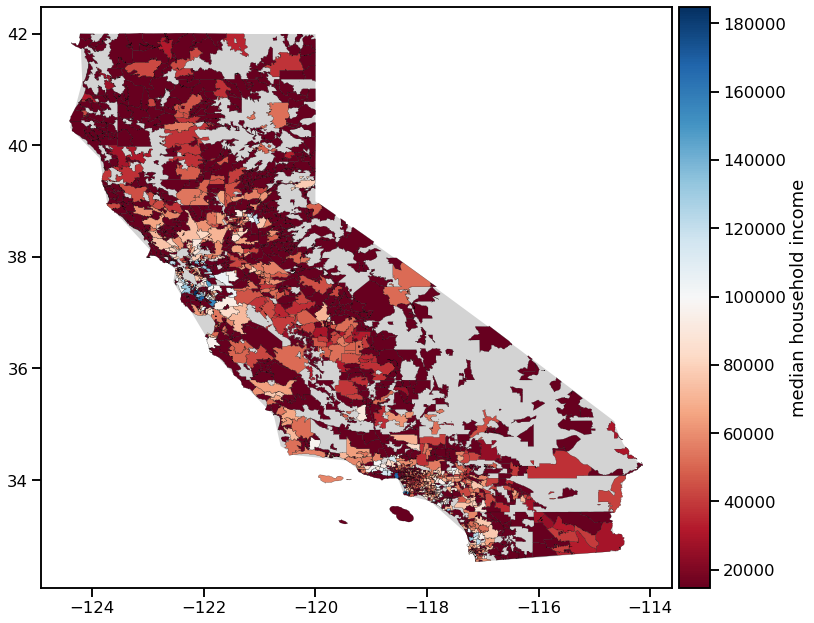

<IPython.core.display.Javascript object>

In [67]:
zip_shapefile["ZCTA"] = pd.to_numeric(zip_shapefile["ZCTA"])
feat2plot1 = "Est.; INCOME_BENEFITS - Total households - Median household income ($)"
zip_shapefile_wfeat1 = zip_shapefile.set_index('ZCTA').join(df_state_info_gs_census_ziponly[['zip_code', feat2plot1]].set_index('zip_code'),
                                         how='left')

f, (ax1) = plt.subplots(1, 1, figsize=(12, 12))
df_CA.plot(ax=ax1, color='lightgray', zorder=0)

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
    
zip_shapefile_wfeat1.plot(column=feat2plot1,
                     ax=ax1,
                     legend=True,
                     edgecolor='black',
                     cmap='RdBu',
                     linewidth = 0.2,
                          cax=cax,
                     legend_kwds={'label':"median household income", 'orientation': "vertical"},
                         zorder=1)

/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


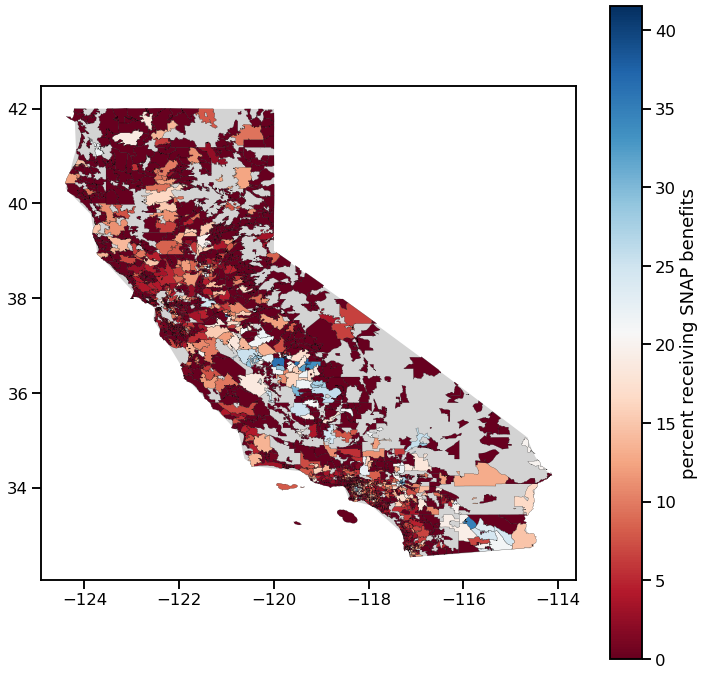

<IPython.core.display.Javascript object>

In [333]:
feat2plot = '%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months'

zip_shapefile_wfeat = zip_shapefile.set_index('ZCTA').join(df_state_info_gs_census_ziponly[['zip_code', feat2plot]].set_index('zip_code'),
                                         how='left')

f, (ax1) = plt.subplots(1, 1, figsize=(12, 12))
df_CA.plot(ax=ax1, color='lightgray', zorder=1)


zip_shapefile_wfeat.plot(column=feat2plot,
                     ax=ax1,
                     legend=True,
                     edgecolor='black',
                     cmap='RdBu',
                     linewidth = 0.2,
                     legend_kwds={'label':"percent receiving SNAP benefits", 'orientation': "vertical"})

### CA counties

In [84]:
bay_area_counties = [
    "San Francisco",
    "San Mateo",
    "Santa Clara",
    "Alameda",
    "Fremont",
    "Marin",
]

county_df = df_state_info_gs_census[
    df_state_info_gs_census["County"].isin(bay_area_counties)
].copy()


ba_lat_min, ba_lat_max, ba_long_min, ba_long_max = (
    county_df["Latitude"].min(),
    county_df["Latitude"].max(),
    county_df["Longitude"].min(),
    county_df["Longitude"].max(),
)
ba_lat_min, ba_lat_max, ba_long_min, ba_long_max

(36.997203000000006, 38.247656, -122.89528, -121.57599)

<IPython.core.display.Javascript object>

In [85]:
county_df = df_state_info_gs_census[
    df_state_info_gs_census["County"] == "Los Angeles"
].copy()

la_lat_min, la_lat_max, la_long_min, la_long_max = (
    county_df["Latitude"].min(),
    county_df["Latitude"].max(),
    county_df["Longitude"].min(),
    county_df["Longitude"].max(),
)
la_lat_min, la_lat_max, la_long_min, la_long_max

(33.73059, 34.69911, -118.74948, -117.72041000000002)

<IPython.core.display.Javascript object>

In [86]:
county_df = df_state_info_gs_census[
    df_state_info_gs_census["County"] == "San Diego"
].copy()

sd_lat_min, sd_lat_max, sd_long_min, sd_long_max = (
    float(county_df["Latitude"].min()),
    float(county_df["Latitude"].max()),
    float(county_df["Longitude"].min()),
    float(county_df["Longitude"].max()),
)
sd_lat_min, sd_lat_max, sd_long_min, sd_long_max

(32.566438, 33.349505, -117.37414, -116.38373)

<IPython.core.display.Javascript object>

invalid value encountered in less
invalid value encountered in less
invalid value encountered in less
invalid value encountered in less


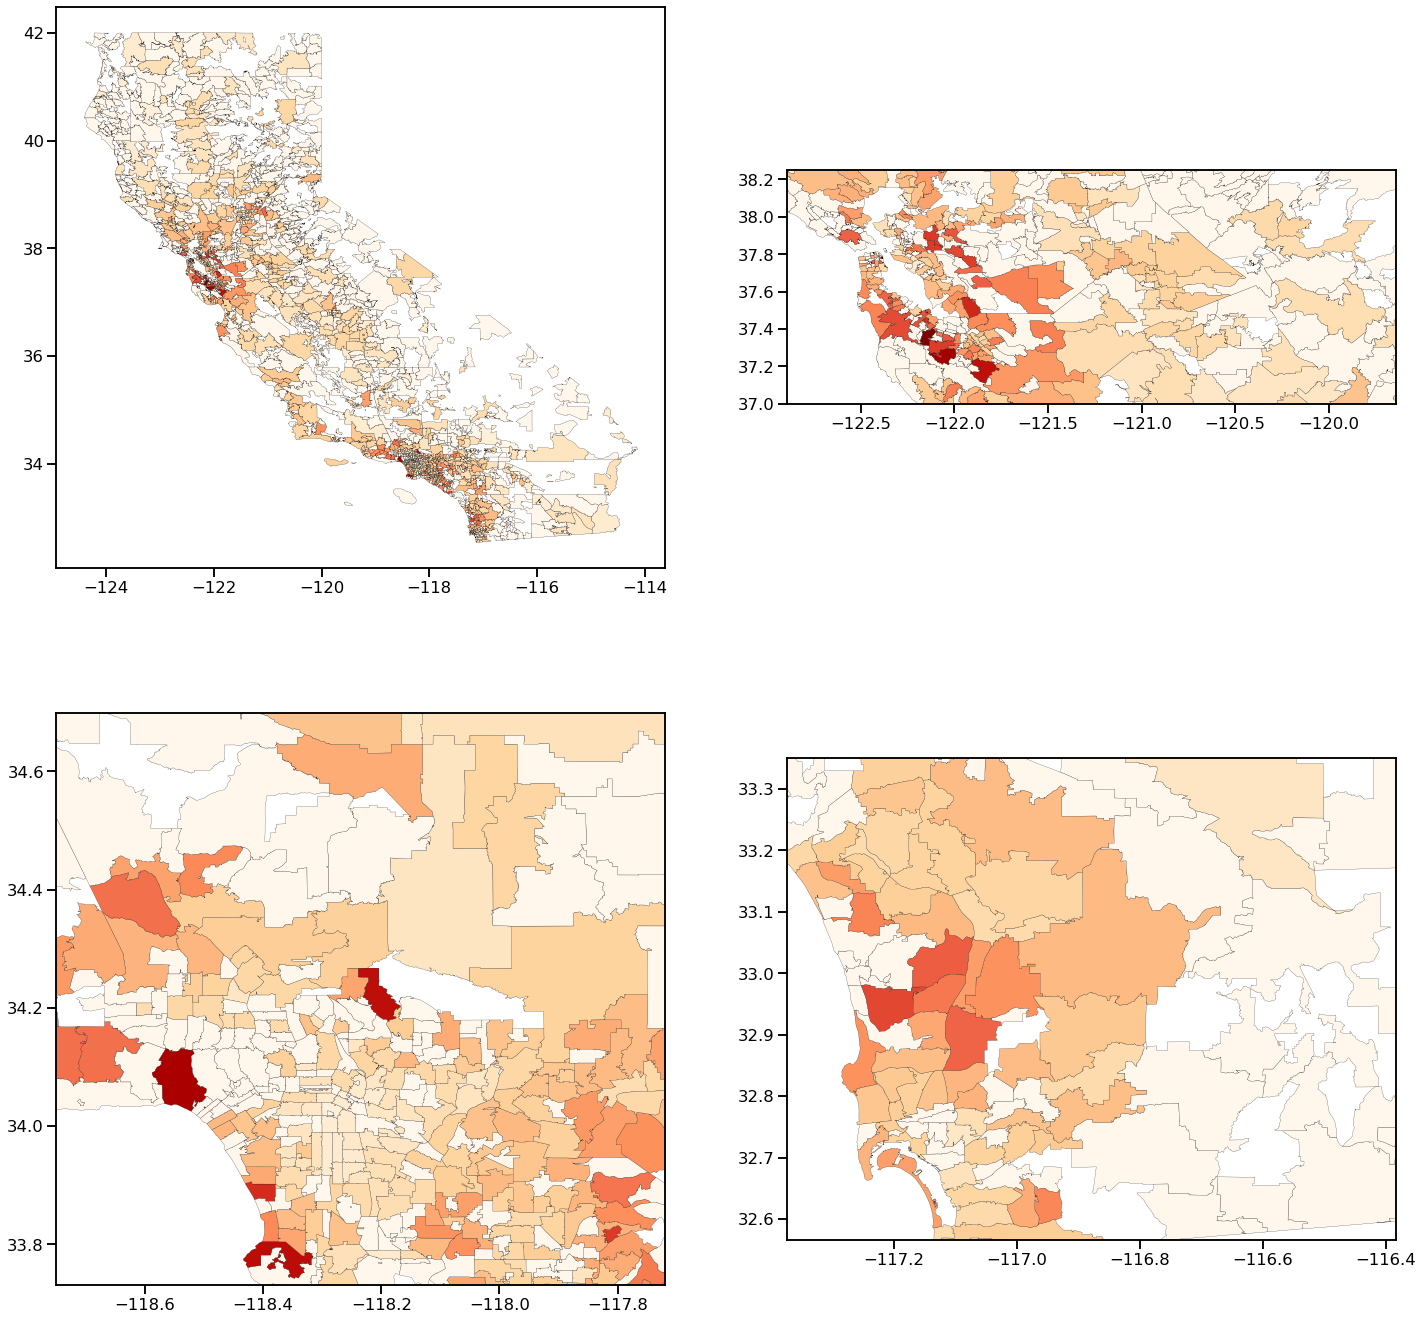

<IPython.core.display.Javascript object>

In [784]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 24))

# CA
# df_CA.plot(ax=ax1, color="gray", zorder=1)
zip_shapefile_wfeat.plot(
    column=feat2plot,
    ax=ax1,
    # legend=True,
    edgecolor="black",
    cmap="OrRd",
    linewidth=0.2,
    # legend_kwds={"label": "median household income", "orientation": "vertical"},
)

# Bay Area
df_CA.plot(ax=ax2, color="white", zorder=1)
zip_shapefile_wfeat.plot(
    column=feat2plot,
    ax=ax2,
    # legend=True,
    edgecolor="black",
    cmap="OrRd",
    linewidth=0.2,
    # legend_kwds={"label": "median household income", "orientation": "vertical"},
)
ax2.set_xlim([ba_long_min, ba_long_max])
ax2.set_ylim([ba_lat_min, ba_lat_max])


# LA
df_CA.plot(ax=ax3, color="white", zorder=1)
zip_shapefile_wfeat.plot(
    column=feat2plot,
    ax=ax3,
    # legend=True,
    edgecolor="black",
    cmap="OrRd",
    linewidth=0.2,
    # legend_kwds={"label": "median household income", "orientation": "vertical"},
)
ax3.set_xlim([la_long_min, la_long_max])
ax3.set_ylim([la_lat_min, la_lat_max])


# SD
df_CA.plot(ax=ax4, color="white", zorder=1)
zip_shapefile_wfeat.plot(
    column=feat2plot,
    ax=ax4,
    # legend=True,
    edgecolor="black",
    cmap="OrRd",
    linewidth=0.2,
    # legend_kwds={"label": "median household income", "orientation": "vertical"},
)

ax4.set_xlim([sd_long_min, sd_long_max])
ax4.set_ylim([sd_lat_min, sd_lat_max])

### Different CA

The one I got originally does not have good definition for the Bay Area.

In [683]:
# File from http://geojson.xyz/

url = "https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_admin_1_states_provinces_scale_rank.geojson"
df_states = geopandas.read_file(url)
df_states.head()
# df_CA2 = df_states[df_states["name"] == "California"]
# df_CA2.head()

scalerank adm1_code        featureclass  \
0          2  USA-3514  Admin-1 scale rank   
1          2  USA-3515  Admin-1 scale rank   
2          2  USA-3516  Admin-1 scale rank   
3          2  USA-3517  Admin-1 scale rank   
4          2  USA-3518  Admin-1 scale rank   

                                            geometry  
0  POLYGON ((-89.59941 48.01027, -89.48888 48.013...  
1  POLYGON ((-111.19419 44.56116, -111.29155 44.7...  
2  POLYGON ((-96.60136 46.35136, -96.53891 46.199...  
3  MULTIPOLYGON (((-155.93665 19.05939, -155.9080...  
4  POLYGON ((-111.04973 44.48816, -111.05024 42.0...

<IPython.core.display.Javascript object>

In [681]:
df_states

scalerank  name adm0_a3                 adm0_name  mapcolor9  mapcolor13  \
0            2  None     USA  United States of America          1           1   
1            2  None     USA  United States of America          1           1   
2            2  None     USA  United States of America          1           1   
3            2  None     USA  United States of America          1           1   
4            2  None     USA  United States of America          1           1   
..         ...   ...     ...                       ...        ...         ...   
105          2  None     USA  United States of America          1           1   
106          2  None     USA  United States of America          1           1   
107          2  None     USA  United States of America          1           1   
108          2  None     USA  United States of America          1           1   
109          2  None     USA  United States of America          1           1   

         featureclass                                           geometry  
0    Admin-1 boundary  LINESTRING (-74.67903 41.35549, -74.84044 41.4...  
1    Admin-1 boundary  LINESTRING (-87.59780 45.10629, -87.61292 45.1...  
2    Admin-1 boundary  LINESTRING (-91.22820 43.50125, -91.25466 43.6...  
3    Admin-1 boundary  LINESTRING (-80.51893 40.64111, -80.51627 41.9...  
4    Admin-1 boundary  LINESTRING (-84.80676 41.67774, -84.29506 41.6...  
..                ...                                                ...  
105  Admin-1 boundary  LINESTRING (-114.03422 41.99312, -117.02825 42...  
106  Admin-1 boundary  LINESTRING (-70.64573 43.09008, -70.81505 42.8...  
107  Admin-1 boundary  LINESTRING (-70.64573 43.09008, -70.75102 43.0...  
108  Admin-1 boundary  LINESTRING (-72.45707 42.72708, -71.24898 42.7...  
109  Admin-1 boundary  LINESTRING (-72.45707 42.72708, -72.53750 42.8...  

[110 rows x 8 columns]

<IPython.core.display.Javascript object>

(-125, -115)

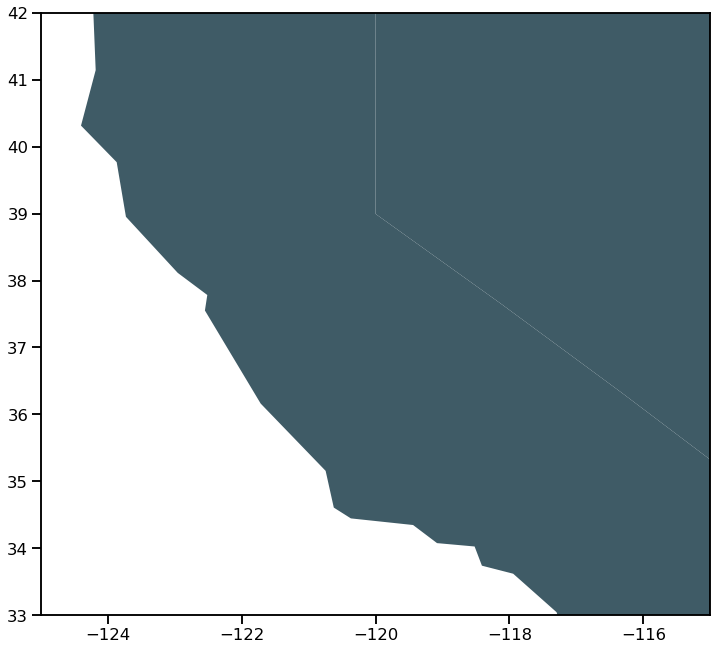

<IPython.core.display.Javascript object>

In [686]:
f, ax1 = plt.subplots(figsize=(12, 12))
df_states.plot(ax=ax1, color=B_slate)
ax1.set_ylim(33, 42)
ax1.set_xlim(-125, -115)

## Stanford Earthworks county file

In [30]:
sew_shapefile_loc = "data/references/stanford_ew_data/cnty24k09_1_multipart.shp"
sew_sf = geopandas.read_file(sew_shapefile_loc)
sew_sf.head()

NAME_PCASE NAME_UCASE         FMNAME_PC         FMNAME_UC ABBREV  NUM  \
0   Siskiyou   SISKIYOU   Siskiyou County   SISKIYOU COUNTY    SIS   47   
1  Del Norte  DEL NORTE  Del Norte County  DEL NORTE COUNTY    DNT    8   
2      Modoc      MODOC      Modoc County      MODOC COUNTY    MOD   25   
3    Trinity    TRINITY    Trinity County    TRINITY COUNTY    TRI   53   
4     Shasta     SHASTA     Shasta County     SHASTA COUNTY    SHA   45   

  ABCODE ANSI     Shape_Leng    Shape_Area  \
0   c047  093  672205.907573  1.643940e+10   
1   c008  015  314234.542738  2.626276e+09   
2   c025  049  423574.415010  1.088488e+10   
3   c053  105  611269.176825  8.307254e+09   
4   c045  089  537564.913338  9.976444e+09   

                                            geometry  
0  POLYGON ((-121409.383 352836.156, -122787.000 ...  
1  MULTIPOLYGON (((-349081.500 420895.000, -34927...  
2  POLYGON ((-120188.047 443056.938, -118144.953 ...  
3  POLYGON ((-225262.531 309846.500, -225280.500 ...  
4  POLYGON ((-184515.750 264676.375, -184542.047 ...

<IPython.core.display.Javascript object>

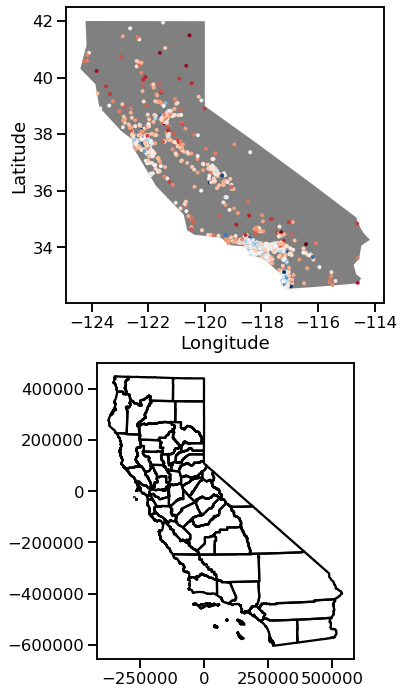

<IPython.core.display.Javascript object>

In [31]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 12))
df_CA.plot(ax=ax1, color='gray')

# ax1.scatter(pd.to_numeric(df_wgeo["Longitude"]), pd.to_numeric(df_wgeo["Latitude"]), c=pd.to_numeric(df_wgeo["Latitude"], s=2**0)
g = sns.scatterplot(
    data=df_wgeo,
    x="Longitude",
    y="Latitude",
    palette="RdBu",
    hue="graduation_rates_UCCSU_eligibility_LIstudents",
    s=2 ** 4,
    ax=ax1,
    legend=None,
    #legend='brief',
    linewidth=0
)

sew_sf.boundary.plot(ax=ax2, edgecolor='k', facecolor='none')

#g._legend.set_title('SPLICE')

**Update CRS**

In [32]:
sew_sf.crs

{'init': 'epsg:3310'}

<IPython.core.display.Javascript object>

In [33]:
df_CA.crs, zip_shapefile.crs

({'init': 'epsg:4326'}, 'epsg:4326')

<IPython.core.display.Javascript object>

In [68]:
# Make the second plot crs the same as the shapefile tried earlier
sew_sf.to_crs("epsg:4326", inplace=True)

<IPython.core.display.Javascript object>

### School locations in state

Create points for labeling

Taken from here: https://stackoverflow.com/questions/38899190/geopandas-label-polygons

In [35]:
sew_sf_text = sew_sf.copy()

sew_sf_text['coords'] = sew_sf_text['geometry'].apply(lambda x: x.representative_point().coords[:])
sew_sf_text['coords'] = [coords[0] for coords in sew_sf_text['coords']]

<IPython.core.display.Javascript object>

In [36]:
sew_sf_text.head(3)

NAME_PCASE NAME_UCASE         FMNAME_PC         FMNAME_UC ABBREV  NUM  \
0   Siskiyou   SISKIYOU   Siskiyou County   SISKIYOU COUNTY    SIS   47   
1  Del Norte  DEL NORTE  Del Norte County  DEL NORTE COUNTY    DNT    8   
2      Modoc      MODOC      Modoc County      MODOC COUNTY    MOD   25   

  ABCODE ANSI     Shape_Leng    Shape_Area  \
0   c047  093  672205.907573  1.643940e+10   
1   c008  015  314234.542738  2.626276e+09   
2   c025  049  423574.415010  1.088488e+10   

                                            geometry  \
0  POLYGON ((-121.44597 41.18390, -121.46238 41.1...   
1  MULTIPOLYGON (((-124.19097 41.73619, -124.1933...   
2  POLYGON ((-121.44784 41.99739, -121.42322 41.9...   

                                     coords  
0  (-122.54435416528992, 41.50072231870031)  
1  (-123.90578607724461, 41.69084678856494)  
2  (-120.72427521391177, 41.59353861196223)

<IPython.core.display.Javascript object>

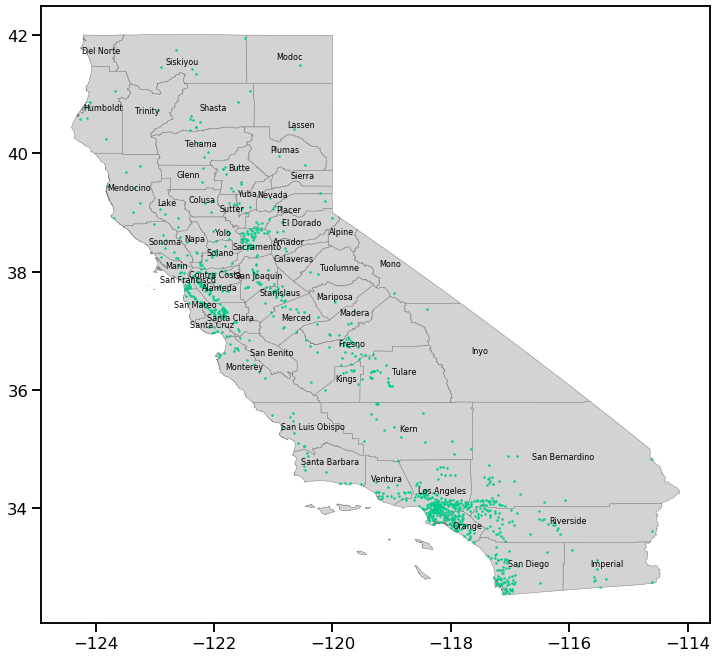

<IPython.core.display.Javascript object>

In [37]:
f, ax1 = plt.subplots(figsize=(12, 12))
sew_sf.boundary.plot(ax=ax1, linewidth=0.5, edgecolor='gray', facecolor='lightgray', zorder=0)
ax1.scatter(pd.to_numeric(df_wgeo["Longitude"]), pd.to_numeric(df_wgeo["Latitude"]), c=B_green, s=2**0, zorder=1);

# Label counties
for idx, row in sew_sf_text.iterrows():
    plt.annotate(s=row['NAME_PCASE'], xy=row['coords'],
                 horizontalalignment='center', fontsize=8, color='black')

    
plt.savefig(figure_loc + 'CA_map_school_loc_counties.png')

In [38]:
type(df_wgeo['graduation_rates_UCCSU_eligibility_LIstudents'])

pandas.core.series.Series

<IPython.core.display.Javascript object>

In [39]:
type(df_wgeo["Longitude"])

pandas.core.series.Series

<IPython.core.display.Javascript object>

Changed legend to be a colorbar [here](https://stackoverflow.com/questions/49761221/make-seaborn-show-a-colorbar-instead-of-a-legend-when-using-hue-in-a-bar-plot)
<br>
Matched color bar size to graph [here](https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph)

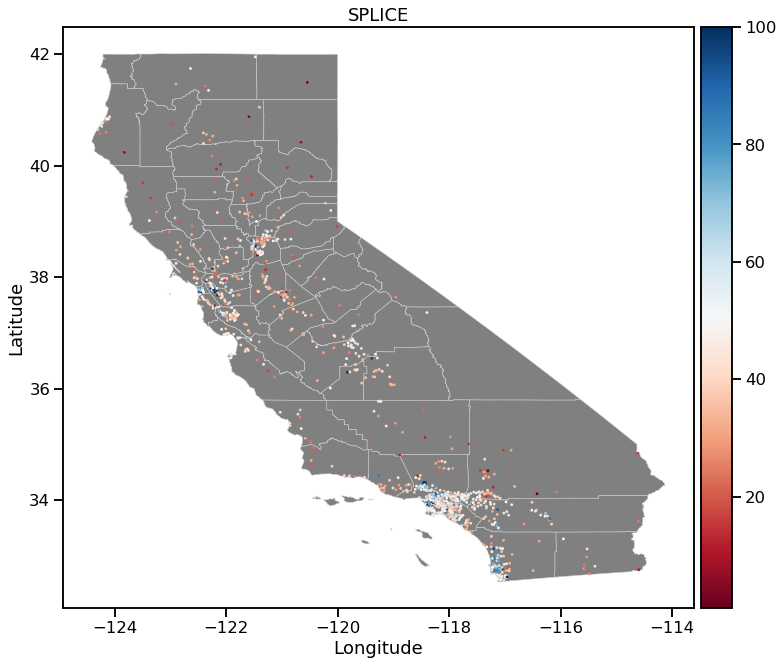

<IPython.core.display.Javascript object>

In [40]:
f, ax1 = plt.subplots(figsize=(12, 12))
sew_sf.boundary.plot(ax=ax1, linewidth=0.5, edgecolor='lightgray', facecolor='gray', zorder=0)

# Label with SPLICE
g = sns.scatterplot(
    data=df_wgeo,
    x="Longitude",
    y="Latitude",
    palette="RdBu",
    hue="graduation_rates_UCCSU_eligibility_LIstudents",
    s=2 ** 3,
    ax=ax1,
    linewidth=0,
    zorder=1
)

norm = plt.Normalize(df_wgeo['graduation_rates_UCCSU_eligibility_LIstudents'].min(), df_wgeo['graduation_rates_UCCSU_eligibility_LIstudents'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm, cax)
ax1.set_title('SPLICE')

plt.savefig(figure_loc + 'CA_map_school_SPLICE.png');

## Check SD County and include zip code

Use zip code shapefile with labels

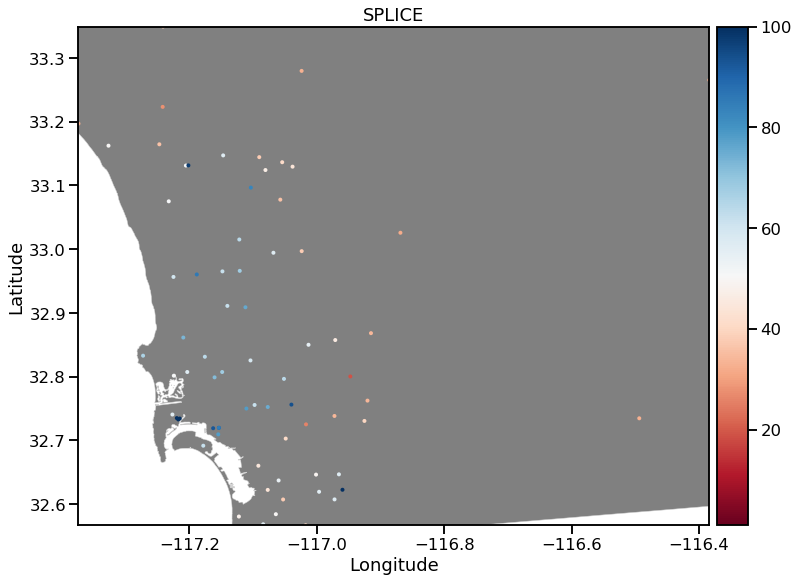

<IPython.core.display.Javascript object>

In [42]:
county_df = df_state_info_gs_census[
    df_state_info_gs_census["County"] == "San Diego"
].copy()

sd_lat_min, sd_lat_max, sd_long_min, sd_long_max = (
    float(county_df["Latitude"].min()),
    float(county_df["Latitude"].max()),
    float(county_df["Longitude"].min()),
    float(county_df["Longitude"].max()),
)
sd_lat_min, sd_lat_max, sd_long_min, sd_long_max

f, ax1 = plt.subplots(figsize=(12, 12))

# State/county
sew_sf.boundary.plot(ax=ax1, linewidth=0.5, edgecolor='lightgray', facecolor='gray', zorder=0)

# Zip code
zip_shapefile_wlabels.boundary.plot(ax=ax1, edgecolor='lightgray', linewidth=0.5, facecolor='none', zorder=1)

# Label with SPLICE
g = sns.scatterplot(
    data=df_wgeo,
    x="Longitude",
    y="Latitude",
    palette="RdBu",
    hue="graduation_rates_UCCSU_eligibility_LIstudents",
    s=2 ** 4,
    ax=ax1,
    linewidth=0,
    zorder=2
)
ax1.set_xlim([sd_long_min, sd_long_max])
ax1.set_ylim([sd_lat_min, sd_lat_max])

norm = plt.Normalize(df_wgeo['graduation_rates_UCCSU_eligibility_LIstudents'].min(), df_wgeo['graduation_rates_UCCSU_eligibility_LIstudents'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm, cax)
ax1.set_title('SPLICE');

**Do some labeling of zip code with city or school district**

In [548]:
zip_shapefile_wlabels.head(2)

OBJECTID CNTY_FIPS COUNTY TRACT TRACT_ID CENSUS_KEY   ZCTA ZCTA_KEY  \
0         1      None   None  None     None       None  94601  0694601   
1         2      None   None  None     None       None  94501  0694501   

    LATITUDE   LONGITUDE  ...  HU_OCC_O_1  HU_OCC_REN  HU_OCC_R_1  \
0  37.776711 -122.218378  ...       16528       10062       32927   
1  37.774084 -122.278049  ...       26023       14739       32705   

     Shape_area     Shape_len  \
0  8.721649e+06  15265.093880   
1  2.954478e+07  27119.154912   

                                            geometry  zip_code     City  \
0  POLYGON ((-122.22717 37.79197, -122.22693 37.7...     94601  Oakland   
1  POLYGON ((-122.29181 37.76301, -122.30661 37.7...     94501  Alameda   

          District                                    coords  
0  Oakland Unified  (-122.21639276889405, 37.77529349962347)  
1  Alameda Unified  (-122.28279858566748, 37.77500700030755)  

[2 rows x 90 columns]

<IPython.core.display.Javascript object>

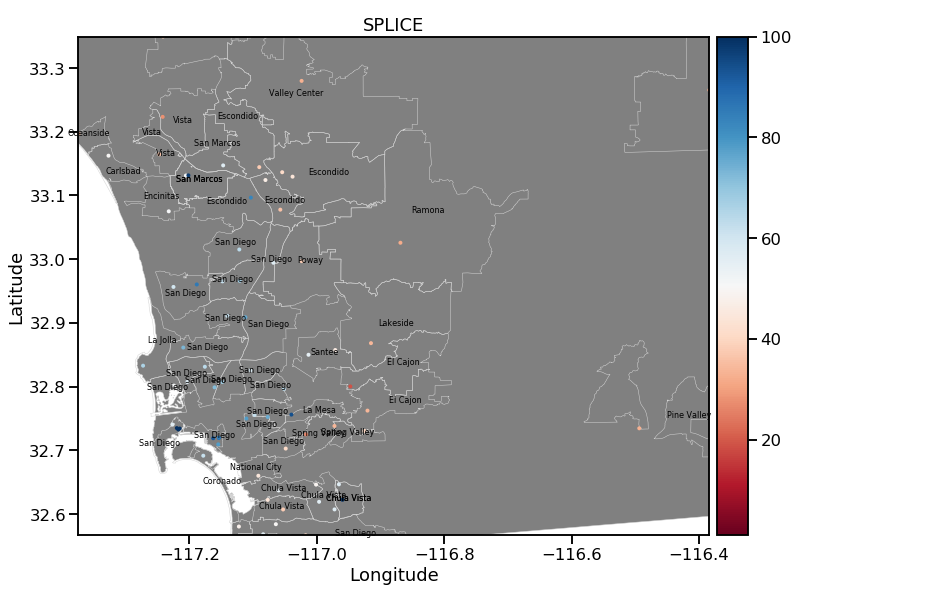

<IPython.core.display.Javascript object>

In [853]:
county_df = df_state_info_gs_census[
    df_state_info_gs_census["County"] == "San Diego"
].copy()

sd_lat_min, sd_lat_max, sd_long_min, sd_long_max = (
    float(county_df["Latitude"].min()),
    float(county_df["Latitude"].max()),
    float(county_df["Longitude"].min()),
    float(county_df["Longitude"].max()),
)
sd_lat_min, sd_lat_max, sd_long_min, sd_long_max

f, ax1 = plt.subplots(figsize=(12, 12))

# State/county
sew_sf.boundary.plot(ax=ax1, linewidth=0.5, edgecolor='lightgray', facecolor='gray', zorder=0)

# Zip code
zip_shapefile_wlabels.boundary.plot(ax=ax1, edgecolor='lightgray', linewidth=0.5, facecolor='none', zorder=1)

# Label with SPLICE
g = sns.scatterplot(
    data=df_wgeo,
    x="Longitude",
    y="Latitude",
    palette="RdBu",
    hue="graduation_rates_UCCSU_eligibility_LIstudents",
    s=2 ** 4,
    ax=ax1,
    linewidth=0,
    zorder=2
)
ax1.set_xlim([sd_long_min, sd_long_max])
ax1.set_ylim([sd_lat_min, sd_lat_max])

# Label cities - limit to SD
zip_shapefile_wlabels_SD = zip_shapefile_wlabels[zip_shapefile_wlabels['County']=='San Diego'].copy()
zip_shapefile_wlabels_SD['coords'] = zip_shapefile_wlabels_SD['geometry'].apply(lambda x: x.representative_point().coords[:])
zip_shapefile_wlabels_SD['coords'] = [coords[0] for coords in zip_shapefile_wlabels_SD['coords']]

for idx, row in zip_shapefile_wlabels_SD.iterrows():
    ax1.annotate(s=row['City'], xy=row['coords'],
                 horizontalalignment='center', fontsize=8, color='black')

norm = plt.Normalize(df_wgeo['graduation_rates_UCCSU_eligibility_LIstudents'].min(), df_wgeo['graduation_rates_UCCSU_eligibility_LIstudents'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm, cax)
ax1.set_title('SPLICE')

plt.savefig(figure_loc + 'SD_map_school_loc_neighborhoods.png');


**Pick one location to label for each city**

In [557]:
# Label cities - limit to SD
zip_shapefile_wlabels_SD = zip_shapefile_wlabels[zip_shapefile_wlabels['County']=='San Diego'].copy()
zip_shapefile_wlabels_SD['coords'] = zip_shapefile_wlabels_SD['geometry'].apply(lambda x: x.representative_point().coords[:])
zip_shapefile_wlabels_SD['coords'] = [coords[0] for coords in zip_shapefile_wlabels_SD['coords']]
for idx, row in zip_shapefile_wlabels_SD.iterrows():
    ax1.annotate(s=row['City'], xy=row['coords'],
                 horizontalalignment='center', fontsize=8, color='black')

<IPython.core.display.Javascript object>

In [559]:
zip_shapefile_wlabels_SD.head(2)

OBJECTID CNTY_FIPS COUNTY TRACT TRACT_ID CENSUS_KEY   ZCTA ZCTA_KEY  \
60       162      None   None  None     None       None  92111  0692111   
61       164      None   None  None     None       None  92037  0692037   

     LATITUDE   LONGITUDE  ...  HU_OCC_REN  HU_OCC_R_1    Shape_area  \
60  32.806482 -117.168861  ...        8067       23711  2.191061e+07   
61  32.856552 -117.252008  ...        7198       14751  3.909865e+07   

       Shape_len                                           geometry  zip_code  \
60  30104.584638  POLYGON ((-117.16476 32.82585, -117.16513 32.8...     92111   
61  42239.295039  POLYGON ((-117.28240 32.82618, -117.28255 32.8...     92037   

       County       City           District  \
60  San Diego  San Diego  San Diego Unified   
61  San Diego   La Jolla  San Diego Unified   

                                       coords  
60  (-117.17390980688711, 32.807203499931894)  
61    (-117.24288232789729, 32.8699584997926)  

[2 rows x 91 columns]

<IPython.core.display.Javascript object>

**Use the average location by Euclidean distance for each city**

In [563]:
zip_shapefile_wlabels_SD[zip_shapefile_wlabels_SD['City']=='Chula Vista'].loc[:, ['City', 'coords']]

City                                    coords
187  Chula Vista  (-117.05138249807852, 32.63637399970967)
277  Chula Vista  (-117.05491244963693, 32.60806999998113)
614  Chula Vista  (-116.94924761077982, 32.62153199993554)
615  Chula Vista  (-116.94924761077982, 32.62153199993554)
740  Chula Vista   (-116.9885546680404, 32.62658149992055)

<IPython.core.display.Javascript object>

In [769]:
def return_avg_loc(shapefile, category, min_fontsize):
    """
    Returns the average location based on city, district, etc.
    Also returns fontsize, based on the number of values each category member has
    """
    members = shapefile[category].unique()
    
    # No. of entries
    df_category_value = pd.DataFrame(shapefile[category].value_counts())
    
    for member in members:
        member_coords = shapefile[shapefile[category]==member].loc[:, 'coords'].tolist()   # Pandas series, limit to one member
        long_vals = list()
        lat_vals = list()
        for i in member_coords:
            long_vals.append(i[0])
            lat_vals.append(i[1])
            
        df_category_value.loc[member, 'avg_long'] = np.mean(long_vals)
        df_category_value.loc[member, 'avg_lat'] = np.mean(lat_vals)
        
    
    df_category_value['avg_coord'] = list(zip(df_category_value['avg_long'], df_category_value['avg_lat']))
    df_category_value.columns = ['n_entries', 'avg_long', 'avg_lat', 'avg_coord']
    
    # Fontsize formatting
    min_fontsize = min_fontsize
    max_fontsize = min_fontsize + 8
    fontsize_diff = max_fontsize-min_fontsize

    n_categories_max = df_category_value['n_entries'].max()
    n_categories_min = df_category_value['n_entries'].min()
    n_categories_diff = n_categories_max-n_categories_min

    x_fs = df_category_value['n_entries']*(fontsize_diff/n_categories_diff)
    fontsize = round(x_fs + my_min_fontsize)
    df_category_value['fontsize'] = fontsize
    
    # Order by the latitude to make reading maps easier
    df_category_value.sort_values(by='avg_lat', inplace=True)
    
    df_category_value.reset_index(inplace=True)
    
    return df_category_value

<IPython.core.display.Javascript object>

In [770]:
df_sd_avgtext_loc = return_avg_loc(zip_shapefile_wlabels_SD, 'City',  min_fontsize=10)
df_sd_avgtext_loc.head()

index  n_entries    avg_long    avg_lat  \
0  Imperial Beach          1 -117.128765  32.562040   
1     Chula Vista          5 -116.998669  32.622818   
2        Coronado          1 -117.148645  32.648645   
3   National City          1 -117.096372  32.670118   
4   Spring Valley          2 -116.974190  32.724272   

                                   avg_coord  fontsize  
0   (-117.12876519652977, 32.56203999989643)      10.0  
1   (-116.99866896746309, 32.62281789989649)      12.0  
2  (-117.14864456992288, 32.648645000054955)      10.0  
3  (-117.09637241535455, 32.670117999906026)      10.0  
4   (-116.9741896192858, 32.724271999781905)      11.0

<IPython.core.display.Javascript object>

In [88]:
def get_map_boundaries(category, search_list, buffer):
    
    category_df = df_state_info_gs_census[
    df_state_info_gs_census[category].isin(search_list)].copy()

    lat_diff = float(category_df["Latitude"].max()) - float(category_df["Latitude"].min())
    long_diff = float(category_df["Longitude"].max())-float(category_df["Longitude"].min())

    lat_min, lat_max, long_min, long_max = (
        float(category_df["Latitude"].min())-buffer*lat_diff,
        float(category_df["Latitude"].max())+buffer*lat_diff,
        float(category_df["Longitude"].min())-buffer*long_diff,
        float(category_df["Longitude"].max())+buffer*lat_diff,
    )
    
    return lat_min, lat_max, long_min, long_max

<IPython.core.display.Javascript object>

In [89]:
sd_boundaries = get_map_boundaries('County', search_list=['San Diego'], buffer=.1)
sd_boundaries

(32.4881313, 33.4278117, -117.473181, -116.3054233)

<IPython.core.display.Javascript object>

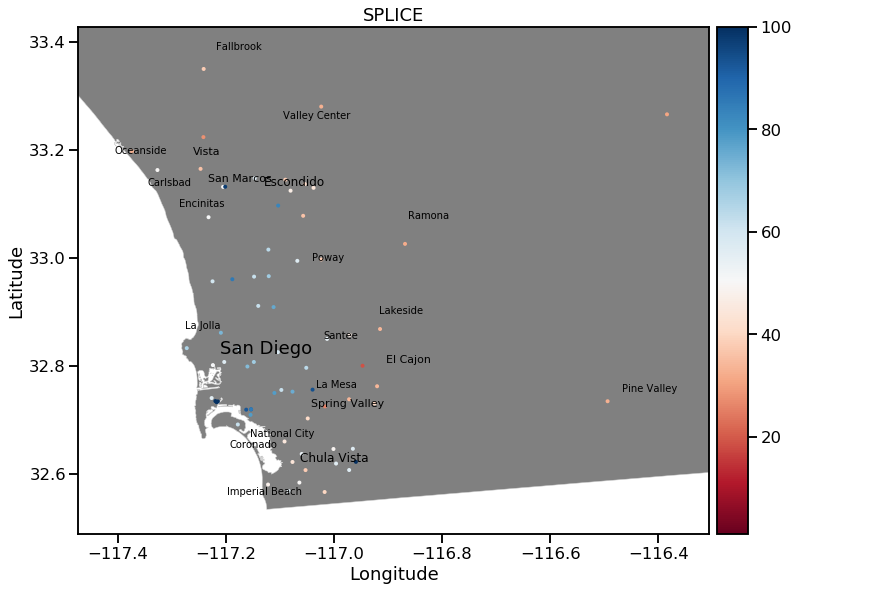

<IPython.core.display.Javascript object>

In [755]:
f, ax1 = plt.subplots(figsize=(12, 12))

# State/county
sew_sf.boundary.plot(ax=ax1, linewidth=0.5, edgecolor='lightgray', facecolor='gray', zorder=0)

# Zip code
# zip_shapefile_wlabels.boundary.plot(ax=ax1, edgecolor='lightgray', linewidth=0.5, facecolor='none', zorder=1)

# Label with SPLICE
g = sns.scatterplot(
    data=df_wgeo,
    x="Longitude",
    y="Latitude",
    palette="RdBu",
    hue="graduation_rates_UCCSU_eligibility_LIstudents",
    s=2 ** 4,
    ax=ax1,
    linewidth=0,
    zorder=2
)
ax1.set_xlim([sd_boundaries[2], sd_boundaries[3]])
ax1.set_ylim([sd_boundaries[0], sd_boundaries[1]])

# Label cities - limit to SD
# Extract local coordinates
zip_shapefile_wlabels_SD = zip_shapefile_wlabels[zip_shapefile_wlabels['County']=='San Diego'].copy()
zip_shapefile_wlabels_SD['coords'] = zip_shapefile_wlabels_SD['geometry'].apply(lambda x: x.representative_point().coords[:])
zip_shapefile_wlabels_SD['coords'] = [coords[0] for coords in zip_shapefile_wlabels_SD['coords']]

# Generate average locations for text and label
df_sd_avgtext_loc = return_avg_loc(zip_shapefile_wlabels_SD, 'City',  min_fontsize=10)
for idx, row in df_sd_avgtext_loc.iterrows():
    ax1.annotate(s=row['index'], xy=row['avg_coord'],
                 horizontalalignment='center', fontsize=row['fontsize'], color='black')

norm = plt.Normalize(df_wgeo['graduation_rates_UCCSU_eligibility_LIstudents'].min(), df_wgeo['graduation_rates_UCCSU_eligibility_LIstudents'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm, cax)
ax1.set_title('SPLICE');

### Other CA counties

#### Bay Area

In [90]:
ba_boundaries = get_map_boundaries('County', search_list=["San Francisco",
    "San Mateo",
    "Santa Clara",
    "Alameda",
    "Fremont",
    "Marin"], buffer=.1)
ba_boundaries

(36.87215770000001, 38.372701299999996, -123.027209, -121.45094470000001)

<IPython.core.display.Javascript object>

In [91]:
zip_shapefile_wlabels_BA

NameError: name 'zip_shapefile_wlabels_BA' is not defined

<IPython.core.display.Javascript object>

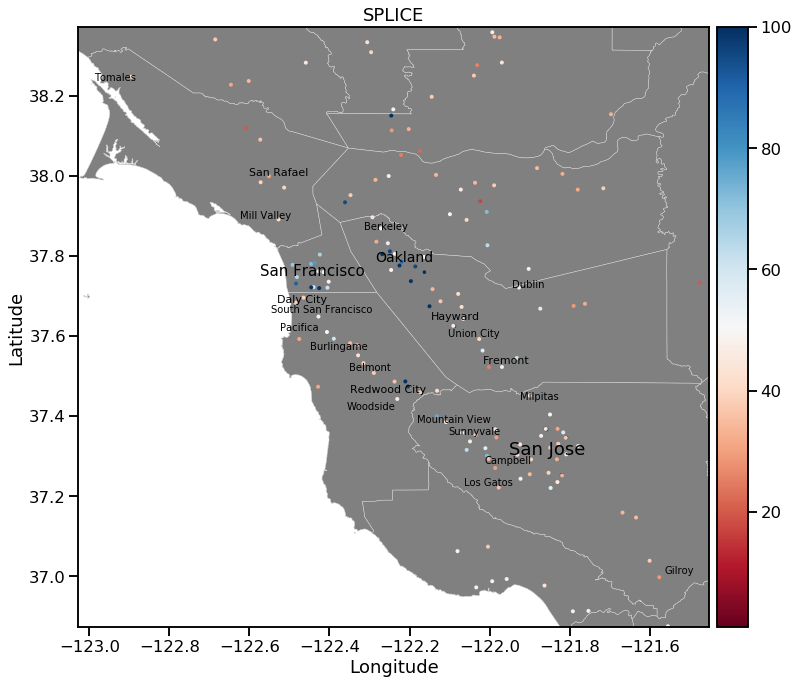

<IPython.core.display.Javascript object>

In [857]:
f, ax1 = plt.subplots(figsize=(12, 12))

# State/county
sew_sf.boundary.plot(ax=ax1, linewidth=0.5, edgecolor='lightgray', facecolor='gray', zorder=0)

# Zip code
# zip_shapefile_wlabels.boundary.plot(ax=ax1, edgecolor='lightgray', linewidth=0.5, facecolor='none', zorder=1)

# Label with SPLICE
g = sns.scatterplot(
    data=df_wgeo,
    x="Longitude",
    y="Latitude",
    palette="RdBu",
    hue="graduation_rates_UCCSU_eligibility_LIstudents",
    s=2 ** 4,
    ax=ax1,
    linewidth=0,
    zorder=2
)
ax1.set_xlim([ba_boundaries[2], ba_boundaries[3]])
ax1.set_ylim([ba_boundaries[0], ba_boundaries[1]])

# Label cities - limit to Bay Area
# Extract local coordinates
zip_shapefile_wlabels_BA = zip_shapefile_wlabels[zip_shapefile_wlabels['County'].isin(["San Francisco",
    "San Mateo",
    "Santa Clara",
    "Alameda",
    "Fremont",
    "Marin"])].copy()
zip_shapefile_wlabels_BA['coords'] = zip_shapefile_wlabels_BA['geometry'].apply(lambda x: x.representative_point().coords[:])
zip_shapefile_wlabels_BA['coords'] = [coords[0] for coords in zip_shapefile_wlabels_BA['coords']]

# Generate average locations for text and label
df_ba_avgtext_loc = return_avg_loc(zip_shapefile_wlabels_BA, 'City',  min_fontsize=10)
for idx, row in df_ba_avgtext_loc.iterrows():
    if idx % 2 == 0:
        # Plot half of them to make it more readable
        ax1.annotate(s=row['index'], xy=row['avg_coord'],
                     horizontalalignment='center', fontsize=row['fontsize'], color='black')

norm = plt.Normalize(df_wgeo['graduation_rates_UCCSU_eligibility_LIstudents'].min(), df_wgeo['graduation_rates_UCCSU_eligibility_LIstudents'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm, cax)
ax1.set_title('SPLICE');

plt.savefig(figure_loc + 'BA_map_school_loc_cities.png');

Blog post idea?:
- show how I made this map
- color bar
- text more readable, size proportional to number
- get Bay

#### Los Angeles

In [92]:
la_boundaries = get_map_boundaries('County', search_list=['Los Angeles'], buffer=.1)
la_boundaries

(33.633738, 34.795961999999996, -118.85238700000001, -117.62355800000002)

<IPython.core.display.Javascript object>

''

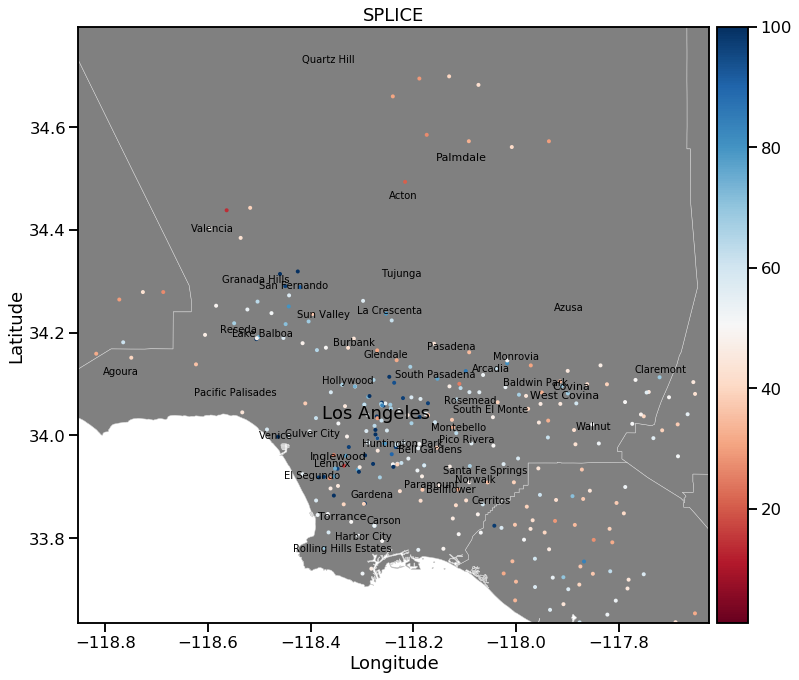

<IPython.core.display.Javascript object>

In [858]:
f, ax1 = plt.subplots(figsize=(12, 12))

# State/county
sew_sf.boundary.plot(ax=ax1, linewidth=0.5, edgecolor='lightgray', facecolor='gray', zorder=0)

# Zip code
# zip_shapefile_wlabels.boundary.plot(ax=ax1, edgecolor='lightgray', linewidth=0.5, facecolor='none', zorder=1)

# Label with SPLICE
g = sns.scatterplot(
    data=df_wgeo,
    x="Longitude",
    y="Latitude",
    palette="RdBu",
    hue="graduation_rates_UCCSU_eligibility_LIstudents",
    s=2 ** 4,
    ax=ax1,
    linewidth=0,
    zorder=2
)
ax1.set_xlim([la_boundaries[2], la_boundaries[3]])
ax1.set_ylim([la_boundaries[0], la_boundaries[1]])

# Label cities - limit to LA
# Extract local coordinates
zip_shapefile_wlabels_LA = zip_shapefile_wlabels[zip_shapefile_wlabels['County'].isin(["Los Angeles"])].copy()
zip_shapefile_wlabels_LA['coords'] = zip_shapefile_wlabels_LA['geometry'].apply(lambda x: x.representative_point().coords[:])
zip_shapefile_wlabels_LA['coords'] = [coords[0] for coords in zip_shapefile_wlabels_LA['coords']]

# Generate average locations for text and label
df_ba_avgtext_loc = return_avg_loc(zip_shapefile_wlabels_LA, 'City',  min_fontsize=10)
for idx, row in df_ba_avgtext_loc.iterrows():
    if idx % 2 != 0:
        # Plot half of them to make it more readable
        ax1.annotate(s=row['index'], xy=row['avg_coord'],
                     horizontalalignment='center', fontsize=row['fontsize'], color='black')

norm = plt.Normalize(df_wgeo['graduation_rates_UCCSU_eligibility_LIstudents'].min(), df_wgeo['graduation_rates_UCCSU_eligibility_LIstudents'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm, cax)
ax1.set_title('SPLICE')
plt.savefig(figure_loc + 'LA_map_school_loc_cities.png');
;

#### Fresno

In [93]:
fresno_boundaries = get_map_boundaries('County', search_list=['Fresno'], buffer=.1)
fresno_boundaries

(36.069696199999996, 36.9653258, -120.559327, -119.2481042)

<IPython.core.display.Javascript object>

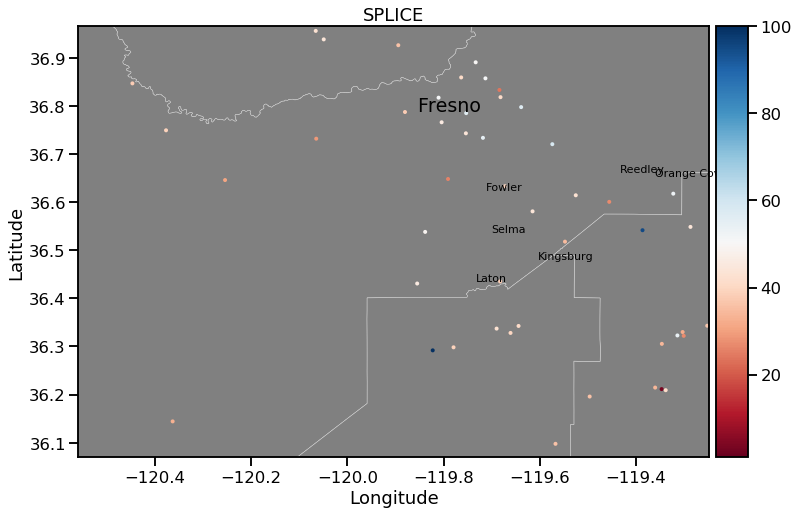

<IPython.core.display.Javascript object>

In [860]:
f, ax1 = plt.subplots(figsize=(12, 12))

# State/county
sew_sf.boundary.plot(ax=ax1, linewidth=0.5, edgecolor='lightgray', facecolor='gray', zorder=0)

# Zip code
# zip_shapefile_wlabels.boundary.plot(ax=ax1, edgecolor='lightgray', linewidth=0.5, facecolor='none', zorder=1)

# Label with SPLICE
g = sns.scatterplot(
    data=df_wgeo,
    x="Longitude",
    y="Latitude",
    palette="RdBu",
    hue="graduation_rates_UCCSU_eligibility_LIstudents",
    s=2 ** 4,
    ax=ax1,
    linewidth=0,
    zorder=2
)
ax1.set_xlim([fresno_boundaries[2], fresno_boundaries[3]])
ax1.set_ylim([fresno_boundaries[0], fresno_boundaries[1]])

# Label cities - limit to Fresno
# Extract local coordinates
zip_shapefile_wlabels_Fresno = zip_shapefile_wlabels[zip_shapefile_wlabels['County'].isin(["Fresno"])].copy()
zip_shapefile_wlabels_Fresno['coords'] = zip_shapefile_wlabels_Fresno['geometry'].apply(lambda x: x.representative_point().coords[:])
zip_shapefile_wlabels_Fresno['coords'] = [coords[0] for coords in zip_shapefile_wlabels_Fresno['coords']]

# Generate average locations for text and label
df_ba_avgtext_loc = return_avg_loc(zip_shapefile_wlabels_Fresno, 'City',  min_fontsize=10)
for idx, row in df_ba_avgtext_loc.iterrows():
    if idx % 2 != 0:
        # Plot half of them to make it more readable
        ax1.annotate(s=row['index'], xy=row['avg_coord'],
                     horizontalalignment='center', fontsize=row['fontsize'], color='black')

norm = plt.Normalize(df_wgeo['graduation_rates_UCCSU_eligibility_LIstudents'].min(), df_wgeo['graduation_rates_UCCSU_eligibility_LIstudents'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm, cax)
ax1.set_title('SPLICE')

plt.savefig(figure_loc + 'Fresno_map_school_loc_cities.png');

#### Check high schools in Tulare county

In [812]:
df_wgeo.loc[df_wgeo['County']=='Tulare', ['School', 'enrollment', 'Charter_cat_encoded', 'pct_LI_students', 'pct_URM', 'graduation_rates_UCCSU_eligibility_LIstudents']].sort_values(by='graduation_rates_UCCSU_eligibility_LIstudents', ascending=False)     

School  enrollment  Charter_cat_encoded  \
1066                      Dinuba High      1989.0                    0   
1064           Harmony Magnet Academy       516.0                    1   
1045      University Preparatory High       245.0                    1   
1051                       Orosi High      1045.0                    0   
1052              Lindsay Senior High      1090.0                    0   
1059                Farmersville High       749.0                    0   
1055                Tulare Union High      1740.0                    0   
1067                    Woodlake High       663.0                    0   
1050                 Golden West High      1651.0                    0   
1053                 Mission Oak High      1464.0                    0   
1062                     Monache High      1781.0                    0   
1047                 El Diamante High      1958.0                    0   
1063                 Porterville High      1932.0                    0   
1056              Tulare Western High      1853.0                    0   
1061               Granite Hills High      1335.0                    0   
1058                     Redwood High      2008.0                    0   
1048                 Mt. Whitney High      1590.0                    0   
1065                  Strathmore High       275.0                    0   
1054        Sierra Vista Charter High       186.0                    1   
1046  Visalia Technical Early College       257.0                    1   
1060              Butterfield Charter       325.0                    1   

      pct_LI_students    pct_URM  \
1066             75.0  92.357969   
1064             58.0  64.534884   
1045             40.0  48.163265   
1051             90.0  92.727273   
1052             86.0  93.119266   
1059             85.0  95.460614   
1055             71.0  74.942529   
1067             83.0  86.274510   
1050             58.0  71.471835   
1053             67.0  76.844262   
1062             65.0  73.498035   
1047             54.0  61.797753   
1063             72.0  79.296066   
1056             74.0  79.816514   
1061             85.0  87.415730   
1058             44.0  63.133426   
1048             52.0  66.352201   
1065             84.0  85.090909   
1054             88.0  80.645161   
1046             46.0  45.669291   
1060             73.0  75.384615   

      graduation_rates_UCCSU_eligibility_LIstudents  
1066                                           95.0  
1064                                           91.0  
1045                                           54.0  
1051                                           44.0  
1052                                           44.0  
1059                                           44.0  
1055                                           41.0  
1067                                           37.0  
1050                                           37.0  
1053                                           36.0  
1062                                           36.0  
1047                                           34.0  
1063                                           34.0  
1056                                           34.0  
1061                                           33.0  
1058                                           32.0  
1048                                           27.0  
1065                                           23.0  
1054                                            3.0  
1046                                            NaN  
1060                                            NaN

<IPython.core.display.Javascript object>

KeyError: '%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months'

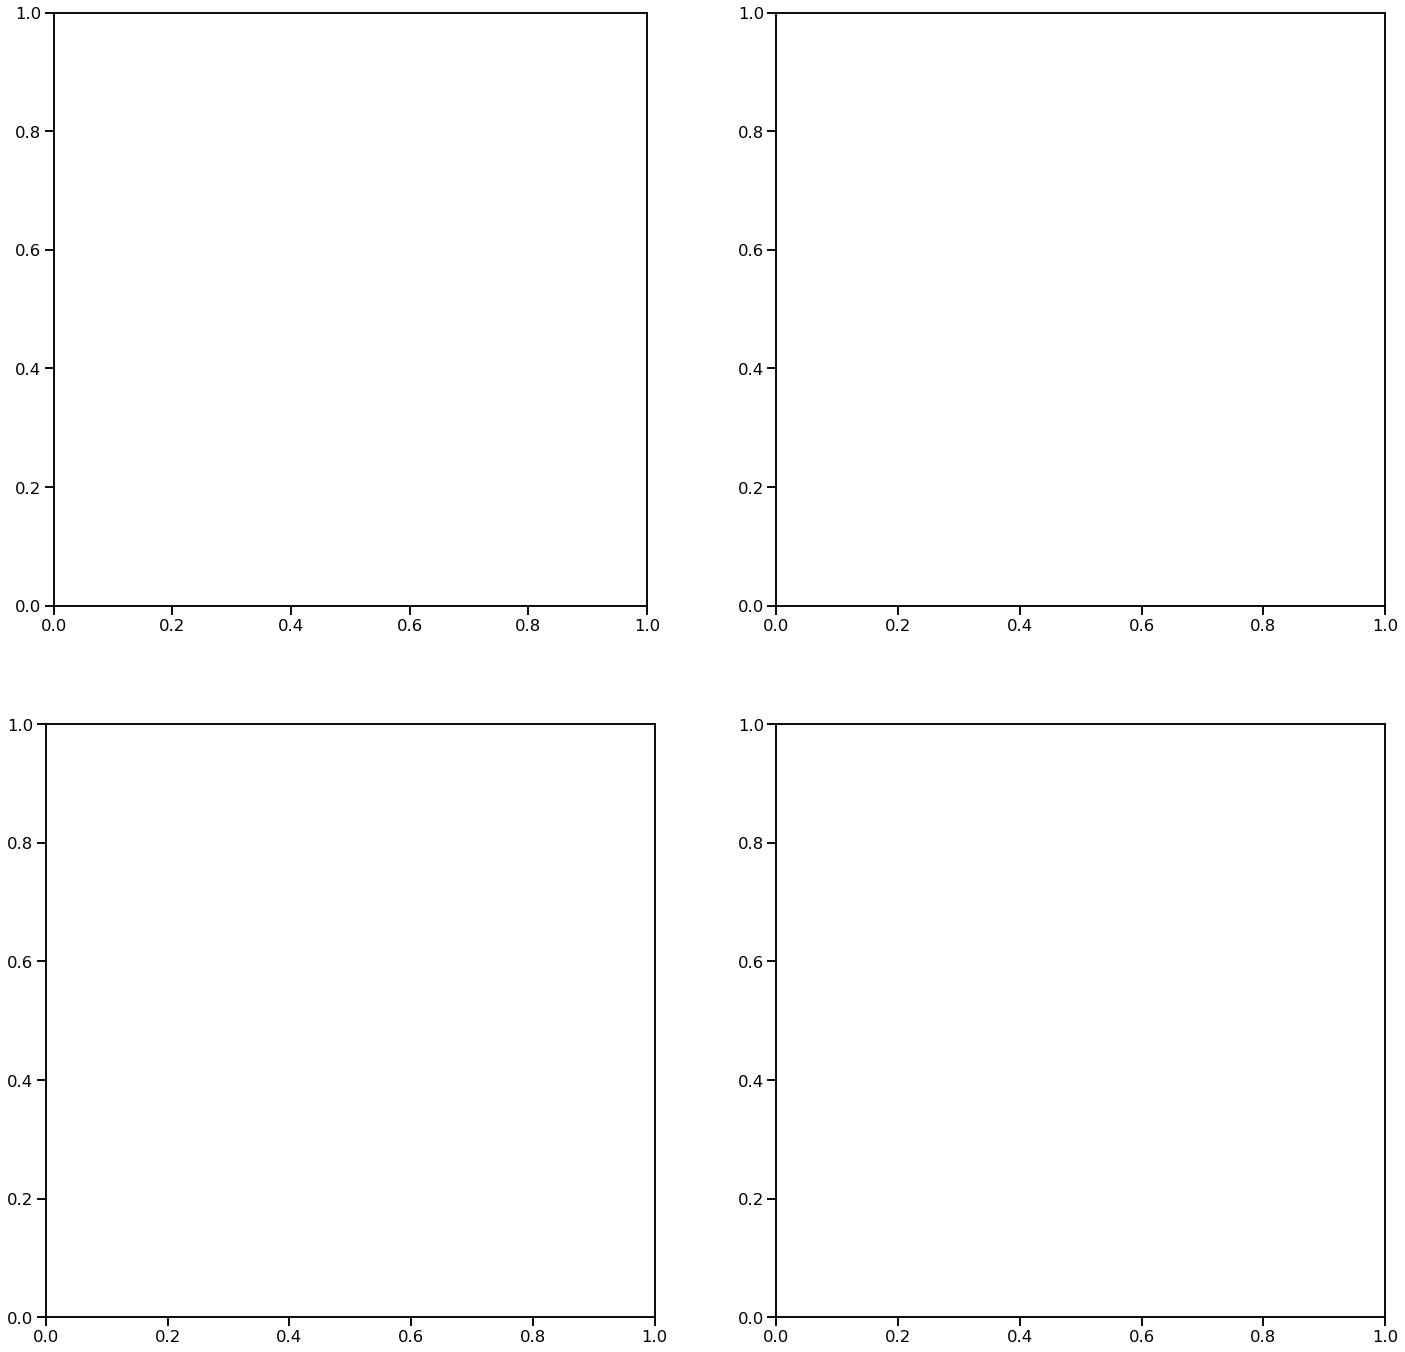

<IPython.core.display.Javascript object>

In [450]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 24))

# CA
# df_CA.plot(ax=ax1, color="gray", zorder=1)
sew_sf.plot(
    column=feat2plot,
    ax=ax1,
    # legend=True,
    edgecolor="black",
    cmap="OrRd",
    linewidth=0.2,
    # legend_kwds={"label": "median household income", "orientation": "vertical"},
)

# Bay Area
df_CA.plot(ax=ax2, color="white", zorder=1)
sew_sf.plot(
    column=feat2plot,
    ax=ax2,
    # legend=True,
    edgecolor="black",
    cmap="OrRd",
    linewidth=0.2,
    # legend_kwds={"label": "median household income", "orientation": "vertical"},
)
ax2.set_xlim([ba_long_min, ba_long_max])
ax2.set_ylim([ba_lat_min, ba_lat_max])


# LA
df_CA.plot(ax=ax3, color="white", zorder=1)
sew_sf.plot(
    column=feat2plot,
    ax=ax3,
    # legend=True,
    edgecolor="black",
    cmap="OrRd",
    linewidth=0.2,
    # legend_kwds={"label": "median household income", "orientation": "vertical"},
)
ax3.set_xlim([la_long_min, la_long_max])
ax3.set_ylim([la_lat_min, la_lat_max])


# SD
df_CA.plot(ax=ax4, color="white", zorder=1)
sew_sf.plot(
    column=feat2plot,
    ax=ax4,
    # legend=True,
    edgecolor="black",
    cmap="OrRd",
    linewidth=0.2,
    # legend_kwds={"label": "median household income", "orientation": "vertical"},
)

ax4.set_xlim([ba_long_min, sd_long_max])
ax4.set_ylim([sd_lat_min, sd_lat_max])

## Census characteristics on the zip code level

In [63]:
df_state_info_gs_census_ziponly.head(2)

zip_code  \
0     94612   
1     94501   

   %; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months  \
0                                                9.2                        
1                                                6.1                        

   %; INCOME_BENEFITS - w/ Social Security  \
0                                     24.0   
1                                     21.9   

   %; INCOME_BENEFITS - w/ Supplemental Security Income  \
0                                               16.0      
1                                                5.0      

   Est.; INCOME_BENEFITS - Total households - Median household income ($)  \
0                                            32993.0                        
1                                            72884.0                        

   Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)  \
0                                            29027.0                           
1                                            32115.0                           

   Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)  \
0                                             5055.0                                                   
1                                             4632.0                                                   

   %; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage  \
0                                               82.2                                      
1                                               89.9                                      

   %; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage  \
0                                               41.3                                                           
1                                               25.8                                                           

   %; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs - No health ins coverage  \
0                                                4.7                                              
1                                                6.0                                              

   ...  %; INDUSTRY - Civilian employed pop. 16 yrs and up - Retail trade  \
0  ...                                                8.9                   
1  ...                                               10.1                   

   %; INDUSTRY - Civilian employed pop. 16 yrs and up - Transportation and warehousing, and utilities  \
0                                                3.0                                                    
1                                                6.2                                                    

   %; INDUSTRY - Civilian employed pop. 16 yrs and up - Wholesale trade  \
0                                                1.2                      
1                                                2.6                      

   %; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Private wage and salary workers  \
0                                               80.5                                          
1                                               75.8                                          

   %; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Self-employed in own not incorporated business workers  \
0                                                8.8                                                                 
1                                                8.6                                                                 

   %; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force  \
0                                               37.3            
1                                               30.7            

   %; EMPLOY_STATUS - Civilian labor force - Unemployment Rate  \
0                                   

<IPython.core.display.Javascript object>

In [903]:
zip_shapefile_wlabels.head(2)

OBJECTID CNTY_FIPS COUNTY TRACT TRACT_ID CENSUS_KEY   ZCTA ZCTA_KEY  \
0         1      None   None  None     None       None  94601  0694601   
1         2      None   None  None     None       None  94501  0694501   

    LATITUDE   LONGITUDE  ...  HU_OCC_O_1  HU_OCC_REN  HU_OCC_R_1  \
0  37.776711 -122.218378  ...       16528       10062       32927   
1  37.774084 -122.278049  ...       26023       14739       32705   

     Shape_area     Shape_len  \
0  8.721649e+06  15265.093880   
1  2.954478e+07  27119.154912   

                                            geometry  zip_code   County  \
0  POLYGON ((-122.22717 37.79197, -122.22693 37.7...     94601  Alameda   
1  POLYGON ((-122.29181 37.76301, -122.30661 37.7...     94501  Alameda   

      City         District  
0  Oakland  Oakland Unified  
1  Alameda  Alameda Unified  

[2 rows x 90 columns]

<IPython.core.display.Javascript object>

### Median household income

In [69]:
feat2plot = "Est.; INCOME_BENEFITS - Total households - Median household income ($)"
df_state_census_wgeo = pd.merge(
    df_state_info_gs_census_ziponly[['zip_code', feat2plot]], zip_shapefile_wlabels, left_on="zip_code", right_on="ZCTA"
)
df_state_census_wgeo.head()

zip_code_x  \
0       94612   
1       94501   
2       94621   
3       94706   
4       94704   

   Est.; INCOME_BENEFITS - Total households - Median household income ($)  \
0                                            32993.0                        
1                                            72884.0                        
2                                            31903.0                        
3                                            80970.0                        
4                                            26478.0                        

   OBJECTID CNTY_FIPS COUNTY TRACT TRACT_ID CENSUS_KEY   ZCTA ZCTA_KEY  ...  \
0       736      None   None  None     None       None  94612  0694612  ...   
1         2      None   None  None     None       None  94501  0694501  ...   
2      1322      None   None  None     None       None  94621  0694621  ...   
3       737      None   None  None     None       None  94706  0694706  ...   
4       730      None   None  None     None       None  94704  0694704  ...   

   HU_OCC_O_1  HU_OCC_REN  HU_OCC_R_1    Shape_area     Shape_len  \
0        1172        7326       11997  2.205249e+06  11539.060839   
1       26023       14739       32705  2.954478e+07  27119.154912   
2       11368        5362       18192  2.473526e+07  35852.648016   
3        9839        3997        9726  3.823563e+06   9233.319582   
4        1790        8255       16870  2.769875e+06  13670.844000   

                                            geometry  zip_code_y   County  \
0  POLYGON ((-199972.483 -21221.402, -199992.804 ...       94612  Alameda   
1  POLYGON ((-201604.187 -25728.139, -202894.954 ...       94501  Alameda   
2  POLYGON ((-193587.647 -25237.359, -193528.218 ...       94621  Alameda   
3  POLYGON ((-201858.856 -10658.115, -201844.334 ...       94706  Alameda   
4  POLYGON ((-199660.444 -13812.923, -199661.705 ...       94704  Alameda   

       City                            District  
0   Oakland  Alameda County Office of Education  
1   Alameda                     Alameda Unified  
2   Oakland                     Oakland Unified  
3    Albany                 Albany City Unified  
4  Berkeley                    Berkeley Unified  

[5 rows x 92 columns]

<IPython.core.display.Javascript object>

In [70]:
zip_shapefile_wfeat = zip_shapefile.set_index('ZCTA').join(df_state_info_gs_census_ziponly[['zip_code', feat2plot]].set_index('zip_code'),
                                         how='left')

<IPython.core.display.Javascript object>

/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


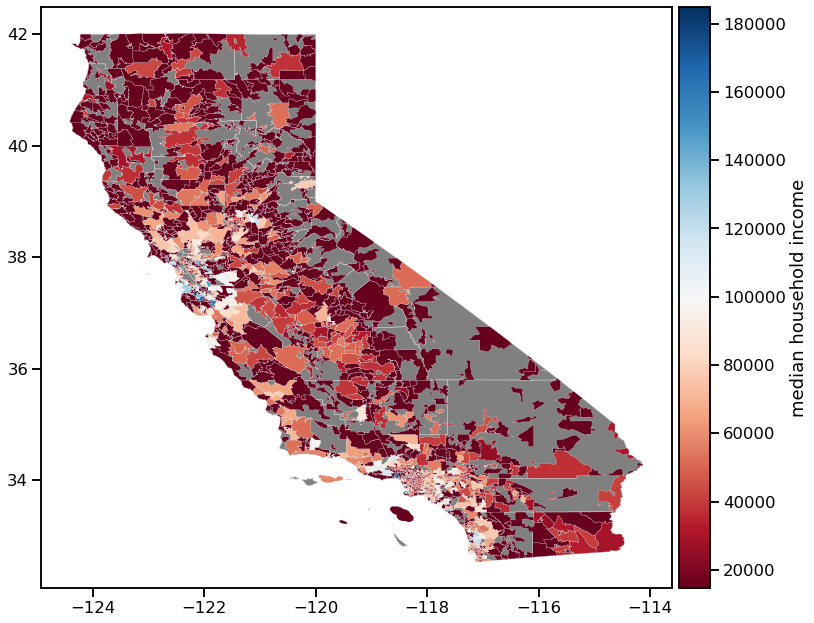

<IPython.core.display.Javascript object>

In [71]:
f, ax1 = plt.subplots(figsize=(12, 12))

# State/county
sew_sf.boundary.plot(ax=ax1, linewidth=0.5, edgecolor='lightgray', facecolor='gray', zorder=0)

# Label with local median income on the zip code level
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
    
# Zip code with feature to plot
zip_shapefile_wfeat.plot(column=feat2plot,
                     ax=ax1,
                     legend=True,
                     edgecolor='white',
                     cmap='RdBu',
                     cax=cax,
                     linewidth = 0.2,
                     legend_kwds={'label':"median household income", 'orientation': "vertical"});


# plt.savefig(figure_loc + 'CA_map_income.png');

In [843]:
# With school locations
# f, ax1 = plt.subplots(figsize=(12, 12))

# # State/county
# sew_sf.boundary.plot(ax=ax1, linewidth=0.5, edgecolor='lightgray', facecolor='gray', zorder=0)

# # Label with local median income on the zip code level
# divider = make_axes_locatable(ax1)
# cax = divider.append_axes("right", size="5%", pad=0.1)
    
# # Zip code with feature to plot
# zip_shapefile_wfeat.plot(column=feat2plot,
#                      ax=ax1,
#                      legend=True,
#                      edgecolor='white',
#                      cmap='RdBu',
#                      cax=cax,
#                      linewidth = 0.2,
#                      legend_kwds={'label':"median household income", 'orientation': "vertical"})

# Label with school location - too hard to see zip code feature
# ax1.scatter(
#     df_wgeo["Longitude"],
#     df_wgeo["Latitude"],
#     edgecolors="black",
#     linewidth=0.5,
#     facecolors='none',
#     s=2 ** 1,
#     zorder=2
# );

<IPython.core.display.Javascript object>

### SD county

/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


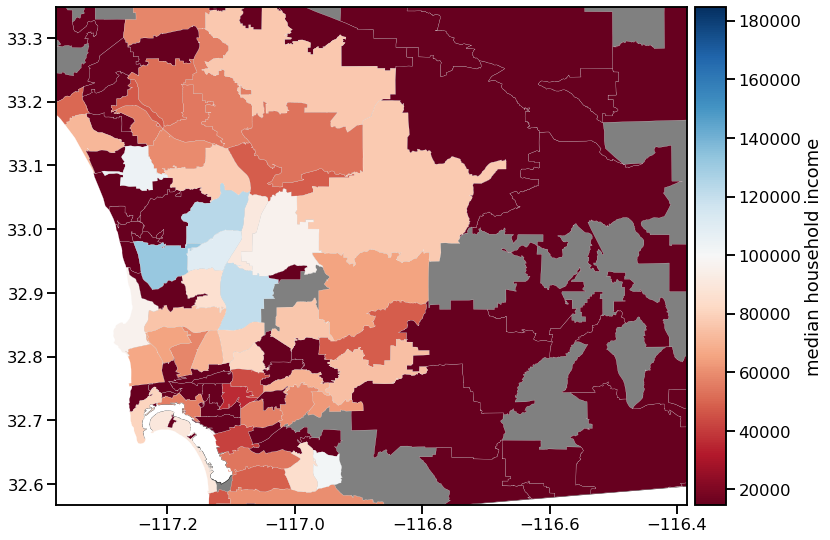

<IPython.core.display.Javascript object>

In [72]:
f, ax1 = plt.subplots(figsize=(12, 12))

# State/county
sew_sf.boundary.plot(ax=ax1, linewidth=0.5, edgecolor='black', facecolor='gray', zorder=0)

# Label with local median income on the zip code level
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
    
# Zip code with feature to plot
zip_shapefile_wfeat.plot(column=feat2plot,
                     ax=ax1,
                     legend=True,
                     edgecolor='white',
                     cmap='RdBu',
                     cax=cax,
                     linewidth = 0.2,
                     legend_kwds={'label':"median household income", 'orientation': "vertical"})

ax1.set_xlim([sd_long_min, sd_long_max])
ax1.set_ylim([sd_lat_min, sd_lat_max]);

### Work commute, public transportation

In [76]:
feat2plot = "%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)"
df_state_census_wgeo = pd.merge(
    df_state_info_gs_census_ziponly[['zip_code', feat2plot]], zip_shapefile_wlabels, left_on="zip_code", right_on="ZCTA"
)
df_state_census_wgeo.head(2)

zip_code_x  \
0       94612   
1       94501   

   %; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)  \
0                                               36.5                                     
1                                               16.8                                     

   OBJECTID CNTY_FIPS COUNTY TRACT TRACT_ID CENSUS_KEY   ZCTA ZCTA_KEY  ...  \
0       736      None   None  None     None       None  94612  0694612  ...   
1         2      None   None  None     None       None  94501  0694501  ...   

   HU_OCC_O_1  HU_OCC_REN  HU_OCC_R_1    Shape_area     Shape_len  \
0        1172        7326       11997  2.205249e+06  11539.060839   
1       26023       14739       32705  2.954478e+07  27119.154912   

                                            geometry  zip_code_y   County  \
0  POLYGON ((-199972.483 -21221.402, -199992.804 ...       94612  Alameda   
1  POLYGON ((-201604.187 -25728.139, -202894.954 ...       94501  Alameda   

      City                            District  
0  Oakland  Alameda County Office of Education  
1  Alameda                     Alameda Unified  

[2 rows x 92 columns]

<IPython.core.display.Javascript object>

In [78]:
feat2plot = "%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)"
zip_shapefile_wfeat = zip_shapefile.set_index('ZCTA').join(df_state_info_gs_census_ziponly[['zip_code', feat2plot]].set_index('zip_code'),
                                         how='left')
zip_shapefile_wfeat.head()

OBJECTID CNTY_FIPS COUNTY TRACT TRACT_ID CENSUS_KEY ZCTA_KEY  \
ZCTA                                                                  
94601         1      None   None  None     None       None  0694601   
94501         2      None   None  None     None       None  0694501   
94560         3      None   None  None     None       None  0694560   
94587         4      None   None  None     None       None  0694587   
94580         5      None   None  None     None       None  0694580   

        LATITUDE   LONGITUDE  TOT_POP  ...  HU_VAC_REN  HU_VAC_SEA  \
ZCTA                                   ...                           
94601  37.776711 -122.218378    50294  ...         839          28   
94501  37.774084 -122.278049    60212  ...         885         189   
94560  37.520360 -122.031000    42573  ...         170          17   
94587  37.603151 -122.018626    69516  ...         384          39   
94580  37.676958 -122.133606    27152  ...         116          15   

       HU_OCC_OWN  HU_OCC_O_1  HU_OCC_REN  HU_OCC_R_1    Shape_area  \
ZCTA                                                                  
94601        4764       16528       10062       32927  8.721649e+06   
94501       10286       26023       14739       32705  2.954478e+07   
94560        8942       28489        4030       13939  3.581839e+07   
94587       13580       46272        6853       22726  5.107510e+07   
94580        6105       18760        2519        8252  8.946896e+06   

          Shape_len                                           geometry  \
ZCTA                                                                     
94601  15265.093880  POLYGON ((-122.22717 37.79197, -122.22693 37.7...   
94501  27119.154912  POLYGON ((-122.29181 37.76301, -122.30661 37.7...   
94560  30752.336176  POLYGON ((-122.05499 37.54960, -122.05441 37.5...   
94587  53110.314427  POLYGON ((-122.06515 37.60485, -122.06499 37.6...   
94580  20260.685185  POLYGON ((-122.12999 37.68445, -122.12995 37.6...   

       %; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)  
ZCTA                                                                                        
94601                                               20.8                                    
94501                                               16.8                                    
94560                                                4.7                                    
94587                                                8.7                                    
94580                                                9.9                                    

[5 rows x 86 columns]

<IPython.core.display.Javascript object>

/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


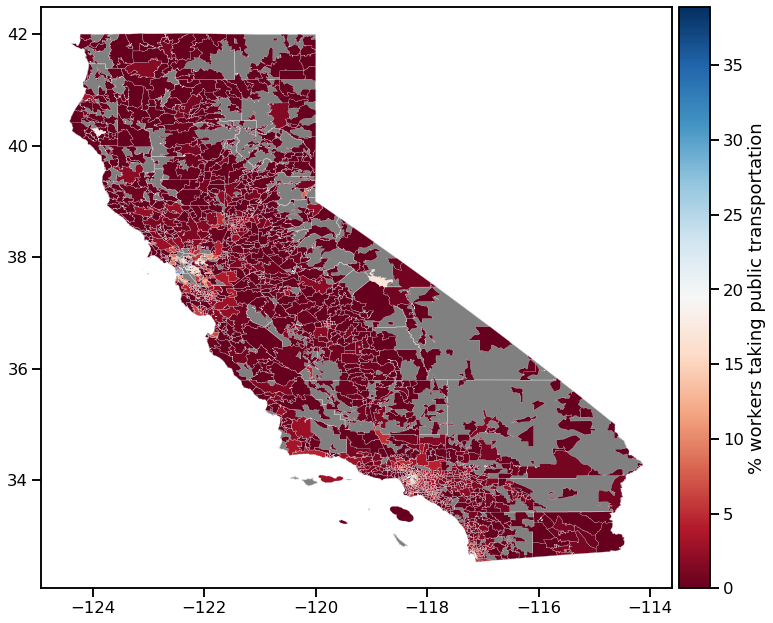

<IPython.core.display.Javascript object>

In [81]:
f, ax1 = plt.subplots(figsize=(12, 12))

# State/county
sew_sf.boundary.plot(ax=ax1, linewidth=0.5, edgecolor='lightgray', facecolor='gray', zorder=0)

# Label with local median income on the zip code level
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
    
# Zip code with feature to plot
zip_shapefile_wfeat.plot(column=feat2plot,
                     ax=ax1,
                     legend=True,
                     edgecolor='white',
                     cmap='RdBu',
                     cax=cax,
                     linewidth = 0.2,
                     legend_kwds={'label':"% workers taking public transportation", 'orientation': "vertical"});


#plt.savefig(figure_loc + 'CA_map_income.png');

### SD county

/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


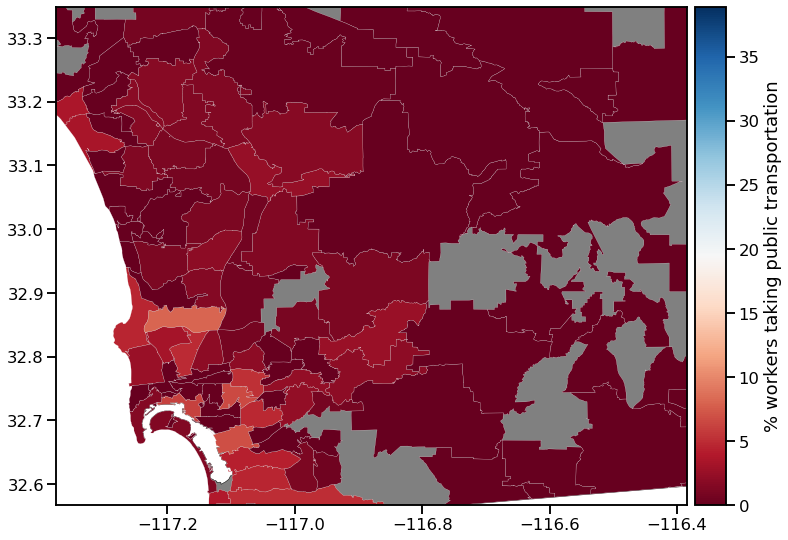

<IPython.core.display.Javascript object>

In [82]:
f, ax1 = plt.subplots(figsize=(12, 12))

# State/county
sew_sf.boundary.plot(ax=ax1, linewidth=0.5, edgecolor='black', facecolor='gray', zorder=0)

# Label with local median income on the zip code level
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
    
# Zip code with feature to plot
zip_shapefile_wfeat.plot(column=feat2plot,
                     ax=ax1,
                     legend=True,
                     edgecolor='white',
                     cmap='RdBu',
                     cax=cax,
                     linewidth = 0.2,
                     legend_kwds={'label':"% workers taking public transportation", 'orientation': "vertical"})

ax1.set_xlim([sd_long_min, sd_long_max])
ax1.set_ylim([sd_lat_min, sd_lat_max]);

### LA County

/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


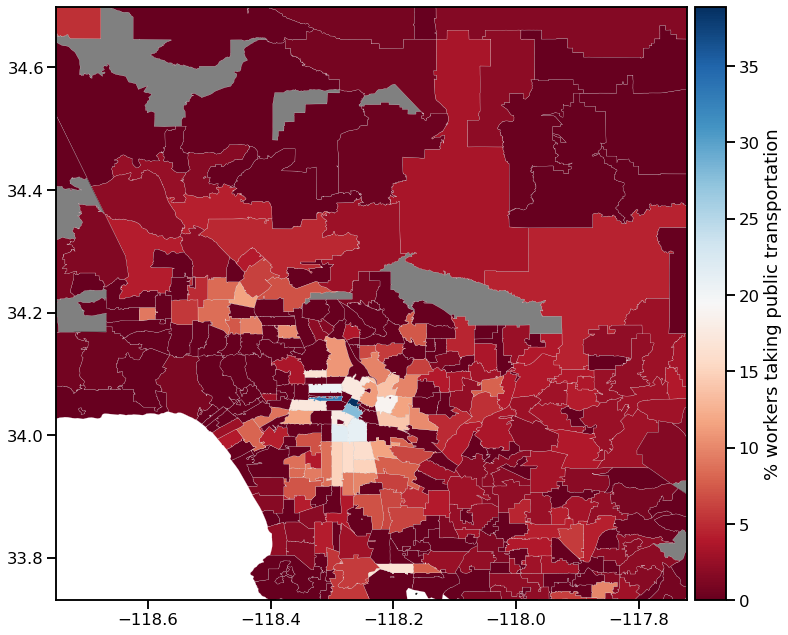

<IPython.core.display.Javascript object>

In [94]:
f, ax1 = plt.subplots(figsize=(12, 12))

# State/county
sew_sf.boundary.plot(ax=ax1, linewidth=0.5, edgecolor='black', facecolor='gray', zorder=0)

# Label with local median income on the zip code level
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
    
# Zip code with feature to plot
zip_shapefile_wfeat.plot(column=feat2plot,
                     ax=ax1,
                     legend=True,
                     edgecolor='white',
                     cmap='RdBu',
                     cax=cax,
                     linewidth = 0.2,
                     legend_kwds={'label':"% workers taking public transportation", 'orientation': "vertical"})

ax1.set_xlim([la_long_min, la_long_max])
ax1.set_ylim([la_lat_min, la_lat_max]);

### Bay Area

/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


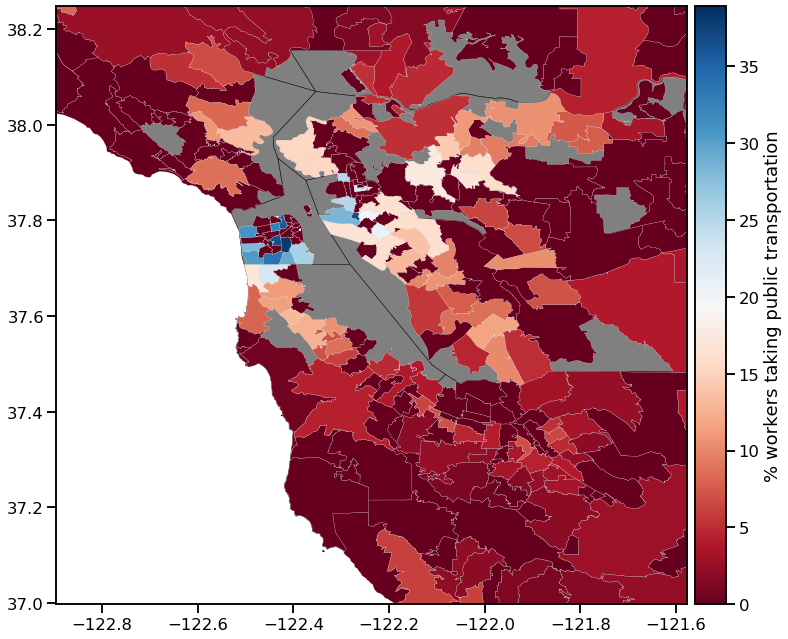

<IPython.core.display.Javascript object>

In [95]:
f, ax1 = plt.subplots(figsize=(12, 12))

# State/county
sew_sf.boundary.plot(ax=ax1, linewidth=0.5, edgecolor='black', facecolor='gray', zorder=0)

# Label with local median income on the zip code level
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
    
# Zip code with feature to plot
zip_shapefile_wfeat.plot(column=feat2plot,
                     ax=ax1,
                     legend=True,
                     edgecolor='white',
                     cmap='RdBu',
                     cax=cax,
                     linewidth = 0.2,
                     legend_kwds={'label':"% workers taking public transportation", 'orientation': "vertical"})

ax1.set_xlim([ba_long_min, ba_long_max])
ax1.set_ylim([ba_lat_min, ba_lat_max]);

In [101]:
df_state_info_gs_census.loc[:, ["School", "City", "Charter_cat_encoded", "%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)", "graduation_rates_UCCSU_eligibility_LIstudents"]].sort_values(by='%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)', ascending=False).head(30)

School           City  \
308  Contreras Learning Center-School of Social Jus...    Los Angeles   
307  Contreras Learning Center-Los Angeles School o...    Los Angeles   
838                              O'Connell (John) High  San Francisco   
0               Envision Academy for Arts & Technology        Oakland   
837                                       Mission High  San Francisco   
834                                       Galileo High  San Francisco   
824                            City Arts and Tech High  San Francisco   
825                                        Balboa High  San Francisco   
826                                    Leadership High  San Francisco   
329          School for the Visual Arts and Humanities    Los Angeles   
328                Los Angeles High School of the Arts    Los Angeles   
830                Wallenberg (Raoul) Traditional High  San Francisco   
831                                       Gateway High  San Francisco   
839                           Washington (George) High  San Francisco   
836                                        Lowell High  San Francisco   
832            Burton (Phillip and Sala) Academic High  San Francisco   
22                         American Indian Public High        Oakland   
835                             Lincoln (Abraham) High  San Francisco   
299        Early College Academy-LA Trade Tech College    Los Angeles   
298                       Alliance Dr. Olga Mohan High    Los Angeles   
829                           Marshall (Thurgood) High  San Francisco   
4                                          Albany High         Albany   
7                                      Emery Secondary     Emeryville   
877                                     Jefferson High      Daly City   
5                                        Berkeley High       Berkeley   
256                              Wallis Annenberg High    Los Angeles   
257  Alliance Patti And Peter Neuwirth Leadership A...    Los Angeles   
258                            Manual Arts Senior High    Los Angeles   
288                           Santee Education Complex    Los Angeles   
292                       Thomas Jefferson Senior High    Los Angeles   

     Charter_cat_encoded  \
308                    0   
307                    0   
838                    0   
0                      1   
837                    0   
834                    0   
824                    1   
825                    0   
826                    1   
329                    0   
328                    0   
830                    0   
831                    1   
839                    0   
836                    0   
832                    0   
22                     1   
835                    0   
299                    0   
298                    1   
829                    0   
4                      0   
7                      0   
877                    0   
5                      0   
256                    1   
257                    1   
258                    0   
288                    0   
292                    0   

     %; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)  \
308                                               38.9                                     
307                                               38.9                                     
838                                               38.0                                     
0                                                 36.5                                     
837                                               36.5                                     
834                                               35.9                                     
824                                               33.8                                     
825                                               33.8                                     
826                                               33.8                                 

<IPython.core.display.Javascript object>

# ---